In [3]:
"""
@author: albertigno

"""

from MyDataset import *
import torch, time, os
import torch.nn as nn
import torch.nn.functional as F
#import networkx as nx
import matplotlib.pyplot as plt
#from matplotlib.gridspec import GridSpec

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Running on: {}'.format(device))

/Users/alberto/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Running on: cpu


In [2]:
thresh = 0.3
batch_size = 256 # default 256
learning_rate = 1e-4 # default 1e-4
time_window = 50 # shd 50, nmnist 25-30
dataset_path = r'./../../datasets'

In [3]:
train_path = dataset_path+'/shd_digits/shd_train.h5'
test_path = dataset_path+'/shd_digits/shd_test.h5'
# load datasets
print("loading test set...")
test_dataset = MyDataset(test_path, 'hd_digits', time_window, device)
print("loading training set...")
train_dataset = MyDataset(train_path, 'hd_digits', time_window, device)
print("loading data with pytorch")
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True, drop_last=True)

loading test set...
num sample: 2264
torch.Size([2264, 50, 700]) torch.Size([2264, 20])
loading training set...
num sample: 8156
torch.Size([8156, 50, 700]) torch.Size([8156, 20])
loading data with pytorch


In [8]:
from snn_models import *
%load_ext autoreload
%autoreload 1
%aimport snn_models

In [1]:
# parameter grid
num_epochs = 200
import numpy as np

tau_m = [0.8305, 'adp']
num_hidden = [128, 256, 512, 1024, 2048]
delay_mode = ['nodelay','delay']
vreset = [0.0, 0.1]

num = len(tau_m)*len(num_hidden)*len(delay_mode)*len(vreset)

x, y, z, w = np.meshgrid(tau_m, num_hidden, delay_mode, vreset)
x=x.reshape(num)
y=y.reshape(num)
z=z.reshape(num)
w=w.reshape(num)

In [25]:
for i in range(num):

    if x[i]!='adp':
        tau_m = float(x[i]) 
    else:
        tau_m = x[i]
    num_hidden = int(y[i])
    delay_mode = z[i]
    vreset = float(w[i])

    #tau_m = 0.8305
    #snn = RSNN_delay(d='shd', num_hidden=128, thresh=0.3, decay=0.3, batch_size=batch_size, win=50, device=device)
    
    if delay_mode == 'nodelay':
        delay_name = ''
        snn = RSNN('shd', num_hidden=num_hidden, thresh=0.3, tau_m=tau_m, vreset=vreset, batch_size=batch_size, win=time_window, device=device)
    else:
        delay_name = '_delay'
        snn = RSNN_d('shd', num_hidden=num_hidden, thresh=0.3, tau_m=tau_m, vreset=vreset, batch_size=batch_size, win=time_window, device=device)

    snn.to(device)
    
    if tau_m != 'adp':
        tau_name = ''
    else:
        tau_name = '_adp'
        
    if vreset==0:
        vreset_name = ''
    else:
        vreset_name = '_vreset'
        
    # training configuration
    modelname = 'shd_rnn_{}{}{}{}.t7'.format(num_hidden, tau_name, delay_name, vreset_name)
    
    print("-------TRAINING {} ---------".format(modelname))
    num_samples = train_dataset.images.size()[0]

    # super pythonic way to extract the parameters that will have 'normal' learning rate
    base_params = [getattr(snn,name.split('.')[0]).weight for name, _ in snn.state_dict().items() if name[0]=='f']

    # setting different learning rate for tau_m, if neeeded
    if tau_m=='adp':
        optimizer = torch.optim.Adam([
            {'params': base_params},
            {'params': snn.tau_m_h, 'lr': learning_rate * 10.0}],
            lr=learning_rate)
    else:    
        optimizer = torch.optim.Adam([
            {'params': base_params}],
            lr=learning_rate)

    act_fun = ActFun.apply


    # training loop
    taus_m = []
    for epoch in range(num_epochs):
        print('Epoch [%d/%d]'  % (epoch + 1, num_epochs))
        start_time = time.time()
        snn.train_step(train_loader, optimizer=optimizer, criterion=nn.MSELoss(), num_samples = num_samples)
        t = time.time() - start_time
        print('Time elasped:', time.time() - start_time)

        # update learning rate
        optimizer = snn.lr_scheduler(optimizer, lr_decay_epoch=1)

        # weight and decay recording
        # taus_m.append((snn.tau_m_h.data.detach().clone(), snn.tau_m_o.data.detach().clone()))

        if (epoch+1) % 5 ==0:
            snn.test(test_loader, criterion=nn.MSELoss())
            snn.save_model(modelname)   

    with open('training_log', 'a') as logs:
        logs.write("\nFinished training {} epochs for {}, batch_size {}, time_per_epoch {} s".format(num_epochs, modelname, batch_size, t))   



-------TRAINING shd_rnn_128.t7 ---------
Epoch [1/200]
Step [10/31], Loss: 0.50669
Step [20/31], Loss: 0.48628
Step [30/31], Loss: 0.48065
Time elasped: 2.338125705718994
Epoch [2/200]
Step [10/31], Loss: 0.47402
Step [20/31], Loss: 0.46763
Step [30/31], Loss: 0.46392
Time elasped: 2.3072896003723145
Epoch [3/200]
Step [10/31], Loss: 0.45579
Step [20/31], Loss: 0.45431
Step [30/31], Loss: 0.45088
Time elasped: 2.3101463317871094
Epoch [4/200]
Step [10/31], Loss: 0.44632
Step [20/31], Loss: 0.44278
Step [30/31], Loss: 0.44066
Time elasped: 2.31925368309021
Epoch [5/200]
Step [10/31], Loss: 0.43811
Step [20/31], Loss: 0.43377
Step [30/31], Loss: 0.43154
Time elasped: 2.3092103004455566
Test Accuracy of the model on the test samples: 30.029
Epoch [6/200]
Step [10/31], Loss: 0.42685
Step [20/31], Loss: 0.42596
Step [30/31], Loss: 0.42593
Time elasped: 2.3319456577301025
Epoch [7/200]
Step [10/31], Loss: 0.42065
Step [20/31], Loss: 0.41928
Step [30/31], Loss: 0.41654
Time elasped: 2.4275629

Step [30/31], Loss: 0.26343
Time elasped: 2.2927510738372803
Epoch [59/200]
Step [10/31], Loss: 0.26227
Step [20/31], Loss: 0.26133
Step [30/31], Loss: 0.26325
Time elasped: 2.293663740158081
Epoch [60/200]
Step [10/31], Loss: 0.26224
Step [20/31], Loss: 0.25889
Step [30/31], Loss: 0.25845
Time elasped: 2.2760913372039795
Test Accuracy of the model on the test samples: 60.498
Epoch [61/200]
Step [10/31], Loss: 0.26244
Step [20/31], Loss: 0.26083
Step [30/31], Loss: 0.25600
Time elasped: 2.2751753330230713
Epoch [62/200]
Step [10/31], Loss: 0.25565
Step [20/31], Loss: 0.25583
Step [30/31], Loss: 0.26083
Time elasped: 2.2771546840667725
Epoch [63/200]
Step [10/31], Loss: 0.25381
Step [20/31], Loss: 0.26278
Step [30/31], Loss: 0.25690
Time elasped: 2.278498888015747
Epoch [64/200]
Step [10/31], Loss: 0.25653
Step [20/31], Loss: 0.25307
Step [30/31], Loss: 0.25723
Time elasped: 2.281766891479492
Epoch [65/200]
Step [10/31], Loss: 0.25987
Step [20/31], Loss: 0.25778
Step [30/31], Loss: 0.25

Step [10/31], Loss: 0.23936
Step [20/31], Loss: 0.24363
Step [30/31], Loss: 0.23509
Time elasped: 2.2737879753112793
Epoch [117/200]
Step [10/31], Loss: 0.23918
Step [20/31], Loss: 0.23997
Step [30/31], Loss: 0.23953
Time elasped: 2.2682621479034424
Epoch [118/200]
Step [10/31], Loss: 0.23775
Step [20/31], Loss: 0.24139
Step [30/31], Loss: 0.23729
Time elasped: 2.266584873199463
Epoch [119/200]
Step [10/31], Loss: 0.24072
Step [20/31], Loss: 0.23601
Step [30/31], Loss: 0.23779
Time elasped: 2.2797107696533203
Epoch [120/200]
Step [10/31], Loss: 0.24153
Step [20/31], Loss: 0.23841
Step [30/31], Loss: 0.24070
Time elasped: 2.2690815925598145
Test Accuracy of the model on the test samples: 62.158
Epoch [121/200]
Step [10/31], Loss: 0.24194
Step [20/31], Loss: 0.23670
Step [30/31], Loss: 0.24075
Time elasped: 2.268890619277954
Epoch [122/200]
Step [10/31], Loss: 0.24079
Step [20/31], Loss: 0.23929
Step [30/31], Loss: 0.23980
Time elasped: 2.2748360633850098
Epoch [123/200]
Step [10/31], Lo

Step [30/31], Loss: 0.23341
Time elasped: 2.2762057781219482
Epoch [174/200]
Step [10/31], Loss: 0.23796
Step [20/31], Loss: 0.23897
Step [30/31], Loss: 0.22894
Time elasped: 2.276337146759033
Epoch [175/200]
Step [10/31], Loss: 0.23493
Step [20/31], Loss: 0.24025
Step [30/31], Loss: 0.23074
Time elasped: 2.294680118560791
Test Accuracy of the model on the test samples: 62.256
Epoch [176/200]
Step [10/31], Loss: 0.23554
Step [20/31], Loss: 0.23457
Step [30/31], Loss: 0.23541
Time elasped: 2.273869037628174
Epoch [177/200]
Step [10/31], Loss: 0.23407
Step [20/31], Loss: 0.23684
Step [30/31], Loss: 0.23560
Time elasped: 2.276886463165283
Epoch [178/200]
Step [10/31], Loss: 0.23662
Step [20/31], Loss: 0.23482
Step [30/31], Loss: 0.23095
Time elasped: 2.2846732139587402
Epoch [179/200]
Step [10/31], Loss: 0.23789
Step [20/31], Loss: 0.23392
Step [30/31], Loss: 0.23158
Time elasped: 2.327153205871582
Epoch [180/200]
Step [10/31], Loss: 0.23259
Step [20/31], Loss: 0.23566
Step [30/31], Loss:

Test Accuracy of the model on the test samples: 53.516
Epoch [31/200]
Step [10/31], Loss: 0.31091
Step [20/31], Loss: 0.31147
Step [30/31], Loss: 0.31164
Time elasped: 2.2760534286499023
Epoch [32/200]
Step [10/31], Loss: 0.31165
Step [20/31], Loss: 0.30988
Step [30/31], Loss: 0.31158
Time elasped: 2.2684481143951416
Epoch [33/200]
Step [10/31], Loss: 0.31152
Step [20/31], Loss: 0.30989
Step [30/31], Loss: 0.30467
Time elasped: 2.2769832611083984
Epoch [34/200]
Step [10/31], Loss: 0.30447
Step [20/31], Loss: 0.30979
Step [30/31], Loss: 0.30592
Time elasped: 2.3042755126953125
Epoch [35/200]
Step [10/31], Loss: 0.30596
Step [20/31], Loss: 0.30389
Step [30/31], Loss: 0.30511
Time elasped: 2.32059907913208
Test Accuracy of the model on the test samples: 55.322
Epoch [36/200]
Step [10/31], Loss: 0.31456
Step [20/31], Loss: 0.30767
Step [30/31], Loss: 0.30303
Time elasped: 2.3044447898864746
Epoch [37/200]
Step [10/31], Loss: 0.30454
Step [20/31], Loss: 0.30142
Step [30/31], Loss: 0.30090
T

Step [30/31], Loss: 0.25292
Time elasped: 2.278569459915161
Epoch [89/200]
Step [10/31], Loss: 0.24733
Step [20/31], Loss: 0.25113
Step [30/31], Loss: 0.25521
Time elasped: 2.261103868484497
Epoch [90/200]
Step [10/31], Loss: 0.24911
Step [20/31], Loss: 0.25226
Step [30/31], Loss: 0.25177
Time elasped: 2.260343074798584
Test Accuracy of the model on the test samples: 58.643
Epoch [91/200]
Step [10/31], Loss: 0.25015
Step [20/31], Loss: 0.25500
Step [30/31], Loss: 0.25017
Time elasped: 2.3019232749938965
Epoch [92/200]
Step [10/31], Loss: 0.24718
Step [20/31], Loss: 0.25275
Step [30/31], Loss: 0.24949
Time elasped: 2.268512725830078
Epoch [93/200]
Step [10/31], Loss: 0.24874
Step [20/31], Loss: 0.25392
Step [30/31], Loss: 0.24888
Time elasped: 2.2683963775634766
Epoch [94/200]
Step [10/31], Loss: 0.25255
Step [20/31], Loss: 0.24288
Step [30/31], Loss: 0.24820
Time elasped: 2.2715718746185303
Epoch [95/200]
Step [10/31], Loss: 0.25226
Step [20/31], Loss: 0.24508
Step [30/31], Loss: 0.246

Test Accuracy of the model on the test samples: 57.617
Epoch [146/200]
Step [10/31], Loss: 0.23978
Step [20/31], Loss: 0.23988
Step [30/31], Loss: 0.23579
Time elasped: 2.267794609069824
Epoch [147/200]
Step [10/31], Loss: 0.23951
Step [20/31], Loss: 0.23942
Step [30/31], Loss: 0.24032
Time elasped: 2.266838312149048
Epoch [148/200]
Step [10/31], Loss: 0.23774
Step [20/31], Loss: 0.23982
Step [30/31], Loss: 0.23383
Time elasped: 2.2778759002685547
Epoch [149/200]
Step [10/31], Loss: 0.23550
Step [20/31], Loss: 0.23742
Step [30/31], Loss: 0.24066
Time elasped: 2.2690792083740234
Epoch [150/200]
Step [10/31], Loss: 0.23828
Step [20/31], Loss: 0.23877
Step [30/31], Loss: 0.23623
Time elasped: 2.2680141925811768
Test Accuracy of the model on the test samples: 58.105
Epoch [151/200]
Step [10/31], Loss: 0.24045
Step [20/31], Loss: 0.24014
Step [30/31], Loss: 0.23525
Time elasped: 2.283449411392212
Epoch [152/200]
Step [10/31], Loss: 0.23818
Step [20/31], Loss: 0.23849
Step [30/31], Loss: 0.2

Step [30/31], Loss: 0.45474
Time elasped: 2.716007947921753
Epoch [3/200]
Step [10/31], Loss: 0.44764
Step [20/31], Loss: 0.44057
Step [30/31], Loss: 0.43255
Time elasped: 2.694302797317505
Epoch [4/200]
Step [10/31], Loss: 0.42551
Step [20/31], Loss: 0.42186
Step [30/31], Loss: 0.41877
Time elasped: 2.7021071910858154
Epoch [5/200]
Step [10/31], Loss: 0.41056
Step [20/31], Loss: 0.40837
Step [30/31], Loss: 0.40341
Time elasped: 2.7248475551605225
Test Accuracy of the model on the test samples: 43.701
Epoch [6/200]
Step [10/31], Loss: 0.39734
Step [20/31], Loss: 0.39680
Step [30/31], Loss: 0.39363
Time elasped: 2.7050564289093018
Epoch [7/200]
Step [10/31], Loss: 0.38955
Step [20/31], Loss: 0.38710
Step [30/31], Loss: 0.38231
Time elasped: 2.694523811340332
Epoch [8/200]
Step [10/31], Loss: 0.37804
Step [20/31], Loss: 0.37580
Step [30/31], Loss: 0.37151
Time elasped: 2.6789793968200684
Epoch [9/200]
Step [10/31], Loss: 0.36721
Step [20/31], Loss: 0.36449
Step [30/31], Loss: 0.36134
Tim

Step [20/31], Loss: 0.21428
Step [30/31], Loss: 0.21403
Time elasped: 2.685619831085205
Test Accuracy of the model on the test samples: 68.750
Epoch [61/200]
Step [10/31], Loss: 0.21478
Step [20/31], Loss: 0.21616
Step [30/31], Loss: 0.20965
Time elasped: 2.67529034614563
Epoch [62/200]
Step [10/31], Loss: 0.21264
Step [20/31], Loss: 0.21236
Step [30/31], Loss: 0.21056
Time elasped: 2.666262626647949
Epoch [63/200]
Step [10/31], Loss: 0.21316
Step [20/31], Loss: 0.21047
Step [30/31], Loss: 0.21261
Time elasped: 2.6591944694519043
Epoch [64/200]
Step [10/31], Loss: 0.20792
Step [20/31], Loss: 0.21312
Step [30/31], Loss: 0.21305
Time elasped: 2.6862261295318604
Epoch [65/200]
Step [10/31], Loss: 0.21166
Step [20/31], Loss: 0.20881
Step [30/31], Loss: 0.21005
Time elasped: 2.7106969356536865
Test Accuracy of the model on the test samples: 68.457
Epoch [66/200]
Step [10/31], Loss: 0.20606
Step [20/31], Loss: 0.20980
Step [30/31], Loss: 0.21111
Time elasped: 2.7035043239593506
Epoch [67/200

Step [30/31], Loss: 0.18827
Time elasped: 2.670903205871582
Epoch [118/200]
Step [10/31], Loss: 0.18900
Step [20/31], Loss: 0.18471
Step [30/31], Loss: 0.18645
Time elasped: 2.687359571456909
Epoch [119/200]
Step [10/31], Loss: 0.18675
Step [20/31], Loss: 0.18560
Step [30/31], Loss: 0.18355
Time elasped: 2.676016092300415
Epoch [120/200]
Step [10/31], Loss: 0.18386
Step [20/31], Loss: 0.18631
Step [30/31], Loss: 0.18901
Time elasped: 2.690152883529663
Test Accuracy of the model on the test samples: 68.945
Epoch [121/200]
Step [10/31], Loss: 0.18575
Step [20/31], Loss: 0.18652
Step [30/31], Loss: 0.18668
Time elasped: 2.698413372039795
Epoch [122/200]
Step [10/31], Loss: 0.18593
Step [20/31], Loss: 0.18428
Step [30/31], Loss: 0.18763
Time elasped: 2.685985803604126
Epoch [123/200]
Step [10/31], Loss: 0.18602
Step [20/31], Loss: 0.18471
Step [30/31], Loss: 0.18646
Time elasped: 2.769094705581665
Epoch [124/200]
Step [10/31], Loss: 0.18286
Step [20/31], Loss: 0.18766
Step [30/31], Loss: 0

Step [10/31], Loss: 0.17955
Step [20/31], Loss: 0.17916
Step [30/31], Loss: 0.17750
Time elasped: 2.6679534912109375
Test Accuracy of the model on the test samples: 68.408
Epoch [176/200]
Step [10/31], Loss: 0.17958
Step [20/31], Loss: 0.18003
Step [30/31], Loss: 0.17659
Time elasped: 2.6751153469085693
Epoch [177/200]
Step [10/31], Loss: 0.17783
Step [20/31], Loss: 0.17574
Step [30/31], Loss: 0.18054
Time elasped: 2.6746885776519775
Epoch [178/200]
Step [10/31], Loss: 0.17817
Step [20/31], Loss: 0.17808
Step [30/31], Loss: 0.17850
Time elasped: 2.6864776611328125
Epoch [179/200]
Step [10/31], Loss: 0.17633
Step [20/31], Loss: 0.17968
Step [30/31], Loss: 0.17875
Time elasped: 2.684487819671631
Epoch [180/200]
Step [10/31], Loss: 0.17651
Step [20/31], Loss: 0.17513
Step [30/31], Loss: 0.18032
Time elasped: 2.668755531311035
Test Accuracy of the model on the test samples: 68.506
Epoch [181/200]
Step [10/31], Loss: 0.17818
Step [20/31], Loss: 0.18095
Step [30/31], Loss: 0.17652
Time elasp

Step [10/31], Loss: 0.25755
Step [20/31], Loss: 0.25829
Step [30/31], Loss: 0.25036
Time elasped: 2.687180757522583
Epoch [33/200]
Step [10/31], Loss: 0.25279
Step [20/31], Loss: 0.25378
Step [30/31], Loss: 0.25220
Time elasped: 2.664604663848877
Epoch [34/200]
Step [10/31], Loss: 0.25445
Step [20/31], Loss: 0.24842
Step [30/31], Loss: 0.25012
Time elasped: 2.696432113647461
Epoch [35/200]
Step [10/31], Loss: 0.25045
Step [20/31], Loss: 0.25057
Step [30/31], Loss: 0.24639
Time elasped: 2.69091534614563
Test Accuracy of the model on the test samples: 69.482
Epoch [36/200]
Step [10/31], Loss: 0.24687
Step [20/31], Loss: 0.24739
Step [30/31], Loss: 0.24279
Time elasped: 2.6839723587036133
Epoch [37/200]
Step [10/31], Loss: 0.24374
Step [20/31], Loss: 0.24192
Step [30/31], Loss: 0.24500
Time elasped: 2.691272258758545
Epoch [38/200]
Step [10/31], Loss: 0.24199
Step [20/31], Loss: 0.24074
Step [30/31], Loss: 0.24183
Time elasped: 2.6773390769958496
Epoch [39/200]
Step [10/31], Loss: 0.24014

Step [10/31], Loss: 0.19120
Step [20/31], Loss: 0.19570
Step [30/31], Loss: 0.18737
Time elasped: 2.684305191040039
Test Accuracy of the model on the test samples: 72.021
Epoch [91/200]
Step [10/31], Loss: 0.19074
Step [20/31], Loss: 0.18905
Step [30/31], Loss: 0.19251
Time elasped: 2.682800531387329
Epoch [92/200]
Step [10/31], Loss: 0.18895
Step [20/31], Loss: 0.19152
Step [30/31], Loss: 0.19123
Time elasped: 2.692373514175415
Epoch [93/200]
Step [10/31], Loss: 0.19367
Step [20/31], Loss: 0.19144
Step [30/31], Loss: 0.18823
Time elasped: 2.730806350708008
Epoch [94/200]
Step [10/31], Loss: 0.18822
Step [20/31], Loss: 0.19283
Step [30/31], Loss: 0.18950
Time elasped: 2.658066987991333
Epoch [95/200]
Step [10/31], Loss: 0.19004
Step [20/31], Loss: 0.18853
Step [30/31], Loss: 0.19176
Time elasped: 2.6920862197875977
Test Accuracy of the model on the test samples: 71.143
Epoch [96/200]
Step [10/31], Loss: 0.18994
Step [20/31], Loss: 0.18945
Step [30/31], Loss: 0.19044
Time elasped: 2.690

Step [10/31], Loss: 0.17802
Step [20/31], Loss: 0.17450
Step [30/31], Loss: 0.17529
Time elasped: 2.6821022033691406
Epoch [148/200]
Step [10/31], Loss: 0.17474
Step [20/31], Loss: 0.17879
Step [30/31], Loss: 0.17358
Time elasped: 2.671527624130249
Epoch [149/200]
Step [10/31], Loss: 0.17784
Step [20/31], Loss: 0.17707
Step [30/31], Loss: 0.17093
Time elasped: 2.6834452152252197
Epoch [150/200]
Step [10/31], Loss: 0.17525
Step [20/31], Loss: 0.17671
Step [30/31], Loss: 0.17346
Time elasped: 2.6808791160583496
Test Accuracy of the model on the test samples: 72.070
Epoch [151/200]
Step [10/31], Loss: 0.17483
Step [20/31], Loss: 0.17530
Step [30/31], Loss: 0.17557
Time elasped: 2.6757898330688477
Epoch [152/200]
Step [10/31], Loss: 0.17563
Step [20/31], Loss: 0.17503
Step [30/31], Loss: 0.17612
Time elasped: 2.6773264408111572
Epoch [153/200]
Step [10/31], Loss: 0.17196
Step [20/31], Loss: 0.17454
Step [30/31], Loss: 0.17902
Time elasped: 2.6751301288604736
Epoch [154/200]
Step [10/31], L

Step [10/31], Loss: 0.44851
Step [20/31], Loss: 0.44489
Step [30/31], Loss: 0.43931
Time elasped: 2.4499690532684326
Epoch [5/200]
Step [10/31], Loss: 0.43572
Step [20/31], Loss: 0.43199
Step [30/31], Loss: 0.43043
Time elasped: 2.458791494369507
Test Accuracy of the model on the test samples: 29.736
Epoch [6/200]
Step [10/31], Loss: 0.42679
Step [20/31], Loss: 0.42116
Step [30/31], Loss: 0.41990
Time elasped: 2.483018636703491
Epoch [7/200]
Step [10/31], Loss: 0.41686
Step [20/31], Loss: 0.41420
Step [30/31], Loss: 0.41164
Time elasped: 2.457627058029175
Epoch [8/200]
Step [10/31], Loss: 0.40684
Step [20/31], Loss: 0.40759
Step [30/31], Loss: 0.40551
Time elasped: 2.4696767330169678
Epoch [9/200]
Step [10/31], Loss: 0.40029
Step [20/31], Loss: 0.40060
Step [30/31], Loss: 0.39830
Time elasped: 2.4484024047851562
Epoch [10/200]
Step [10/31], Loss: 0.39643
Step [20/31], Loss: 0.39420
Step [30/31], Loss: 0.38718
Time elasped: 2.4594109058380127
Test Accuracy of the model on the test sampl

Step [30/31], Loss: 0.26625
Time elasped: 2.446174144744873
Epoch [62/200]
Step [10/31], Loss: 0.26622
Step [20/31], Loss: 0.27143
Step [30/31], Loss: 0.27568
Time elasped: 2.4585704803466797
Epoch [63/200]
Step [10/31], Loss: 0.27490
Step [20/31], Loss: 0.27615
Step [30/31], Loss: 0.27785
Time elasped: 2.463012933731079
Epoch [64/200]
Step [10/31], Loss: 0.27359
Step [20/31], Loss: 0.27359
Step [30/31], Loss: 0.26603
Time elasped: 2.465705633163452
Epoch [65/200]
Step [10/31], Loss: 0.26931
Step [20/31], Loss: 0.26778
Step [30/31], Loss: 0.27374
Time elasped: 2.4587888717651367
Test Accuracy of the model on the test samples: 56.982
Epoch [66/200]
Step [10/31], Loss: 0.26607
Step [20/31], Loss: 0.26667
Step [30/31], Loss: 0.26737
Time elasped: 2.434276819229126
Epoch [67/200]
Step [10/31], Loss: 0.26931
Step [20/31], Loss: 0.26704
Step [30/31], Loss: 0.26611
Time elasped: 2.458012580871582
Epoch [68/200]
Step [10/31], Loss: 0.26677
Step [20/31], Loss: 0.26673
Step [30/31], Loss: 0.2684

Step [10/31], Loss: 0.25076
Step [20/31], Loss: 0.25510
Step [30/31], Loss: 0.25326
Time elasped: 2.459894895553589
Epoch [120/200]
Step [10/31], Loss: 0.25009
Step [20/31], Loss: 0.25188
Step [30/31], Loss: 0.25030
Time elasped: 2.4533650875091553
Test Accuracy of the model on the test samples: 57.861
Epoch [121/200]
Step [10/31], Loss: 0.25064
Step [20/31], Loss: 0.26002
Step [30/31], Loss: 0.25375
Time elasped: 2.458503246307373
Epoch [122/200]
Step [10/31], Loss: 0.25389
Step [20/31], Loss: 0.24964
Step [30/31], Loss: 0.25440
Time elasped: 2.459071397781372
Epoch [123/200]
Step [10/31], Loss: 0.25159
Step [20/31], Loss: 0.25060
Step [30/31], Loss: 0.25200
Time elasped: 2.4721810817718506
Epoch [124/200]
Step [10/31], Loss: 0.25354
Step [20/31], Loss: 0.24852
Step [30/31], Loss: 0.25226
Time elasped: 2.8102293014526367
Epoch [125/200]
Step [10/31], Loss: 0.24908
Step [20/31], Loss: 0.25492
Step [30/31], Loss: 0.24843
Time elasped: 2.4511473178863525
Test Accuracy of the model on the

Step [10/31], Loss: 0.24935
Step [20/31], Loss: 0.24945
Step [30/31], Loss: 0.24485
Time elasped: 2.450676918029785
Epoch [177/200]
Step [10/31], Loss: 0.24475
Step [20/31], Loss: 0.24445
Step [30/31], Loss: 0.24773
Time elasped: 2.457441568374634
Epoch [178/200]
Step [10/31], Loss: 0.24901
Step [20/31], Loss: 0.24650
Step [30/31], Loss: 0.24622
Time elasped: 2.45998477935791
Epoch [179/200]
Step [10/31], Loss: 0.24566
Step [20/31], Loss: 0.24712
Step [30/31], Loss: 0.24465
Time elasped: 2.4531784057617188
Epoch [180/200]
Step [10/31], Loss: 0.24667
Step [20/31], Loss: 0.24615
Step [30/31], Loss: 0.24675
Time elasped: 2.451242685317993
Test Accuracy of the model on the test samples: 59.033
Epoch [181/200]
Step [10/31], Loss: 0.25320
Step [20/31], Loss: 0.24515
Step [30/31], Loss: 0.24009
Time elasped: 2.4566283226013184
Epoch [182/200]
Step [10/31], Loss: 0.24333
Step [20/31], Loss: 0.24807
Step [30/31], Loss: 0.24710
Time elasped: 2.454918146133423
Epoch [183/200]
Step [10/31], Loss: 

Step [30/31], Loss: 0.30888
Time elasped: 2.4597597122192383
Epoch [34/200]
Step [10/31], Loss: 0.30770
Step [20/31], Loss: 0.30935
Step [30/31], Loss: 0.30858
Time elasped: 2.453402519226074
Epoch [35/200]
Step [10/31], Loss: 0.30428
Step [20/31], Loss: 0.30951
Step [30/31], Loss: 0.30519
Time elasped: 2.4604718685150146
Test Accuracy of the model on the test samples: 54.346
Epoch [36/200]
Step [10/31], Loss: 0.31018
Step [20/31], Loss: 0.30448
Step [30/31], Loss: 0.30461
Time elasped: 2.463669538497925
Epoch [37/200]
Step [10/31], Loss: 0.30704
Step [20/31], Loss: 0.30615
Step [30/31], Loss: 0.30624
Time elasped: 2.4670403003692627
Epoch [38/200]
Step [10/31], Loss: 0.30079
Step [20/31], Loss: 0.30422
Step [30/31], Loss: 0.30012
Time elasped: 2.452082395553589
Epoch [39/200]
Step [10/31], Loss: 0.29839
Step [20/31], Loss: 0.30354
Step [30/31], Loss: 0.30543
Time elasped: 2.459225654602051
Epoch [40/200]
Step [10/31], Loss: 0.29946
Step [20/31], Loss: 0.29810
Step [30/31], Loss: 0.300

Step [10/31], Loss: 0.27336
Step [20/31], Loss: 0.26948
Step [30/31], Loss: 0.27112
Time elasped: 2.4623942375183105
Epoch [92/200]
Step [10/31], Loss: 0.27014
Step [20/31], Loss: 0.27304
Step [30/31], Loss: 0.27132
Time elasped: 2.4560277462005615
Epoch [93/200]
Step [10/31], Loss: 0.27068
Step [20/31], Loss: 0.27184
Step [30/31], Loss: 0.27350
Time elasped: 2.4698846340179443
Epoch [94/200]
Step [10/31], Loss: 0.27119
Step [20/31], Loss: 0.26950
Step [30/31], Loss: 0.27044
Time elasped: 2.4486849308013916
Epoch [95/200]
Step [10/31], Loss: 0.26742
Step [20/31], Loss: 0.27052
Step [30/31], Loss: 0.26867
Time elasped: 2.4598731994628906
Test Accuracy of the model on the test samples: 58.350
Epoch [96/200]
Step [10/31], Loss: 0.26878
Step [20/31], Loss: 0.26643
Step [30/31], Loss: 0.27312
Time elasped: 2.4574146270751953
Epoch [97/200]
Step [10/31], Loss: 0.27206
Step [20/31], Loss: 0.26688
Step [30/31], Loss: 0.26797
Time elasped: 2.468951463699341
Epoch [98/200]
Step [10/31], Loss: 0.

Step [30/31], Loss: 0.26051
Time elasped: 2.461526870727539
Epoch [149/200]
Step [10/31], Loss: 0.25933
Step [20/31], Loss: 0.26173
Step [30/31], Loss: 0.26539
Time elasped: 2.458834648132324
Epoch [150/200]
Step [10/31], Loss: 0.26119
Step [20/31], Loss: 0.26430
Step [30/31], Loss: 0.26270
Time elasped: 2.4584813117980957
Test Accuracy of the model on the test samples: 58.594
Epoch [151/200]
Step [10/31], Loss: 0.26441
Step [20/31], Loss: 0.26083
Step [30/31], Loss: 0.26210
Time elasped: 2.4539918899536133
Epoch [152/200]
Step [10/31], Loss: 0.26002
Step [20/31], Loss: 0.26329
Step [30/31], Loss: 0.26539
Time elasped: 2.4615726470947266
Epoch [153/200]
Step [10/31], Loss: 0.26515
Step [20/31], Loss: 0.26222
Step [30/31], Loss: 0.26465
Time elasped: 2.4528656005859375
Epoch [154/200]
Step [10/31], Loss: 0.26056
Step [20/31], Loss: 0.26113
Step [30/31], Loss: 0.26400
Time elasped: 2.4675047397613525
Epoch [155/200]
Step [10/31], Loss: 0.25986
Step [20/31], Loss: 0.26097
Step [30/31], Lo

Step [30/31], Loss: 0.42072
Time elasped: 2.797854423522949
Test Accuracy of the model on the test samples: 36.523
Epoch [6/200]
Step [10/31], Loss: 0.41667
Step [20/31], Loss: 0.41082
Step [30/31], Loss: 0.40619
Time elasped: 2.7978851795196533
Epoch [7/200]
Step [10/31], Loss: 0.40371
Step [20/31], Loss: 0.40133
Step [30/31], Loss: 0.39984
Time elasped: 2.8008928298950195
Epoch [8/200]
Step [10/31], Loss: 0.39467
Step [20/31], Loss: 0.39264
Step [30/31], Loss: 0.38769
Time elasped: 2.82483172416687
Epoch [9/200]
Step [10/31], Loss: 0.38666
Step [20/31], Loss: 0.38105
Step [30/31], Loss: 0.38106
Time elasped: 2.7817704677581787
Epoch [10/200]
Step [10/31], Loss: 0.37543
Step [20/31], Loss: 0.37320
Step [30/31], Loss: 0.37262
Time elasped: 2.7960753440856934
Test Accuracy of the model on the test samples: 48.730
Epoch [11/200]
Step [10/31], Loss: 0.36537
Step [20/31], Loss: 0.36465
Step [30/31], Loss: 0.36796
Time elasped: 2.7934138774871826
Epoch [12/200]
Step [10/31], Loss: 0.35906
S

Step [10/31], Loss: 0.23025
Step [20/31], Loss: 0.23149
Step [30/31], Loss: 0.22738
Time elasped: 2.7847797870635986
Epoch [64/200]
Step [10/31], Loss: 0.22778
Step [20/31], Loss: 0.22858
Step [30/31], Loss: 0.22719
Time elasped: 2.784468412399292
Epoch [65/200]
Step [10/31], Loss: 0.22728
Step [20/31], Loss: 0.22816
Step [30/31], Loss: 0.22256
Time elasped: 2.779618501663208
Test Accuracy of the model on the test samples: 65.430
Epoch [66/200]
Step [10/31], Loss: 0.22720
Step [20/31], Loss: 0.22721
Step [30/31], Loss: 0.22180
Time elasped: 2.7890372276306152
Epoch [67/200]
Step [10/31], Loss: 0.22436
Step [20/31], Loss: 0.22432
Step [30/31], Loss: 0.22212
Time elasped: 2.7931127548217773
Epoch [68/200]
Step [10/31], Loss: 0.22260
Step [20/31], Loss: 0.21999
Step [30/31], Loss: 0.22442
Time elasped: 2.7869763374328613
Epoch [69/200]
Step [10/31], Loss: 0.22095
Step [20/31], Loss: 0.22396
Step [30/31], Loss: 0.22064
Time elasped: 2.782207489013672
Epoch [70/200]
Step [10/31], Loss: 0.22

Test Accuracy of the model on the test samples: 65.283
Epoch [121/200]
Step [10/31], Loss: 0.20003
Step [20/31], Loss: 0.20148
Step [30/31], Loss: 0.19910
Time elasped: 2.8222320079803467
Epoch [122/200]
Step [10/31], Loss: 0.20078
Step [20/31], Loss: 0.19794
Step [30/31], Loss: 0.20136
Time elasped: 2.7870912551879883
Epoch [123/200]
Step [10/31], Loss: 0.19784
Step [20/31], Loss: 0.20051
Step [30/31], Loss: 0.20035
Time elasped: 2.8056418895721436
Epoch [124/200]
Step [10/31], Loss: 0.19991
Step [20/31], Loss: 0.20052
Step [30/31], Loss: 0.19851
Time elasped: 2.789245128631592
Epoch [125/200]
Step [10/31], Loss: 0.19918
Step [20/31], Loss: 0.19604
Step [30/31], Loss: 0.20180
Time elasped: 2.792726755142212
Test Accuracy of the model on the test samples: 66.113
Epoch [126/200]
Step [10/31], Loss: 0.19751
Step [20/31], Loss: 0.19914
Step [30/31], Loss: 0.20182
Time elasped: 2.7806756496429443
Epoch [127/200]
Step [10/31], Loss: 0.20036
Step [20/31], Loss: 0.19734
Step [30/31], Loss: 0.

Step [10/31], Loss: 0.19118
Step [20/31], Loss: 0.19393
Step [30/31], Loss: 0.19507
Time elasped: 2.7772116661071777
Epoch [179/200]
Step [10/31], Loss: 0.19332
Step [20/31], Loss: 0.19114
Step [30/31], Loss: 0.19562
Time elasped: 2.785411834716797
Epoch [180/200]
Step [10/31], Loss: 0.19174
Step [20/31], Loss: 0.19149
Step [30/31], Loss: 0.19677
Time elasped: 2.8031437397003174
Test Accuracy of the model on the test samples: 65.234
Epoch [181/200]
Step [10/31], Loss: 0.19443
Step [20/31], Loss: 0.19078
Step [30/31], Loss: 0.19507
Time elasped: 2.7800819873809814
Epoch [182/200]
Step [10/31], Loss: 0.19446
Step [20/31], Loss: 0.19042
Step [30/31], Loss: 0.19352
Time elasped: 2.7896785736083984
Epoch [183/200]
Step [10/31], Loss: 0.19528
Step [20/31], Loss: 0.19380
Step [30/31], Loss: 0.19052
Time elasped: 2.790391683578491
Epoch [184/200]
Step [10/31], Loss: 0.19421
Step [20/31], Loss: 0.19121
Step [30/31], Loss: 0.19568
Time elasped: 2.77972412109375
Epoch [185/200]
Step [10/31], Loss

Step [30/31], Loss: 0.25282
Time elasped: 2.7782139778137207
Test Accuracy of the model on the test samples: 70.361
Epoch [36/200]
Step [10/31], Loss: 0.25311
Step [20/31], Loss: 0.25159
Step [30/31], Loss: 0.25304
Time elasped: 2.787752389907837
Epoch [37/200]
Step [10/31], Loss: 0.24942
Step [20/31], Loss: 0.24893
Step [30/31], Loss: 0.25045
Time elasped: 2.7689149379730225
Epoch [38/200]
Step [10/31], Loss: 0.24643
Step [20/31], Loss: 0.24619
Step [30/31], Loss: 0.24674
Time elasped: 2.7830207347869873
Epoch [39/200]
Step [10/31], Loss: 0.24723
Step [20/31], Loss: 0.24428
Step [30/31], Loss: 0.24748
Time elasped: 2.804405689239502
Epoch [40/200]
Step [10/31], Loss: 0.24385
Step [20/31], Loss: 0.24636
Step [30/31], Loss: 0.24153
Time elasped: 2.8014886379241943
Test Accuracy of the model on the test samples: 69.434
Epoch [41/200]
Step [10/31], Loss: 0.24332
Step [20/31], Loss: 0.24283
Step [30/31], Loss: 0.24174
Time elasped: 2.794865846633911
Epoch [42/200]
Step [10/31], Loss: 0.242

Step [10/31], Loss: 0.20398
Step [20/31], Loss: 0.19953
Step [30/31], Loss: 0.20152
Time elasped: 2.6693382263183594
Epoch [94/200]
Step [10/31], Loss: 0.19843
Step [20/31], Loss: 0.20242
Step [30/31], Loss: 0.20439
Time elasped: 2.6840219497680664
Epoch [95/200]
Step [10/31], Loss: 0.20184
Step [20/31], Loss: 0.19931
Step [30/31], Loss: 0.20110
Time elasped: 2.667626142501831
Test Accuracy of the model on the test samples: 69.873
Epoch [96/200]
Step [10/31], Loss: 0.20410
Step [20/31], Loss: 0.20237
Step [30/31], Loss: 0.20358
Time elasped: 2.684382438659668
Epoch [97/200]
Step [10/31], Loss: 0.20833
Step [20/31], Loss: 0.20221
Step [30/31], Loss: 0.20351
Time elasped: 2.6673812866210938
Epoch [98/200]
Step [10/31], Loss: 0.20453
Step [20/31], Loss: 0.20006
Step [30/31], Loss: 0.20113
Time elasped: 2.704127311706543
Epoch [99/200]
Step [10/31], Loss: 0.19979
Step [20/31], Loss: 0.20156
Step [30/31], Loss: 0.19957
Time elasped: 2.680093765258789
Epoch [100/200]
Step [10/31], Loss: 0.19

Step [30/31], Loss: 0.18914
Time elasped: 2.669308662414551
Test Accuracy of the model on the test samples: 69.922
Epoch [151/200]
Step [10/31], Loss: 0.18635
Step [20/31], Loss: 0.19159
Step [30/31], Loss: 0.19599
Time elasped: 2.6835572719573975
Epoch [152/200]
Step [10/31], Loss: 0.19208
Step [20/31], Loss: 0.19386
Step [30/31], Loss: 0.19002
Time elasped: 2.66701078414917
Epoch [153/200]
Step [10/31], Loss: 0.19298
Step [20/31], Loss: 0.18842
Step [30/31], Loss: 0.19396
Time elasped: 2.670849323272705
Epoch [154/200]
Step [10/31], Loss: 0.18806
Step [20/31], Loss: 0.19385
Step [30/31], Loss: 0.18962
Time elasped: 2.6852433681488037
Epoch [155/200]
Step [10/31], Loss: 0.19057
Step [20/31], Loss: 0.19283
Step [30/31], Loss: 0.19015
Time elasped: 2.66972017288208
Test Accuracy of the model on the test samples: 70.850
Epoch [156/200]
Step [10/31], Loss: 0.19225
Step [20/31], Loss: 0.18951
Step [30/31], Loss: 0.19058
Time elasped: 2.681168556213379
Epoch [157/200]
Step [10/31], Loss: 0.

Step [20/31], Loss: 0.38833
Step [30/31], Loss: 0.38071
Time elasped: 2.153164863586426
Epoch [8/200]
Step [10/31], Loss: 0.37327
Step [20/31], Loss: 0.36878
Step [30/31], Loss: 0.36356
Time elasped: 2.149984836578369
Epoch [9/200]
Step [10/31], Loss: 0.35814
Step [20/31], Loss: 0.35421
Step [30/31], Loss: 0.35033
Time elasped: 2.1513946056365967
Epoch [10/200]
Step [10/31], Loss: 0.34235
Step [20/31], Loss: 0.34101
Step [30/31], Loss: 0.34055
Time elasped: 2.1538987159729004
Test Accuracy of the model on the test samples: 52.979
Epoch [11/200]
Step [10/31], Loss: 0.33007
Step [20/31], Loss: 0.32935
Step [30/31], Loss: 0.32452
Time elasped: 2.1741890907287598
Epoch [12/200]
Step [10/31], Loss: 0.32263
Step [20/31], Loss: 0.31687
Step [30/31], Loss: 0.31981
Time elasped: 2.1523501873016357
Epoch [13/200]
Step [10/31], Loss: 0.31681
Step [20/31], Loss: 0.30526
Step [30/31], Loss: 0.30811
Time elasped: 2.1364645957946777
Epoch [14/200]
Step [10/31], Loss: 0.30725
Step [20/31], Loss: 0.305

Step [10/31], Loss: 0.18118
Step [20/31], Loss: 0.17720
Step [30/31], Loss: 0.17827
Time elasped: 2.1172685623168945
Test Accuracy of the model on the test samples: 68.799
Epoch [66/200]
Step [10/31], Loss: 0.17876
Step [20/31], Loss: 0.18626
Step [30/31], Loss: 0.17740
Time elasped: 2.1361613273620605
Epoch [67/200]
Step [10/31], Loss: 0.17858
Step [20/31], Loss: 0.18504
Step [30/31], Loss: 0.18088
Time elasped: 2.119781494140625
Epoch [68/200]
Step [10/31], Loss: 0.18079
Step [20/31], Loss: 0.17450
Step [30/31], Loss: 0.17601
Time elasped: 2.118908166885376
Epoch [69/200]
Step [10/31], Loss: 0.17554
Step [20/31], Loss: 0.17062
Step [30/31], Loss: 0.17665
Time elasped: 2.1315956115722656
Epoch [70/200]
Step [10/31], Loss: 0.17341
Step [20/31], Loss: 0.17032
Step [30/31], Loss: 0.17614
Time elasped: 2.131667375564575
Test Accuracy of the model on the test samples: 69.336
Epoch [71/200]
Step [10/31], Loss: 0.18035
Step [20/31], Loss: 0.17117
Step [30/31], Loss: 0.17378
Time elasped: 2.1

Step [20/31], Loss: 0.15608
Step [30/31], Loss: 0.15438
Time elasped: 2.135951042175293
Epoch [123/200]
Step [10/31], Loss: 0.15505
Step [20/31], Loss: 0.15350
Step [30/31], Loss: 0.15528
Time elasped: 2.1257364749908447
Epoch [124/200]
Step [10/31], Loss: 0.15224
Step [20/31], Loss: 0.15470
Step [30/31], Loss: 0.15639
Time elasped: 2.172250270843506
Epoch [125/200]
Step [10/31], Loss: 0.15692
Step [20/31], Loss: 0.15292
Step [30/31], Loss: 0.15622
Time elasped: 2.116558074951172
Test Accuracy of the model on the test samples: 69.092
Epoch [126/200]
Step [10/31], Loss: 0.15643
Step [20/31], Loss: 0.15419
Step [30/31], Loss: 0.15273
Time elasped: 2.1563527584075928
Epoch [127/200]
Step [10/31], Loss: 0.15230
Step [20/31], Loss: 0.15238
Step [30/31], Loss: 0.15712
Time elasped: 2.121915340423584
Epoch [128/200]
Step [10/31], Loss: 0.14979
Step [20/31], Loss: 0.15356
Step [30/31], Loss: 0.15889
Time elasped: 2.124074935913086
Epoch [129/200]
Step [10/31], Loss: 0.15332
Step [20/31], Loss:

Step [10/31], Loss: 0.14729
Step [20/31], Loss: 0.14325
Step [30/31], Loss: 0.14810
Time elasped: 2.136914014816284
Test Accuracy of the model on the test samples: 70.361
Epoch [181/200]
Step [10/31], Loss: 0.14660
Step [20/31], Loss: 0.14738
Step [30/31], Loss: 0.14915
Time elasped: 2.1221535205841064
Epoch [182/200]
Step [10/31], Loss: 0.15085
Step [20/31], Loss: 0.14398
Step [30/31], Loss: 0.15206
Time elasped: 2.134883403778076
Epoch [183/200]
Step [10/31], Loss: 0.14833
Step [20/31], Loss: 0.15216
Step [30/31], Loss: 0.14569
Time elasped: 2.130645990371704
Epoch [184/200]
Step [10/31], Loss: 0.14705
Step [20/31], Loss: 0.14793
Step [30/31], Loss: 0.14909
Time elasped: 2.134611129760742
Epoch [185/200]
Step [10/31], Loss: 0.14818
Step [20/31], Loss: 0.14619
Step [30/31], Loss: 0.15254
Time elasped: 2.119171619415283
Test Accuracy of the model on the test samples: 70.996
Epoch [186/200]
Step [10/31], Loss: 0.14649
Step [20/31], Loss: 0.14674
Step [30/31], Loss: 0.15067
Time elasped:

Step [10/31], Loss: 0.22699
Step [20/31], Loss: 0.22474
Step [30/31], Loss: 0.22454
Time elasped: 2.168741226196289
Epoch [38/200]
Step [10/31], Loss: 0.22449
Step [20/31], Loss: 0.22735
Step [30/31], Loss: 0.22014
Time elasped: 2.125514030456543
Epoch [39/200]
Step [10/31], Loss: 0.22297
Step [20/31], Loss: 0.22852
Step [30/31], Loss: 0.22265
Time elasped: 2.1347599029541016
Epoch [40/200]
Step [10/31], Loss: 0.22582
Step [20/31], Loss: 0.21459
Step [30/31], Loss: 0.22293
Time elasped: 2.136838674545288
Test Accuracy of the model on the test samples: 62.744
Epoch [41/200]
Step [10/31], Loss: 0.21919
Step [20/31], Loss: 0.21927
Step [30/31], Loss: 0.21959
Time elasped: 2.1355111598968506
Epoch [42/200]
Step [10/31], Loss: 0.21557
Step [20/31], Loss: 0.21843
Step [30/31], Loss: 0.21466
Time elasped: 2.1297621726989746
Epoch [43/200]
Step [10/31], Loss: 0.22040
Step [20/31], Loss: 0.21558
Step [30/31], Loss: 0.22490
Time elasped: 2.136327028274536
Epoch [44/200]
Step [10/31], Loss: 0.213

Step [10/31], Loss: 0.18503
Step [20/31], Loss: 0.18466
Step [30/31], Loss: 0.18761
Time elasped: 2.121473550796509
Test Accuracy of the model on the test samples: 62.061
Epoch [96/200]
Step [10/31], Loss: 0.17734
Step [20/31], Loss: 0.18990
Step [30/31], Loss: 0.18324
Time elasped: 2.1368563175201416
Epoch [97/200]
Step [10/31], Loss: 0.18397
Step [20/31], Loss: 0.18251
Step [30/31], Loss: 0.18419
Time elasped: 2.128671169281006
Epoch [98/200]
Step [10/31], Loss: 0.18746
Step [20/31], Loss: 0.18166
Step [30/31], Loss: 0.18537
Time elasped: 2.136103391647339
Epoch [99/200]
Step [10/31], Loss: 0.18293
Step [20/31], Loss: 0.18056
Step [30/31], Loss: 0.18845
Time elasped: 2.134719133377075
Epoch [100/200]
Step [10/31], Loss: 0.18349
Step [20/31], Loss: 0.18341
Step [30/31], Loss: 0.18071
Time elasped: 2.1192352771759033
Test Accuracy of the model on the test samples: 63.916
Epoch [101/200]
Step [10/31], Loss: 0.18176
Step [20/31], Loss: 0.18595
Step [30/31], Loss: 0.18254
Time elasped: 2.

Step [10/31], Loss: 0.17212
Step [20/31], Loss: 0.17603
Step [30/31], Loss: 0.17435
Time elasped: 2.1350088119506836
Epoch [153/200]
Step [10/31], Loss: 0.17689
Step [20/31], Loss: 0.17328
Step [30/31], Loss: 0.17544
Time elasped: 2.1355040073394775
Epoch [154/200]
Step [10/31], Loss: 0.17306
Step [20/31], Loss: 0.17391
Step [30/31], Loss: 0.17872
Time elasped: 2.1176278591156006
Epoch [155/200]
Step [10/31], Loss: 0.17319
Step [20/31], Loss: 0.17511
Step [30/31], Loss: 0.17314
Time elasped: 2.134864330291748
Test Accuracy of the model on the test samples: 64.844
Epoch [156/200]
Step [10/31], Loss: 0.17573
Step [20/31], Loss: 0.17050
Step [30/31], Loss: 0.17523
Time elasped: 2.1466174125671387
Epoch [157/200]
Step [10/31], Loss: 0.17660
Step [20/31], Loss: 0.17520
Step [30/31], Loss: 0.17244
Time elasped: 2.1361825466156006
Epoch [158/200]
Step [10/31], Loss: 0.17707
Step [20/31], Loss: 0.16915
Step [30/31], Loss: 0.17480
Time elasped: 2.119748115539551
Epoch [159/200]
Step [10/31], Lo

Step [20/31], Loss: 0.32581
Step [30/31], Loss: 0.32206
Time elasped: 2.54087233543396
Epoch [10/200]
Step [10/31], Loss: 0.31657
Step [20/31], Loss: 0.31178
Step [30/31], Loss: 0.30993
Time elasped: 2.542987108230591
Test Accuracy of the model on the test samples: 64.746
Epoch [11/200]
Step [10/31], Loss: 0.30525
Step [20/31], Loss: 0.30223
Step [30/31], Loss: 0.30142
Time elasped: 2.541884422302246
Epoch [12/200]
Step [10/31], Loss: 0.29611
Step [20/31], Loss: 0.29247
Step [30/31], Loss: 0.29346
Time elasped: 2.527401924133301
Epoch [13/200]
Step [10/31], Loss: 0.28832
Step [20/31], Loss: 0.28922
Step [30/31], Loss: 0.28236
Time elasped: 2.544515371322632
Epoch [14/200]
Step [10/31], Loss: 0.28209
Step [20/31], Loss: 0.27905
Step [30/31], Loss: 0.27940
Time elasped: 2.560638189315796
Epoch [15/200]
Step [10/31], Loss: 0.27860
Step [20/31], Loss: 0.27200
Step [30/31], Loss: 0.27175
Time elasped: 2.5287110805511475
Test Accuracy of the model on the test samples: 72.217
Epoch [16/200]
S

Step [10/31], Loss: 0.13759
Step [20/31], Loss: 0.13894
Step [30/31], Loss: 0.14053
Time elasped: 2.5302319526672363
Epoch [68/200]
Step [10/31], Loss: 0.13794
Step [20/31], Loss: 0.14240
Step [30/31], Loss: 0.14125
Time elasped: 2.546283721923828
Epoch [69/200]
Step [10/31], Loss: 0.14287
Step [20/31], Loss: 0.13800
Step [30/31], Loss: 0.14497
Time elasped: 2.54799747467041
Epoch [70/200]
Step [10/31], Loss: 0.14001
Step [20/31], Loss: 0.13721
Step [30/31], Loss: 0.13785
Time elasped: 2.5477936267852783
Test Accuracy of the model on the test samples: 76.807
Epoch [71/200]
Step [10/31], Loss: 0.13965
Step [20/31], Loss: 0.13524
Step [30/31], Loss: 0.13706
Time elasped: 2.5414376258850098
Epoch [72/200]
Step [10/31], Loss: 0.13656
Step [20/31], Loss: 0.13531
Step [30/31], Loss: 0.13343
Time elasped: 2.5444962978363037
Epoch [73/200]
Step [10/31], Loss: 0.13446
Step [20/31], Loss: 0.13310
Step [30/31], Loss: 0.13626
Time elasped: 2.5323092937469482
Epoch [74/200]
Step [10/31], Loss: 0.13

Step [10/31], Loss: 0.11118
Step [20/31], Loss: 0.10964
Step [30/31], Loss: 0.10669
Time elasped: 2.5437569618225098
Test Accuracy of the model on the test samples: 75.293
Epoch [126/200]
Step [10/31], Loss: 0.11002
Step [20/31], Loss: 0.10790
Step [30/31], Loss: 0.10635
Time elasped: 2.572406530380249
Epoch [127/200]
Step [10/31], Loss: 0.11158
Step [20/31], Loss: 0.10787
Step [30/31], Loss: 0.10608
Time elasped: 2.5418639183044434
Epoch [128/200]
Step [10/31], Loss: 0.10886
Step [20/31], Loss: 0.10869
Step [30/31], Loss: 0.11003
Time elasped: 2.546814203262329
Epoch [129/200]
Step [10/31], Loss: 0.10733
Step [20/31], Loss: 0.10957
Step [30/31], Loss: 0.10986
Time elasped: 2.53070068359375
Epoch [130/200]
Step [10/31], Loss: 0.10798
Step [20/31], Loss: 0.10697
Step [30/31], Loss: 0.10948
Time elasped: 2.5443832874298096
Test Accuracy of the model on the test samples: 75.244
Epoch [131/200]
Step [10/31], Loss: 0.10856
Step [20/31], Loss: 0.10650
Step [30/31], Loss: 0.10830
Time elasped

Step [10/31], Loss: 0.09873
Step [20/31], Loss: 0.10057
Step [30/31], Loss: 0.10316
Time elasped: 2.5271542072296143
Epoch [183/200]
Step [10/31], Loss: 0.10191
Step [20/31], Loss: 0.09998
Step [30/31], Loss: 0.10141
Time elasped: 2.5579514503479004
Epoch [184/200]
Step [10/31], Loss: 0.10250
Step [20/31], Loss: 0.10011
Step [30/31], Loss: 0.10080
Time elasped: 2.543726921081543
Epoch [185/200]
Step [10/31], Loss: 0.10065
Step [20/31], Loss: 0.10215
Step [30/31], Loss: 0.10179
Time elasped: 2.55454158782959
Test Accuracy of the model on the test samples: 75.049
Epoch [186/200]
Step [10/31], Loss: 0.10229
Step [20/31], Loss: 0.10129
Step [30/31], Loss: 0.10176
Time elasped: 2.544833183288574
Epoch [187/200]
Step [10/31], Loss: 0.10025
Step [20/31], Loss: 0.10438
Step [30/31], Loss: 0.09902
Time elasped: 2.5481770038604736
Epoch [188/200]
Step [10/31], Loss: 0.10110
Step [20/31], Loss: 0.10167
Step [30/31], Loss: 0.10061
Time elasped: 2.5255606174468994
Epoch [189/200]
Step [10/31], Loss

Step [30/31], Loss: 0.17841
Time elasped: 2.563537836074829
Epoch [40/200]
Step [10/31], Loss: 0.17060
Step [20/31], Loss: 0.17405
Step [30/31], Loss: 0.17472
Time elasped: 2.529442310333252
Test Accuracy of the model on the test samples: 73.340
Epoch [41/200]
Step [10/31], Loss: 0.17368
Step [20/31], Loss: 0.17257
Step [30/31], Loss: 0.17447
Time elasped: 2.5440726280212402
Epoch [42/200]
Step [10/31], Loss: 0.17493
Step [20/31], Loss: 0.17067
Step [30/31], Loss: 0.16964
Time elasped: 2.52702260017395
Epoch [43/200]
Step [10/31], Loss: 0.17444
Step [20/31], Loss: 0.17230
Step [30/31], Loss: 0.17047
Time elasped: 2.534310817718506
Epoch [44/200]
Step [10/31], Loss: 0.16623
Step [20/31], Loss: 0.16436
Step [30/31], Loss: 0.17005
Time elasped: 2.5258007049560547
Epoch [45/200]
Step [10/31], Loss: 0.16594
Step [20/31], Loss: 0.16339
Step [30/31], Loss: 0.16423
Time elasped: 2.5441389083862305
Test Accuracy of the model on the test samples: 76.025
Epoch [46/200]
Step [10/31], Loss: 0.16565

Step [10/31], Loss: 0.12069
Step [20/31], Loss: 0.11884
Step [30/31], Loss: 0.12272
Time elasped: 2.545459270477295
Epoch [98/200]
Step [10/31], Loss: 0.11803
Step [20/31], Loss: 0.12236
Step [30/31], Loss: 0.12149
Time elasped: 2.541701078414917
Epoch [99/200]
Step [10/31], Loss: 0.11993
Step [20/31], Loss: 0.11979
Step [30/31], Loss: 0.11892
Time elasped: 2.5313823223114014
Epoch [100/200]
Step [10/31], Loss: 0.12080
Step [20/31], Loss: 0.11914
Step [30/31], Loss: 0.11839
Time elasped: 2.5409390926361084
Test Accuracy of the model on the test samples: 74.023
Epoch [101/200]
Step [10/31], Loss: 0.11763
Step [20/31], Loss: 0.11824
Step [30/31], Loss: 0.12008
Time elasped: 2.542543649673462
Epoch [102/200]
Step [10/31], Loss: 0.11639
Step [20/31], Loss: 0.11825
Step [30/31], Loss: 0.11831
Time elasped: 2.5275824069976807
Epoch [103/200]
Step [10/31], Loss: 0.12001
Step [20/31], Loss: 0.11882
Step [30/31], Loss: 0.11812
Time elasped: 2.5401928424835205
Epoch [104/200]
Step [10/31], Loss:

Step [30/31], Loss: 0.10524
Time elasped: 2.5396227836608887
Epoch [155/200]
Step [10/31], Loss: 0.10394
Step [20/31], Loss: 0.10501
Step [30/31], Loss: 0.10427
Time elasped: 2.538577079772949
Test Accuracy of the model on the test samples: 73.975
Epoch [156/200]
Step [10/31], Loss: 0.10656
Step [20/31], Loss: 0.10418
Step [30/31], Loss: 0.10447
Time elasped: 2.5282509326934814
Epoch [157/200]
Step [10/31], Loss: 0.10427
Step [20/31], Loss: 0.10354
Step [30/31], Loss: 0.10350
Time elasped: 2.542847156524658
Epoch [158/200]
Step [10/31], Loss: 0.10305
Step [20/31], Loss: 0.10487
Step [30/31], Loss: 0.10585
Time elasped: 2.515326738357544
Epoch [159/200]
Step [10/31], Loss: 0.10270
Step [20/31], Loss: 0.10511
Step [30/31], Loss: 0.10226
Time elasped: 2.544605255126953
Epoch [160/200]
Step [10/31], Loss: 0.10518
Step [20/31], Loss: 0.10418
Step [30/31], Loss: 0.10237
Time elasped: 2.52895188331604
Test Accuracy of the model on the test samples: 74.756
Epoch [161/200]
Step [10/31], Loss: 0

Step [20/31], Loss: 0.32314
Step [30/31], Loss: 0.32395
Time elasped: 2.3390605449676514
Epoch [12/200]
Step [10/31], Loss: 0.31651
Step [20/31], Loss: 0.31374
Step [30/31], Loss: 0.31352
Time elasped: 2.3089439868927
Epoch [13/200]
Step [10/31], Loss: 0.30418
Step [20/31], Loss: 0.31375
Step [30/31], Loss: 0.31307
Time elasped: 2.3376383781433105
Epoch [14/200]
Step [10/31], Loss: 0.29982
Step [20/31], Loss: 0.29491
Step [30/31], Loss: 0.30660
Time elasped: 2.3500099182128906
Epoch [15/200]
Step [10/31], Loss: 0.30324
Step [20/31], Loss: 0.29782
Step [30/31], Loss: 0.29791
Time elasped: 2.3427398204803467
Test Accuracy of the model on the test samples: 56.738
Epoch [16/200]
Step [10/31], Loss: 0.29576
Step [20/31], Loss: 0.29287
Step [30/31], Loss: 0.28754
Time elasped: 2.3688371181488037
Epoch [17/200]
Step [10/31], Loss: 0.28754
Step [20/31], Loss: 0.29516
Step [30/31], Loss: 0.29535
Time elasped: 2.33707332611084
Epoch [18/200]
Step [10/31], Loss: 0.29723
Step [20/31], Loss: 0.2859

Step [10/31], Loss: 0.19723
Step [20/31], Loss: 0.19309
Step [30/31], Loss: 0.19241
Time elasped: 2.330458164215088
Epoch [70/200]
Step [10/31], Loss: 0.19217
Step [20/31], Loss: 0.19248
Step [30/31], Loss: 0.19320
Time elasped: 2.3221595287323
Test Accuracy of the model on the test samples: 67.432
Epoch [71/200]
Step [10/31], Loss: 0.19343
Step [20/31], Loss: 0.19594
Step [30/31], Loss: 0.18468
Time elasped: 2.3389089107513428
Epoch [72/200]
Step [10/31], Loss: 0.19317
Step [20/31], Loss: 0.19581
Step [30/31], Loss: 0.18916
Time elasped: 2.323951005935669
Epoch [73/200]
Step [10/31], Loss: 0.18759
Step [20/31], Loss: 0.18763
Step [30/31], Loss: 0.19057
Time elasped: 2.3240931034088135
Epoch [74/200]
Step [10/31], Loss: 0.18752
Step [20/31], Loss: 0.18750
Step [30/31], Loss: 0.19510
Time elasped: 2.3385846614837646
Epoch [75/200]
Step [10/31], Loss: 0.19182
Step [20/31], Loss: 0.19195
Step [30/31], Loss: 0.19021
Time elasped: 2.3220601081848145
Test Accuracy of the model on the test sa

Step [20/31], Loss: 0.17489
Step [30/31], Loss: 0.16969
Time elasped: 2.339930772781372
Epoch [127/200]
Step [10/31], Loss: 0.16875
Step [20/31], Loss: 0.17193
Step [30/31], Loss: 0.17562
Time elasped: 2.32340669631958
Epoch [128/200]
Step [10/31], Loss: 0.17391
Step [20/31], Loss: 0.17092
Step [30/31], Loss: 0.17293
Time elasped: 2.3220229148864746
Epoch [129/200]
Step [10/31], Loss: 0.17941
Step [20/31], Loss: 0.17255
Step [30/31], Loss: 0.16921
Time elasped: 2.3388023376464844
Epoch [130/200]
Step [10/31], Loss: 0.16868
Step [20/31], Loss: 0.16778
Step [30/31], Loss: 0.17553
Time elasped: 2.362481117248535
Test Accuracy of the model on the test samples: 67.188
Epoch [131/200]
Step [10/31], Loss: 0.17145
Step [20/31], Loss: 0.17182
Step [30/31], Loss: 0.16830
Time elasped: 2.3376033306121826
Epoch [132/200]
Step [10/31], Loss: 0.17306
Step [20/31], Loss: 0.17179
Step [30/31], Loss: 0.16898
Time elasped: 2.317936420440674
Epoch [133/200]
Step [10/31], Loss: 0.16920
Step [20/31], Loss:

Step [10/31], Loss: 0.16484
Step [20/31], Loss: 0.17175
Step [30/31], Loss: 0.16206
Time elasped: 2.3247056007385254
Epoch [185/200]
Step [10/31], Loss: 0.16377
Step [20/31], Loss: 0.17112
Step [30/31], Loss: 0.16530
Time elasped: 2.3223838806152344
Test Accuracy of the model on the test samples: 67.578
Epoch [186/200]
Step [10/31], Loss: 0.16766
Step [20/31], Loss: 0.16384
Step [30/31], Loss: 0.16754
Time elasped: 2.3425848484039307
Epoch [187/200]
Step [10/31], Loss: 0.16710
Step [20/31], Loss: 0.17141
Step [30/31], Loss: 0.16120
Time elasped: 2.3219754695892334
Epoch [188/200]
Step [10/31], Loss: 0.16714
Step [20/31], Loss: 0.16849
Step [30/31], Loss: 0.16786
Time elasped: 2.349639892578125
Epoch [189/200]
Step [10/31], Loss: 0.16149
Step [20/31], Loss: 0.16725
Step [30/31], Loss: 0.16428
Time elasped: 2.327683210372925
Epoch [190/200]
Step [10/31], Loss: 0.16523
Step [20/31], Loss: 0.16784
Step [30/31], Loss: 0.16721
Time elasped: 2.349414348602295
Test Accuracy of the model on the

Step [10/31], Loss: 0.23800
Step [20/31], Loss: 0.24261
Step [30/31], Loss: 0.24150
Time elasped: 2.329233407974243
Epoch [42/200]
Step [10/31], Loss: 0.23714
Step [20/31], Loss: 0.23678
Step [30/31], Loss: 0.23890
Time elasped: 2.3701462745666504
Epoch [43/200]
Step [10/31], Loss: 0.23958
Step [20/31], Loss: 0.23631
Step [30/31], Loss: 0.23898
Time elasped: 2.3246254920959473
Epoch [44/200]
Step [10/31], Loss: 0.24059
Step [20/31], Loss: 0.23276
Step [30/31], Loss: 0.23769
Time elasped: 2.3388335704803467
Epoch [45/200]
Step [10/31], Loss: 0.23496
Step [20/31], Loss: 0.23090
Step [30/31], Loss: 0.23394
Time elasped: 2.330611228942871
Test Accuracy of the model on the test samples: 64.209
Epoch [46/200]
Step [10/31], Loss: 0.23694
Step [20/31], Loss: 0.23464
Step [30/31], Loss: 0.23487
Time elasped: 2.3400931358337402
Epoch [47/200]
Step [10/31], Loss: 0.23519
Step [20/31], Loss: 0.23328
Step [30/31], Loss: 0.22776
Time elasped: 2.3233556747436523
Epoch [48/200]
Step [10/31], Loss: 0.2

Step [10/31], Loss: 0.20168
Step [20/31], Loss: 0.20070
Step [30/31], Loss: 0.20561
Time elasped: 2.331413745880127
Epoch [100/200]
Step [10/31], Loss: 0.20152
Step [20/31], Loss: 0.19960
Step [30/31], Loss: 0.20129
Time elasped: 2.338674306869507
Test Accuracy of the model on the test samples: 63.232
Epoch [101/200]
Step [10/31], Loss: 0.20008
Step [20/31], Loss: 0.19965
Step [30/31], Loss: 0.20180
Time elasped: 2.338128089904785
Epoch [102/200]
Step [10/31], Loss: 0.19747
Step [20/31], Loss: 0.20035
Step [30/31], Loss: 0.20028
Time elasped: 2.327298641204834
Epoch [103/200]
Step [10/31], Loss: 0.19978
Step [20/31], Loss: 0.20007
Step [30/31], Loss: 0.19955
Time elasped: 2.332350254058838
Epoch [104/200]
Step [10/31], Loss: 0.20422
Step [20/31], Loss: 0.19936
Step [30/31], Loss: 0.19908
Time elasped: 2.3411295413970947
Epoch [105/200]
Step [10/31], Loss: 0.19640
Step [20/31], Loss: 0.19760
Step [30/31], Loss: 0.20130
Time elasped: 2.3232693672180176
Test Accuracy of the model on the t

Step [10/31], Loss: 0.18877
Step [20/31], Loss: 0.18371
Step [30/31], Loss: 0.18989
Time elasped: 2.3266894817352295
Epoch [157/200]
Step [10/31], Loss: 0.18412
Step [20/31], Loss: 0.18368
Step [30/31], Loss: 0.19208
Time elasped: 2.332090139389038
Epoch [158/200]
Step [10/31], Loss: 0.18658
Step [20/31], Loss: 0.18589
Step [30/31], Loss: 0.18660
Time elasped: 2.327396869659424
Epoch [159/200]
Step [10/31], Loss: 0.18533
Step [20/31], Loss: 0.18765
Step [30/31], Loss: 0.18388
Time elasped: 2.3240439891815186
Epoch [160/200]
Step [10/31], Loss: 0.19115
Step [20/31], Loss: 0.18255
Step [30/31], Loss: 0.18956
Time elasped: 2.337850332260132
Test Accuracy of the model on the test samples: 65.625
Epoch [161/200]
Step [10/31], Loss: 0.18876
Step [20/31], Loss: 0.18687
Step [30/31], Loss: 0.18483
Time elasped: 2.3397676944732666
Epoch [162/200]
Step [10/31], Loss: 0.18957
Step [20/31], Loss: 0.18902
Step [30/31], Loss: 0.18237
Time elasped: 2.365874767303467
Epoch [163/200]
Step [10/31], Loss

Step [20/31], Loss: 0.29450
Step [30/31], Loss: 0.29301
Time elasped: 2.653390645980835
Epoch [14/200]
Step [10/31], Loss: 0.29262
Step [20/31], Loss: 0.28973
Step [30/31], Loss: 0.28514
Time elasped: 2.6491804122924805
Epoch [15/200]
Step [10/31], Loss: 0.28546
Step [20/31], Loss: 0.28060
Step [30/31], Loss: 0.27720
Time elasped: 2.6598148345947266
Test Accuracy of the model on the test samples: 67.871
Epoch [16/200]
Step [10/31], Loss: 0.27490
Step [20/31], Loss: 0.27405
Step [30/31], Loss: 0.27456
Time elasped: 2.6543045043945312
Epoch [17/200]
Step [10/31], Loss: 0.26617
Step [20/31], Loss: 0.26788
Step [30/31], Loss: 0.26646
Time elasped: 2.6529297828674316
Epoch [18/200]
Step [10/31], Loss: 0.26208
Step [20/31], Loss: 0.26424
Step [30/31], Loss: 0.25860
Time elasped: 2.655316114425659
Epoch [19/200]
Step [10/31], Loss: 0.25845
Step [20/31], Loss: 0.26069
Step [30/31], Loss: 0.25258
Time elasped: 2.665343761444092
Epoch [20/200]
Step [10/31], Loss: 0.24931
Step [20/31], Loss: 0.25

Step [10/31], Loss: 0.13716
Step [20/31], Loss: 0.13553
Step [30/31], Loss: 0.13833
Time elasped: 2.6533381938934326
Epoch [72/200]
Step [10/31], Loss: 0.13474
Step [20/31], Loss: 0.13523
Step [30/31], Loss: 0.13679
Time elasped: 2.637941837310791
Epoch [73/200]
Step [10/31], Loss: 0.13718
Step [20/31], Loss: 0.13500
Step [30/31], Loss: 0.13488
Time elasped: 2.6675188541412354
Epoch [74/200]
Step [10/31], Loss: 0.13529
Step [20/31], Loss: 0.13508
Step [30/31], Loss: 0.13411
Time elasped: 2.652404308319092
Epoch [75/200]
Step [10/31], Loss: 0.13500
Step [20/31], Loss: 0.14102
Step [30/31], Loss: 0.13562
Time elasped: 2.652940511703491
Test Accuracy of the model on the test samples: 76.123
Epoch [76/200]
Step [10/31], Loss: 0.13341
Step [20/31], Loss: 0.13354
Step [30/31], Loss: 0.13544
Time elasped: 2.652508020401001
Epoch [77/200]
Step [10/31], Loss: 0.13566
Step [20/31], Loss: 0.13203
Step [30/31], Loss: 0.13155
Time elasped: 2.654869794845581
Epoch [78/200]
Step [10/31], Loss: 0.1337

Step [10/31], Loss: 0.11708
Step [20/31], Loss: 0.11331
Step [30/31], Loss: 0.11726
Time elasped: 2.633984327316284
Epoch [130/200]
Step [10/31], Loss: 0.11603
Step [20/31], Loss: 0.11370
Step [30/31], Loss: 0.11812
Time elasped: 2.6366066932678223
Test Accuracy of the model on the test samples: 76.123
Epoch [131/200]
Step [10/31], Loss: 0.11466
Step [20/31], Loss: 0.11700
Step [30/31], Loss: 0.11567
Time elasped: 2.649071216583252
Epoch [132/200]
Step [10/31], Loss: 0.11205
Step [20/31], Loss: 0.11682
Step [30/31], Loss: 0.11535
Time elasped: 2.6680092811584473
Epoch [133/200]
Step [10/31], Loss: 0.11558
Step [20/31], Loss: 0.11291
Step [30/31], Loss: 0.11664
Time elasped: 2.6737327575683594
Epoch [134/200]
Step [10/31], Loss: 0.11265
Step [20/31], Loss: 0.11528
Step [30/31], Loss: 0.11586
Time elasped: 2.651820659637451
Epoch [135/200]
Step [10/31], Loss: 0.11718
Step [20/31], Loss: 0.11563
Step [30/31], Loss: 0.11106
Time elasped: 2.653524398803711
Test Accuracy of the model on the 

Step [10/31], Loss: 0.10690
Step [20/31], Loss: 0.11144
Step [30/31], Loss: 0.10607
Time elasped: 2.6525213718414307
Epoch [187/200]
Step [10/31], Loss: 0.10945
Step [20/31], Loss: 0.10774
Step [30/31], Loss: 0.11098
Time elasped: 2.659626007080078
Epoch [188/200]
Step [10/31], Loss: 0.10675
Step [20/31], Loss: 0.10935
Step [30/31], Loss: 0.11037
Time elasped: 2.6588711738586426
Epoch [189/200]
Step [10/31], Loss: 0.10721
Step [20/31], Loss: 0.11024
Step [30/31], Loss: 0.10888
Time elasped: 2.656252145767212
Epoch [190/200]
Step [10/31], Loss: 0.10850
Step [20/31], Loss: 0.10888
Step [30/31], Loss: 0.10844
Time elasped: 2.655381202697754
Test Accuracy of the model on the test samples: 76.709
Epoch [191/200]
Step [10/31], Loss: 0.10742
Step [20/31], Loss: 0.11059
Step [30/31], Loss: 0.10630
Time elasped: 2.6687049865722656
Epoch [192/200]
Step [10/31], Loss: 0.10908
Step [20/31], Loss: 0.11160
Step [30/31], Loss: 0.10565
Time elasped: 2.643444061279297
Epoch [193/200]
Step [10/31], Loss

Step [30/31], Loss: 0.17133
Time elasped: 2.644199848175049
Epoch [44/200]
Step [10/31], Loss: 0.17232
Step [20/31], Loss: 0.17371
Step [30/31], Loss: 0.17213
Time elasped: 2.659761905670166
Epoch [45/200]
Step [10/31], Loss: 0.16844
Step [20/31], Loss: 0.17099
Step [30/31], Loss: 0.17093
Time elasped: 2.65899920463562
Test Accuracy of the model on the test samples: 77.881
Epoch [46/200]
Step [10/31], Loss: 0.17071
Step [20/31], Loss: 0.16810
Step [30/31], Loss: 0.17432
Time elasped: 2.666569232940674
Epoch [47/200]
Step [10/31], Loss: 0.17269
Step [20/31], Loss: 0.17025
Step [30/31], Loss: 0.16902
Time elasped: 2.6403305530548096
Epoch [48/200]
Step [10/31], Loss: 0.17310
Step [20/31], Loss: 0.16834
Step [30/31], Loss: 0.16724
Time elasped: 2.6534135341644287
Epoch [49/200]
Step [10/31], Loss: 0.16762
Step [20/31], Loss: 0.16871
Step [30/31], Loss: 0.16945
Time elasped: 2.6549606323242188
Epoch [50/200]
Step [10/31], Loss: 0.16509
Step [20/31], Loss: 0.16710
Step [30/31], Loss: 0.1646

Step [10/31], Loss: 0.13254
Step [20/31], Loss: 0.13414
Step [30/31], Loss: 0.12891
Time elasped: 2.653991460800171
Epoch [102/200]
Step [10/31], Loss: 0.13257
Step [20/31], Loss: 0.13093
Step [30/31], Loss: 0.12984
Time elasped: 2.655865430831909
Epoch [103/200]
Step [10/31], Loss: 0.13111
Step [20/31], Loss: 0.13070
Step [30/31], Loss: 0.13049
Time elasped: 2.6531612873077393
Epoch [104/200]
Step [10/31], Loss: 0.12890
Step [20/31], Loss: 0.13087
Step [30/31], Loss: 0.13059
Time elasped: 2.668618679046631
Epoch [105/200]
Step [10/31], Loss: 0.13264
Step [20/31], Loss: 0.12752
Step [30/31], Loss: 0.12904
Time elasped: 2.655750274658203
Test Accuracy of the model on the test samples: 77.783
Epoch [106/200]
Step [10/31], Loss: 0.13044
Step [20/31], Loss: 0.12718
Step [30/31], Loss: 0.13193
Time elasped: 2.669213056564331
Epoch [107/200]
Step [10/31], Loss: 0.12932
Step [20/31], Loss: 0.12960
Step [30/31], Loss: 0.12882
Time elasped: 2.652635335922241
Epoch [108/200]
Step [10/31], Loss: 

Step [30/31], Loss: 0.12206
Time elasped: 2.6851980686187744
Epoch [159/200]
Step [10/31], Loss: 0.11843
Step [20/31], Loss: 0.11873
Step [30/31], Loss: 0.12195
Time elasped: 2.662881851196289
Epoch [160/200]
Step [10/31], Loss: 0.12261
Step [20/31], Loss: 0.11604
Step [30/31], Loss: 0.11764
Time elasped: 2.641061782836914
Test Accuracy of the model on the test samples: 75.928
Epoch [161/200]
Step [10/31], Loss: 0.12063
Step [20/31], Loss: 0.11831
Step [30/31], Loss: 0.11838
Time elasped: 2.6545615196228027
Epoch [162/200]
Step [10/31], Loss: 0.11836
Step [20/31], Loss: 0.12061
Step [30/31], Loss: 0.11932
Time elasped: 2.6377735137939453
Epoch [163/200]
Step [10/31], Loss: 0.11923
Step [20/31], Loss: 0.11774
Step [30/31], Loss: 0.11920
Time elasped: 2.6588754653930664
Epoch [164/200]
Step [10/31], Loss: 0.11771
Step [20/31], Loss: 0.11812
Step [30/31], Loss: 0.12046
Time elasped: 2.6380529403686523
Epoch [165/200]
Step [10/31], Loss: 0.11959
Step [20/31], Loss: 0.11700
Step [30/31], Lo

Test Accuracy of the model on the test samples: 64.746
Epoch [16/200]
Step [10/31], Loss: 0.22237
Step [20/31], Loss: 0.22557
Step [30/31], Loss: 0.21857
Time elasped: 2.151768922805786
Epoch [17/200]
Step [10/31], Loss: 0.21052
Step [20/31], Loss: 0.20647
Step [30/31], Loss: 0.20867
Time elasped: 2.160930871963501
Epoch [18/200]
Step [10/31], Loss: 0.20885
Step [20/31], Loss: 0.23283
Step [30/31], Loss: 0.24154
Time elasped: 2.1516895294189453
Epoch [19/200]
Step [10/31], Loss: 0.22670
Step [20/31], Loss: 0.20237
Step [30/31], Loss: 0.20308
Time elasped: 2.152651309967041
Epoch [20/200]
Step [10/31], Loss: 0.20280
Step [20/31], Loss: 0.20225
Step [30/31], Loss: 0.19449
Time elasped: 2.1515963077545166
Test Accuracy of the model on the test samples: 67.578
Epoch [21/200]
Step [10/31], Loss: 0.19025
Step [20/31], Loss: 0.18831
Step [30/31], Loss: 0.19560
Time elasped: 2.1518404483795166
Epoch [22/200]
Step [10/31], Loss: 0.21106
Step [20/31], Loss: 0.21067
Step [30/31], Loss: 0.19258
Ti

Step [20/31], Loss: 0.09692
Step [30/31], Loss: 0.09458
Time elasped: 2.1394824981689453
Epoch [74/200]
Step [10/31], Loss: 0.09472
Step [20/31], Loss: 0.09621
Step [30/31], Loss: 0.09644
Time elasped: 2.152379035949707
Epoch [75/200]
Step [10/31], Loss: 0.09752
Step [20/31], Loss: 0.09712
Step [30/31], Loss: 0.09736
Time elasped: 2.1512932777404785
Test Accuracy of the model on the test samples: 72.363
Epoch [76/200]
Step [10/31], Loss: 0.09540
Step [20/31], Loss: 0.09570
Step [30/31], Loss: 0.09379
Time elasped: 2.15895938873291
Epoch [77/200]
Step [10/31], Loss: 0.09532
Step [20/31], Loss: 0.09603
Step [30/31], Loss: 0.09745
Time elasped: 2.1500682830810547
Epoch [78/200]
Step [10/31], Loss: 0.09947
Step [20/31], Loss: 0.09409
Step [30/31], Loss: 0.09124
Time elasped: 2.134796619415283
Epoch [79/200]
Step [10/31], Loss: 0.09222
Step [20/31], Loss: 0.09682
Step [30/31], Loss: 0.09490
Time elasped: 2.167283535003662
Epoch [80/200]
Step [10/31], Loss: 0.11324
Step [20/31], Loss: 0.0983

Test Accuracy of the model on the test samples: 72.461
Epoch [131/200]
Step [10/31], Loss: 0.07401
Step [20/31], Loss: 0.07306
Step [30/31], Loss: 0.07271
Time elasped: 2.1508941650390625
Epoch [132/200]
Step [10/31], Loss: 0.07582
Step [20/31], Loss: 0.07048
Step [30/31], Loss: 0.07291
Time elasped: 2.134795904159546
Epoch [133/200]
Step [10/31], Loss: 0.07375
Step [20/31], Loss: 0.07545
Step [30/31], Loss: 0.07378
Time elasped: 2.158167600631714
Epoch [134/200]
Step [10/31], Loss: 0.07268
Step [20/31], Loss: 0.07186
Step [30/31], Loss: 0.07286
Time elasped: 2.1477932929992676
Epoch [135/200]
Step [10/31], Loss: 0.07439
Step [20/31], Loss: 0.07341
Step [30/31], Loss: 0.07135
Time elasped: 2.148653268814087
Test Accuracy of the model on the test samples: 73.730
Epoch [136/200]
Step [10/31], Loss: 0.07274
Step [20/31], Loss: 0.07419
Step [30/31], Loss: 0.07226
Time elasped: 2.178778648376465
Epoch [137/200]
Step [10/31], Loss: 0.07237
Step [20/31], Loss: 0.07141
Step [30/31], Loss: 0.07

Step [10/31], Loss: 0.06768
Step [20/31], Loss: 0.06470
Step [30/31], Loss: 0.06699
Time elasped: 2.1465635299682617
Epoch [189/200]
Step [10/31], Loss: 0.06919
Step [20/31], Loss: 0.06741
Step [30/31], Loss: 0.06671
Time elasped: 2.1649136543273926
Epoch [190/200]
Step [10/31], Loss: 0.06914
Step [20/31], Loss: 0.06761
Step [30/31], Loss: 0.06595
Time elasped: 2.146833896636963
Test Accuracy of the model on the test samples: 73.633
Epoch [191/200]
Step [10/31], Loss: 0.06713
Step [20/31], Loss: 0.06680
Step [30/31], Loss: 0.06936
Time elasped: 2.1729893684387207
Epoch [192/200]
Step [10/31], Loss: 0.06680
Step [20/31], Loss: 0.06307
Step [30/31], Loss: 0.06923
Time elasped: 2.150562047958374
Epoch [193/200]
Step [10/31], Loss: 0.06509
Step [20/31], Loss: 0.06667
Step [30/31], Loss: 0.06707
Time elasped: 2.161180019378662
Epoch [194/200]
Step [10/31], Loss: 0.06630
Step [20/31], Loss: 0.06714
Step [30/31], Loss: 0.06956
Time elasped: 2.151829957962036
Epoch [195/200]
Step [10/31], Loss

Step [30/31], Loss: 0.15682
Time elasped: 2.1366641521453857
Test Accuracy of the model on the test samples: 66.357
Epoch [46/200]
Step [10/31], Loss: 0.16053
Step [20/31], Loss: 0.17897
Step [30/31], Loss: 0.16790
Time elasped: 2.1458773612976074
Epoch [47/200]
Step [10/31], Loss: 0.15566
Step [20/31], Loss: 0.15665
Step [30/31], Loss: 0.15742
Time elasped: 2.1528398990631104
Epoch [48/200]
Step [10/31], Loss: 0.15548
Step [20/31], Loss: 0.15769
Step [30/31], Loss: 0.16058
Time elasped: 2.163788080215454
Epoch [49/200]
Step [10/31], Loss: 0.15714
Step [20/31], Loss: 0.15397
Step [30/31], Loss: 0.15933
Time elasped: 2.151088237762451
Epoch [50/200]
Step [10/31], Loss: 0.15400
Step [20/31], Loss: 0.15257
Step [30/31], Loss: 0.18868
Time elasped: 2.1520254611968994
Test Accuracy of the model on the test samples: 65.723
Epoch [51/200]
Step [10/31], Loss: 0.15997
Step [20/31], Loss: 0.15721
Step [30/31], Loss: 0.15330
Time elasped: 2.150437116622925
Epoch [52/200]
Step [10/31], Loss: 0.157

Step [10/31], Loss: 0.11374
Step [20/31], Loss: 0.10695
Step [30/31], Loss: 0.11154
Time elasped: 2.152369976043701
Epoch [104/200]
Step [10/31], Loss: 0.11452
Step [20/31], Loss: 0.10900
Step [30/31], Loss: 0.10713
Time elasped: 2.1350595951080322
Epoch [105/200]
Step [10/31], Loss: 0.11313
Step [20/31], Loss: 0.11537
Step [30/31], Loss: 0.11209
Time elasped: 2.1515352725982666
Test Accuracy of the model on the test samples: 71.729
Epoch [106/200]
Step [10/31], Loss: 0.11696
Step [20/31], Loss: 0.10897
Step [30/31], Loss: 0.11093
Time elasped: 2.1527979373931885
Epoch [107/200]
Step [10/31], Loss: 0.11135
Step [20/31], Loss: 0.10914
Step [30/31], Loss: 0.10829
Time elasped: 2.1622378826141357
Epoch [108/200]
Step [10/31], Loss: 0.11437
Step [20/31], Loss: 0.10833
Step [30/31], Loss: 0.10980
Time elasped: 2.1504361629486084
Epoch [109/200]
Step [10/31], Loss: 0.10886
Step [20/31], Loss: 0.11038
Step [30/31], Loss: 0.10877
Time elasped: 2.1581172943115234
Epoch [110/200]
Step [10/31], L

Step [30/31], Loss: 0.09676
Time elasped: 2.1674599647521973
Test Accuracy of the model on the test samples: 72.510
Epoch [161/200]
Step [10/31], Loss: 0.09622
Step [20/31], Loss: 0.09729
Step [30/31], Loss: 0.09723
Time elasped: 2.1817848682403564
Epoch [162/200]
Step [10/31], Loss: 0.09730
Step [20/31], Loss: 0.09743
Step [30/31], Loss: 0.09547
Time elasped: 2.1506216526031494
Epoch [163/200]
Step [10/31], Loss: 0.09921
Step [20/31], Loss: 0.09682
Step [30/31], Loss: 0.09668
Time elasped: 2.1410439014434814
Epoch [164/200]
Step [10/31], Loss: 0.09998
Step [20/31], Loss: 0.09463
Step [30/31], Loss: 0.09610
Time elasped: 2.1515040397644043
Epoch [165/200]
Step [10/31], Loss: 0.09425
Step [20/31], Loss: 0.10102
Step [30/31], Loss: 0.09681
Time elasped: 2.1627938747406006
Test Accuracy of the model on the test samples: 71.826
Epoch [166/200]
Step [10/31], Loss: 0.09925
Step [20/31], Loss: 0.09726
Step [30/31], Loss: 0.09673
Time elasped: 2.157881021499634
Epoch [167/200]
Step [10/31], Lo

Step [20/31], Loss: 0.20500
Step [30/31], Loss: 0.20813
Time elasped: 2.654879570007324
Epoch [18/200]
Step [10/31], Loss: 0.20047
Step [20/31], Loss: 0.20088
Step [30/31], Loss: 0.19985
Time elasped: 2.6365952491760254
Epoch [19/200]
Step [10/31], Loss: 0.19326
Step [20/31], Loss: 0.19215
Step [30/31], Loss: 0.19288
Time elasped: 2.653381586074829
Epoch [20/200]
Step [10/31], Loss: 0.18498
Step [20/31], Loss: 0.18725
Step [30/31], Loss: 0.18779
Time elasped: 2.6528539657592773
Test Accuracy of the model on the test samples: 79.199
Epoch [21/200]
Step [10/31], Loss: 0.17881
Step [20/31], Loss: 0.18322
Step [30/31], Loss: 0.18005
Time elasped: 2.6366868019104004
Epoch [22/200]
Step [10/31], Loss: 0.17639
Step [20/31], Loss: 0.17588
Step [30/31], Loss: 0.17269
Time elasped: 2.6822123527526855
Epoch [23/200]
Step [10/31], Loss: 0.17334
Step [20/31], Loss: 0.17171
Step [30/31], Loss: 0.17528
Time elasped: 2.6400201320648193
Epoch [24/200]
Step [10/31], Loss: 0.17121
Step [20/31], Loss: 0.1

Step [10/31], Loss: 0.05874
Step [20/31], Loss: 0.05665
Step [30/31], Loss: 0.05683
Time elasped: 2.6481151580810547
Test Accuracy of the model on the test samples: 76.660
Epoch [76/200]
Step [10/31], Loss: 0.05574
Step [20/31], Loss: 0.05692
Step [30/31], Loss: 0.05692
Time elasped: 2.6535003185272217
Epoch [77/200]
Step [10/31], Loss: 0.05708
Step [20/31], Loss: 0.05836
Step [30/31], Loss: 0.06057
Time elasped: 2.653215169906616
Epoch [78/200]
Step [10/31], Loss: 0.05508
Step [20/31], Loss: 0.05697
Step [30/31], Loss: 0.05645
Time elasped: 2.649350881576538
Epoch [79/200]
Step [10/31], Loss: 0.05599
Step [20/31], Loss: 0.05355
Step [30/31], Loss: 0.05554
Time elasped: 2.653280258178711
Epoch [80/200]
Step [10/31], Loss: 0.05520
Step [20/31], Loss: 0.05189
Step [30/31], Loss: 0.05419
Time elasped: 2.636120080947876
Test Accuracy of the model on the test samples: 76.904
Epoch [81/200]
Step [10/31], Loss: 0.05194
Step [20/31], Loss: 0.05293
Step [30/31], Loss: 0.05342
Time elasped: 2.64

Step [20/31], Loss: 0.04506
Step [30/31], Loss: 0.04487
Time elasped: 2.6557250022888184
Epoch [133/200]
Step [10/31], Loss: 0.04508
Step [20/31], Loss: 0.04404
Step [30/31], Loss: 0.04649
Time elasped: 2.647779941558838
Epoch [134/200]
Step [10/31], Loss: 0.04485
Step [20/31], Loss: 0.04519
Step [30/31], Loss: 0.04452
Time elasped: 2.6374926567077637
Epoch [135/200]
Step [10/31], Loss: 0.04384
Step [20/31], Loss: 0.04415
Step [30/31], Loss: 0.04465
Time elasped: 2.659710645675659
Test Accuracy of the model on the test samples: 78.076
Epoch [136/200]
Step [10/31], Loss: 0.04383
Step [20/31], Loss: 0.04523
Step [30/31], Loss: 0.04400
Time elasped: 2.651109218597412
Epoch [137/200]
Step [10/31], Loss: 0.04360
Step [20/31], Loss: 0.04502
Step [30/31], Loss: 0.04406
Time elasped: 2.6776108741760254
Epoch [138/200]
Step [10/31], Loss: 0.04499
Step [20/31], Loss: 0.04328
Step [30/31], Loss: 0.04374
Time elasped: 2.653532028198242
Epoch [139/200]
Step [10/31], Loss: 0.04384
Step [20/31], Loss

Step [10/31], Loss: 0.04243
Step [20/31], Loss: 0.04226
Step [30/31], Loss: 0.04079
Time elasped: 2.6533119678497314
Test Accuracy of the model on the test samples: 78.125
Epoch [191/200]
Step [10/31], Loss: 0.04239
Step [20/31], Loss: 0.04125
Step [30/31], Loss: 0.04124
Time elasped: 2.6535778045654297
Epoch [192/200]
Step [10/31], Loss: 0.04152
Step [20/31], Loss: 0.04194
Step [30/31], Loss: 0.04245
Time elasped: 2.6506223678588867
Epoch [193/200]
Step [10/31], Loss: 0.04261
Step [20/31], Loss: 0.04148
Step [30/31], Loss: 0.04057
Time elasped: 2.662673234939575
Epoch [194/200]
Step [10/31], Loss: 0.04200
Step [20/31], Loss: 0.04235
Step [30/31], Loss: 0.04137
Time elasped: 2.652280569076538
Epoch [195/200]
Step [10/31], Loss: 0.04255
Step [20/31], Loss: 0.04256
Step [30/31], Loss: 0.04111
Time elasped: 2.636667013168335
Test Accuracy of the model on the test samples: 77.197
Epoch [196/200]
Step [10/31], Loss: 0.04076
Step [20/31], Loss: 0.04166
Step [30/31], Loss: 0.04279
Time elaspe

Step [10/31], Loss: 0.10637
Step [20/31], Loss: 0.10105
Step [30/31], Loss: 0.10205
Time elasped: 2.64597487449646
Epoch [48/200]
Step [10/31], Loss: 0.10469
Step [20/31], Loss: 0.09978
Step [30/31], Loss: 0.10505
Time elasped: 2.6392414569854736
Epoch [49/200]
Step [10/31], Loss: 0.10395
Step [20/31], Loss: 0.10011
Step [30/31], Loss: 0.09474
Time elasped: 2.6558990478515625
Epoch [50/200]
Step [10/31], Loss: 0.09891
Step [20/31], Loss: 0.09979
Step [30/31], Loss: 0.10083
Time elasped: 2.6837849617004395
Test Accuracy of the model on the test samples: 75.781
Epoch [51/200]
Step [10/31], Loss: 0.10720
Step [20/31], Loss: 0.10494
Step [30/31], Loss: 0.10478
Time elasped: 2.6477606296539307
Epoch [52/200]
Step [10/31], Loss: 0.09956
Step [20/31], Loss: 0.09516
Step [30/31], Loss: 0.09794
Time elasped: 2.6362364292144775
Epoch [53/200]
Step [10/31], Loss: 0.09932
Step [20/31], Loss: 0.09658
Step [30/31], Loss: 0.10025
Time elasped: 2.6376874446868896
Epoch [54/200]
Step [10/31], Loss: 0.0

Step [10/31], Loss: 0.06559
Step [20/31], Loss: 0.06596
Step [30/31], Loss: 0.06529
Time elasped: 2.6361443996429443
Test Accuracy of the model on the test samples: 75.977
Epoch [106/200]
Step [10/31], Loss: 0.06552
Step [20/31], Loss: 0.06484
Step [30/31], Loss: 0.06577
Time elasped: 2.65043306350708
Epoch [107/200]
Step [10/31], Loss: 0.06397
Step [20/31], Loss: 0.06507
Step [30/31], Loss: 0.06483
Time elasped: 2.654411554336548
Epoch [108/200]
Step [10/31], Loss: 0.06254
Step [20/31], Loss: 0.06573
Step [30/31], Loss: 0.06615
Time elasped: 2.6541857719421387
Epoch [109/200]
Step [10/31], Loss: 0.06304
Step [20/31], Loss: 0.06582
Step [30/31], Loss: 0.06486
Time elasped: 2.635223388671875
Epoch [110/200]
Step [10/31], Loss: 0.06299
Step [20/31], Loss: 0.06652
Step [30/31], Loss: 0.06579
Time elasped: 2.6602680683135986
Test Accuracy of the model on the test samples: 77.734
Epoch [111/200]
Step [10/31], Loss: 0.06576
Step [20/31], Loss: 0.06448
Step [30/31], Loss: 0.06428
Time elasped

Step [10/31], Loss: 0.05695
Step [20/31], Loss: 0.05582
Step [30/31], Loss: 0.05553
Time elasped: 2.6385204792022705
Epoch [163/200]
Step [10/31], Loss: 0.05543
Step [20/31], Loss: 0.05485
Step [30/31], Loss: 0.05690
Time elasped: 2.6493399143218994
Epoch [164/200]
Step [10/31], Loss: 0.05635
Step [20/31], Loss: 0.05678
Step [30/31], Loss: 0.05518
Time elasped: 2.6831979751586914
Epoch [165/200]
Step [10/31], Loss: 0.05689
Step [20/31], Loss: 0.05696
Step [30/31], Loss: 0.05453
Time elasped: 2.648475408554077
Test Accuracy of the model on the test samples: 76.709
Epoch [166/200]
Step [10/31], Loss: 0.05704
Step [20/31], Loss: 0.05640
Step [30/31], Loss: 0.05672
Time elasped: 2.6576900482177734
Epoch [167/200]
Step [10/31], Loss: 0.05587
Step [20/31], Loss: 0.05668
Step [30/31], Loss: 0.05613
Time elasped: 2.6561808586120605
Epoch [168/200]
Step [10/31], Loss: 0.05458
Step [20/31], Loss: 0.05781
Step [30/31], Loss: 0.05578
Time elasped: 2.6980576515197754
Epoch [169/200]
Step [10/31], L

Step [20/31], Loss: 0.23089
Step [30/31], Loss: 0.22619
Time elasped: 2.3272080421447754
Epoch [20/200]
Step [10/31], Loss: 0.20918
Step [20/31], Loss: 0.20677
Step [30/31], Loss: 0.19570
Time elasped: 2.338822364807129
Test Accuracy of the model on the test samples: 69.189
Epoch [21/200]
Step [10/31], Loss: 0.20007
Step [20/31], Loss: 0.20459
Step [30/31], Loss: 0.20413
Time elasped: 2.3389604091644287
Epoch [22/200]
Step [10/31], Loss: 0.19813
Step [20/31], Loss: 0.19966
Step [30/31], Loss: 0.19819
Time elasped: 2.3220367431640625
Epoch [23/200]
Step [10/31], Loss: 0.19311
Step [20/31], Loss: 0.19107
Step [30/31], Loss: 0.19085
Time elasped: 2.34318208694458
Epoch [24/200]
Step [10/31], Loss: 0.18994
Step [20/31], Loss: 0.18650
Step [30/31], Loss: 0.19373
Time elasped: 2.3243634700775146
Epoch [25/200]
Step [10/31], Loss: 0.20297
Step [20/31], Loss: 0.20139
Step [30/31], Loss: 0.18801
Time elasped: 2.3255035877227783
Test Accuracy of the model on the test samples: 63.330
Epoch [26/20

Step [10/31], Loss: 0.10418
Step [20/31], Loss: 0.10035
Step [30/31], Loss: 0.10338
Time elasped: 2.318565607070923
Epoch [78/200]
Step [10/31], Loss: 0.10714
Step [20/31], Loss: 0.10224
Step [30/31], Loss: 0.10143
Time elasped: 2.3243188858032227
Epoch [79/200]
Step [10/31], Loss: 0.10014
Step [20/31], Loss: 0.10051
Step [30/31], Loss: 0.10539
Time elasped: 2.337205648422241
Epoch [80/200]
Step [10/31], Loss: 0.10809
Step [20/31], Loss: 0.10588
Step [30/31], Loss: 0.10459
Time elasped: 2.3417749404907227
Test Accuracy of the model on the test samples: 74.365
Epoch [81/200]
Step [10/31], Loss: 0.10043
Step [20/31], Loss: 0.11144
Step [30/31], Loss: 0.10789
Time elasped: 2.325570583343506
Epoch [82/200]
Step [10/31], Loss: 0.10500
Step [20/31], Loss: 0.11302
Step [30/31], Loss: 0.10908
Time elasped: 2.352273464202881
Epoch [83/200]
Step [10/31], Loss: 0.10258
Step [20/31], Loss: 0.09742
Step [30/31], Loss: 0.09825
Time elasped: 2.323260545730591
Epoch [84/200]
Step [10/31], Loss: 0.1005

Step [10/31], Loss: 0.07957
Step [20/31], Loss: 0.08414
Step [30/31], Loss: 0.08209
Time elasped: 2.3243415355682373
Test Accuracy of the model on the test samples: 75.293
Epoch [136/200]
Step [10/31], Loss: 0.08265
Step [20/31], Loss: 0.07984
Step [30/31], Loss: 0.08153
Time elasped: 2.32495379447937
Epoch [137/200]
Step [10/31], Loss: 0.08419
Step [20/31], Loss: 0.08180
Step [30/31], Loss: 0.08042
Time elasped: 2.339435338973999
Epoch [138/200]
Step [10/31], Loss: 0.08286
Step [20/31], Loss: 0.08303
Step [30/31], Loss: 0.08220
Time elasped: 2.3300905227661133
Epoch [139/200]
Step [10/31], Loss: 0.08184
Step [20/31], Loss: 0.08426
Step [30/31], Loss: 0.08314
Time elasped: 2.322441339492798
Epoch [140/200]
Step [10/31], Loss: 0.08189
Step [20/31], Loss: 0.07999
Step [30/31], Loss: 0.08248
Time elasped: 2.365912914276123
Test Accuracy of the model on the test samples: 75.049
Epoch [141/200]
Step [10/31], Loss: 0.07668
Step [20/31], Loss: 0.08063
Step [30/31], Loss: 0.08349
Time elasped:

Step [10/31], Loss: 0.07721
Step [20/31], Loss: 0.07690
Step [30/31], Loss: 0.07258
Time elasped: 2.3421475887298584
Epoch [193/200]
Step [10/31], Loss: 0.07693
Step [20/31], Loss: 0.07478
Step [30/31], Loss: 0.07762
Time elasped: 2.324291467666626
Epoch [194/200]
Step [10/31], Loss: 0.07198
Step [20/31], Loss: 0.07727
Step [30/31], Loss: 0.08111
Time elasped: 2.340488910675049
Epoch [195/200]
Step [10/31], Loss: 0.07542
Step [20/31], Loss: 0.07660
Step [30/31], Loss: 0.07559
Time elasped: 2.329831600189209
Test Accuracy of the model on the test samples: 74.805
Epoch [196/200]
Step [10/31], Loss: 0.07465
Step [20/31], Loss: 0.07582
Step [30/31], Loss: 0.07726
Time elasped: 2.3294835090637207
Epoch [197/200]
Step [10/31], Loss: 0.07722
Step [20/31], Loss: 0.07621
Step [30/31], Loss: 0.07627
Time elasped: 2.324516773223877
Epoch [198/200]
Step [10/31], Loss: 0.07890
Step [20/31], Loss: 0.07538
Step [30/31], Loss: 0.07375
Time elasped: 2.339231014251709
Epoch [199/200]
Step [10/31], Loss:

Step [30/31], Loss: 0.16633
Time elasped: 2.3395228385925293
Epoch [50/200]
Step [10/31], Loss: 0.15833
Step [20/31], Loss: 0.15667
Step [30/31], Loss: 0.16103
Time elasped: 2.3381574153900146
Test Accuracy of the model on the test samples: 68.945
Epoch [51/200]
Step [10/31], Loss: 0.15674
Step [20/31], Loss: 0.16363
Step [30/31], Loss: 0.15631
Time elasped: 2.33768892288208
Epoch [52/200]
Step [10/31], Loss: 0.15882
Step [20/31], Loss: 0.16217
Step [30/31], Loss: 0.19332
Time elasped: 2.3375725746154785
Epoch [53/200]
Step [10/31], Loss: 0.19398
Step [20/31], Loss: 0.17605
Step [30/31], Loss: 0.16438
Time elasped: 2.354987144470215
Epoch [54/200]
Step [10/31], Loss: 0.16271
Step [20/31], Loss: 0.15575
Step [30/31], Loss: 0.15174
Time elasped: 2.3390233516693115
Epoch [55/200]
Step [10/31], Loss: 0.15787
Step [20/31], Loss: 0.15314
Step [30/31], Loss: 0.15190
Time elasped: 2.324895143508911
Test Accuracy of the model on the test samples: 68.555
Epoch [56/200]
Step [10/31], Loss: 0.1552

Step [10/31], Loss: 0.12373
Step [20/31], Loss: 0.12093
Step [30/31], Loss: 0.12602
Time elasped: 2.3247969150543213
Epoch [108/200]
Step [10/31], Loss: 0.12626
Step [20/31], Loss: 0.12722
Step [30/31], Loss: 0.12585
Time elasped: 2.3307273387908936
Epoch [109/200]
Step [10/31], Loss: 0.12825
Step [20/31], Loss: 0.12428
Step [30/31], Loss: 0.12579
Time elasped: 2.323908805847168
Epoch [110/200]
Step [10/31], Loss: 0.12253
Step [20/31], Loss: 0.12468
Step [30/31], Loss: 0.12857
Time elasped: 2.3237786293029785
Test Accuracy of the model on the test samples: 68.848
Epoch [111/200]
Step [10/31], Loss: 0.12112
Step [20/31], Loss: 0.13132
Step [30/31], Loss: 0.12263
Time elasped: 2.3387105464935303
Epoch [112/200]
Step [10/31], Loss: 0.12421
Step [20/31], Loss: 0.12721
Step [30/31], Loss: 0.12182
Time elasped: 2.3404150009155273
Epoch [113/200]
Step [10/31], Loss: 0.12337
Step [20/31], Loss: 0.13111
Step [30/31], Loss: 0.12135
Time elasped: 2.337613821029663
Epoch [114/200]
Step [10/31], Lo

Step [30/31], Loss: 0.11656
Time elasped: 2.321511745452881
Epoch [165/200]
Step [10/31], Loss: 0.11386
Step [20/31], Loss: 0.11428
Step [30/31], Loss: 0.11774
Time elasped: 2.3417537212371826
Test Accuracy of the model on the test samples: 69.336
Epoch [166/200]
Step [10/31], Loss: 0.11377
Step [20/31], Loss: 0.11557
Step [30/31], Loss: 0.11700
Time elasped: 2.3733949661254883
Epoch [167/200]
Step [10/31], Loss: 0.11639
Step [20/31], Loss: 0.11195
Step [30/31], Loss: 0.11682
Time elasped: 2.330461025238037
Epoch [168/200]
Step [10/31], Loss: 0.12014
Step [20/31], Loss: 0.11286
Step [30/31], Loss: 0.11418
Time elasped: 2.3358068466186523
Epoch [169/200]
Step [10/31], Loss: 0.11872
Step [20/31], Loss: 0.11325
Step [30/31], Loss: 0.11231
Time elasped: 2.3252155780792236
Epoch [170/200]
Step [10/31], Loss: 0.11548
Step [20/31], Loss: 0.11217
Step [30/31], Loss: 0.11568
Time elasped: 2.3252205848693848
Test Accuracy of the model on the test samples: 69.238
Epoch [171/200]
Step [10/31], Los

Step [20/31], Loss: 0.17615
Step [30/31], Loss: 0.17963
Time elasped: 2.652564764022827
Epoch [22/200]
Step [10/31], Loss: 0.17838
Step [20/31], Loss: 0.17482
Step [30/31], Loss: 0.17850
Time elasped: 2.6555843353271484
Epoch [23/200]
Step [10/31], Loss: 0.16839
Step [20/31], Loss: 0.16624
Step [30/31], Loss: 0.16873
Time elasped: 2.648214817047119
Epoch [24/200]
Step [10/31], Loss: 0.17287
Step [20/31], Loss: 0.17486
Step [30/31], Loss: 0.17013
Time elasped: 2.639122486114502
Epoch [25/200]
Step [10/31], Loss: 0.16039
Step [20/31], Loss: 0.15943
Step [30/31], Loss: 0.16049
Time elasped: 2.6521060466766357
Test Accuracy of the model on the test samples: 76.172
Epoch [26/200]
Step [10/31], Loss: 0.15572
Step [20/31], Loss: 0.15793
Step [30/31], Loss: 0.15224
Time elasped: 2.637111186981201
Epoch [27/200]
Step [10/31], Loss: 0.15008
Step [20/31], Loss: 0.15271
Step [30/31], Loss: 0.14881
Time elasped: 2.651552677154541
Epoch [28/200]
Step [10/31], Loss: 0.14755
Step [20/31], Loss: 0.1480

Step [10/31], Loss: 0.07418
Step [20/31], Loss: 0.07036
Step [30/31], Loss: 0.07020
Time elasped: 2.6801064014434814
Epoch [80/200]
Step [10/31], Loss: 0.06945
Step [20/31], Loss: 0.07243
Step [30/31], Loss: 0.06816
Time elasped: 2.65219783782959
Test Accuracy of the model on the test samples: 79.102
Epoch [81/200]
Step [10/31], Loss: 0.07089
Step [20/31], Loss: 0.07110
Step [30/31], Loss: 0.07168
Time elasped: 2.658689498901367
Epoch [82/200]
Step [10/31], Loss: 0.06818
Step [20/31], Loss: 0.06862
Step [30/31], Loss: 0.07076
Time elasped: 2.6445324420928955
Epoch [83/200]
Step [10/31], Loss: 0.07125
Step [20/31], Loss: 0.07213
Step [30/31], Loss: 0.06981
Time elasped: 2.6546764373779297
Epoch [84/200]
Step [10/31], Loss: 0.07130
Step [20/31], Loss: 0.06699
Step [30/31], Loss: 0.06715
Time elasped: 2.6391825675964355
Epoch [85/200]
Step [10/31], Loss: 0.06721
Step [20/31], Loss: 0.06780
Step [30/31], Loss: 0.06560
Time elasped: 2.653416156768799
Test Accuracy of the model on the test s

Step [10/31], Loss: 0.05416
Step [20/31], Loss: 0.05366
Step [30/31], Loss: 0.05535
Time elasped: 2.654520034790039
Epoch [137/200]
Step [10/31], Loss: 0.05351
Step [20/31], Loss: 0.05530
Step [30/31], Loss: 0.05531
Time elasped: 2.6394495964050293
Epoch [138/200]
Step [10/31], Loss: 0.05366
Step [20/31], Loss: 0.05491
Step [30/31], Loss: 0.05491
Time elasped: 2.6485064029693604
Epoch [139/200]
Step [10/31], Loss: 0.05324
Step [20/31], Loss: 0.05509
Step [30/31], Loss: 0.05614
Time elasped: 2.6368637084960938
Epoch [140/200]
Step [10/31], Loss: 0.05428
Step [20/31], Loss: 0.05551
Step [30/31], Loss: 0.05414
Time elasped: 2.6388564109802246
Test Accuracy of the model on the test samples: 78.369
Epoch [141/200]
Step [10/31], Loss: 0.05323
Step [20/31], Loss: 0.05434
Step [30/31], Loss: 0.05406
Time elasped: 2.6481950283050537
Epoch [142/200]
Step [10/31], Loss: 0.05302
Step [20/31], Loss: 0.05385
Step [30/31], Loss: 0.05473
Time elasped: 2.6541330814361572
Epoch [143/200]
Step [10/31], L

Step [30/31], Loss: 0.04978
Time elasped: 2.6529722213745117
Epoch [194/200]
Step [10/31], Loss: 0.04949
Step [20/31], Loss: 0.05189
Step [30/31], Loss: 0.04991
Time elasped: 2.6462697982788086
Epoch [195/200]
Step [10/31], Loss: 0.05128
Step [20/31], Loss: 0.05032
Step [30/31], Loss: 0.05030
Time elasped: 2.6382033824920654
Test Accuracy of the model on the test samples: 78.516
Epoch [196/200]
Step [10/31], Loss: 0.05005
Step [20/31], Loss: 0.05113
Step [30/31], Loss: 0.05178
Time elasped: 2.6536521911621094
Epoch [197/200]
Step [10/31], Loss: 0.05140
Step [20/31], Loss: 0.05017
Step [30/31], Loss: 0.05029
Time elasped: 2.6466610431671143
Epoch [198/200]
Step [10/31], Loss: 0.05001
Step [20/31], Loss: 0.05078
Step [30/31], Loss: 0.05064
Time elasped: 2.6378135681152344
Epoch [199/200]
Step [10/31], Loss: 0.05139
Step [20/31], Loss: 0.05044
Step [30/31], Loss: 0.05000
Time elasped: 2.65451717376709
Epoch [200/200]
Step [10/31], Loss: 0.05134
Step [20/31], Loss: 0.04968
Step [30/31], Lo

Test Accuracy of the model on the test samples: 77.344
Epoch [51/200]
Step [10/31], Loss: 0.10612
Step [20/31], Loss: 0.10352
Step [30/31], Loss: 0.10564
Time elasped: 2.6463541984558105
Epoch [52/200]
Step [10/31], Loss: 0.10382
Step [20/31], Loss: 0.10208
Step [30/31], Loss: 0.10516
Time elasped: 2.640148162841797
Epoch [53/200]
Step [10/31], Loss: 0.10623
Step [20/31], Loss: 0.10168
Step [30/31], Loss: 0.10046
Time elasped: 2.664093017578125
Epoch [54/200]
Step [10/31], Loss: 0.10465
Step [20/31], Loss: 0.10574
Step [30/31], Loss: 0.10307
Time elasped: 2.6524155139923096
Epoch [55/200]
Step [10/31], Loss: 0.10367
Step [20/31], Loss: 0.10494
Step [30/31], Loss: 0.10743
Time elasped: 2.674701690673828
Test Accuracy of the model on the test samples: 76.367
Epoch [56/200]
Step [10/31], Loss: 0.09950
Step [20/31], Loss: 0.10272
Step [30/31], Loss: 0.10632
Time elasped: 2.6818957328796387
Epoch [57/200]
Step [10/31], Loss: 0.10129
Step [20/31], Loss: 0.09952
Step [30/31], Loss: 0.09982
Ti

Step [20/31], Loss: 0.06948
Step [30/31], Loss: 0.07448
Time elasped: 2.651571273803711
Epoch [109/200]
Step [10/31], Loss: 0.07381
Step [20/31], Loss: 0.07402
Step [30/31], Loss: 0.07420
Time elasped: 2.637507438659668
Epoch [110/200]
Step [10/31], Loss: 0.07224
Step [20/31], Loss: 0.07158
Step [30/31], Loss: 0.07384
Time elasped: 2.6534295082092285
Test Accuracy of the model on the test samples: 76.953
Epoch [111/200]
Step [10/31], Loss: 0.07353
Step [20/31], Loss: 0.07130
Step [30/31], Loss: 0.07355
Time elasped: 2.652430772781372
Epoch [112/200]
Step [10/31], Loss: 0.07273
Step [20/31], Loss: 0.07240
Step [30/31], Loss: 0.07130
Time elasped: 2.654409408569336
Epoch [113/200]
Step [10/31], Loss: 0.07119
Step [20/31], Loss: 0.07059
Step [30/31], Loss: 0.07163
Time elasped: 2.6495792865753174
Epoch [114/200]
Step [10/31], Loss: 0.07113
Step [20/31], Loss: 0.07105
Step [30/31], Loss: 0.07446
Time elasped: 2.6534059047698975
Epoch [115/200]
Step [10/31], Loss: 0.07071
Step [20/31], Loss

Test Accuracy of the model on the test samples: 76.514
Epoch [166/200]
Step [10/31], Loss: 0.06498
Step [20/31], Loss: 0.06267
Step [30/31], Loss: 0.06409
Time elasped: 2.6575891971588135
Epoch [167/200]
Step [10/31], Loss: 0.06403
Step [20/31], Loss: 0.06460
Step [30/31], Loss: 0.06408
Time elasped: 2.6537845134735107
Epoch [168/200]
Step [10/31], Loss: 0.06326
Step [20/31], Loss: 0.06370
Step [30/31], Loss: 0.06385
Time elasped: 2.640381097793579
Epoch [169/200]
Step [10/31], Loss: 0.06112
Step [20/31], Loss: 0.06318
Step [30/31], Loss: 0.06362
Time elasped: 2.6703782081604004
Epoch [170/200]
Step [10/31], Loss: 0.06331
Step [20/31], Loss: 0.06305
Step [30/31], Loss: 0.06367
Time elasped: 2.644639730453491
Test Accuracy of the model on the test samples: 77.197
Epoch [171/200]
Step [10/31], Loss: 0.06354
Step [20/31], Loss: 0.06145
Step [30/31], Loss: 0.06479
Time elasped: 2.658827781677246
Epoch [172/200]
Step [10/31], Loss: 0.06227
Step [20/31], Loss: 0.06274
Step [30/31], Loss: 0.0

Step [10/31], Loss: 0.17137
Step [20/31], Loss: 0.16870
Step [30/31], Loss: 0.16853
Time elasped: 2.2288646697998047
Epoch [24/200]
Step [10/31], Loss: 0.16414
Step [20/31], Loss: 0.20787
Step [30/31], Loss: 0.19734
Time elasped: 2.247727632522583
Epoch [25/200]
Step [10/31], Loss: 0.17468
Step [20/31], Loss: 0.16085
Step [30/31], Loss: 0.14808
Time elasped: 2.217271566390991
Test Accuracy of the model on the test samples: 74.854
Epoch [26/200]
Step [10/31], Loss: 0.14887
Step [20/31], Loss: 0.14378
Step [30/31], Loss: 0.14949
Time elasped: 2.229912757873535
Epoch [27/200]
Step [10/31], Loss: 0.14245
Step [20/31], Loss: 0.14118
Step [30/31], Loss: 0.14454
Time elasped: 2.230104684829712
Epoch [28/200]
Step [10/31], Loss: 0.13420
Step [20/31], Loss: 0.13572
Step [30/31], Loss: 0.14865
Time elasped: 2.238152503967285
Epoch [29/200]
Step [10/31], Loss: 0.14582
Step [20/31], Loss: 0.13999
Step [30/31], Loss: 0.13366
Time elasped: 2.2296745777130127
Epoch [30/200]
Step [10/31], Loss: 0.1422

Test Accuracy of the model on the test samples: 79.248
Epoch [81/200]
Step [10/31], Loss: 0.05777
Step [20/31], Loss: 0.05692
Step [30/31], Loss: 0.06240
Time elasped: 2.2630677223205566
Epoch [82/200]
Step [10/31], Loss: 0.06248
Step [20/31], Loss: 0.06268
Step [30/31], Loss: 0.06450
Time elasped: 2.240429162979126
Epoch [83/200]
Step [10/31], Loss: 0.05784
Step [20/31], Loss: 0.06324
Step [30/31], Loss: 0.06149
Time elasped: 2.2266244888305664
Epoch [84/200]
Step [10/31], Loss: 0.05782
Step [20/31], Loss: 0.05885
Step [30/31], Loss: 0.05783
Time elasped: 2.2310285568237305
Epoch [85/200]
Step [10/31], Loss: 0.05823
Step [20/31], Loss: 0.06101
Step [30/31], Loss: 0.05782
Time elasped: 2.231627941131592
Test Accuracy of the model on the test samples: 78.809
Epoch [86/200]
Step [10/31], Loss: 0.05484
Step [20/31], Loss: 0.05439
Step [30/31], Loss: 0.05456
Time elasped: 2.238888740539551
Epoch [87/200]
Step [10/31], Loss: 0.05812
Step [20/31], Loss: 0.05399
Step [30/31], Loss: 0.05654
Ti

Step [10/31], Loss: 0.04321
Step [20/31], Loss: 0.04426
Step [30/31], Loss: 0.04545
Time elasped: 2.2378361225128174
Epoch [139/200]
Step [10/31], Loss: 0.04512
Step [20/31], Loss: 0.04315
Step [30/31], Loss: 0.04586
Time elasped: 2.2290639877319336
Epoch [140/200]
Step [10/31], Loss: 0.04379
Step [20/31], Loss: 0.04322
Step [30/31], Loss: 0.04526
Time elasped: 2.2314600944519043
Test Accuracy of the model on the test samples: 80.029
Epoch [141/200]
Step [10/31], Loss: 0.04558
Step [20/31], Loss: 0.05130
Step [30/31], Loss: 0.05211
Time elasped: 2.2321527004241943
Epoch [142/200]
Step [10/31], Loss: 0.04934
Step [20/31], Loss: 0.04875
Step [30/31], Loss: 0.04781
Time elasped: 2.2371628284454346
Epoch [143/200]
Step [10/31], Loss: 0.04440
Step [20/31], Loss: 0.04640
Step [30/31], Loss: 0.04463
Time elasped: 2.2261979579925537
Epoch [144/200]
Step [10/31], Loss: 0.04413
Step [20/31], Loss: 0.04474
Step [30/31], Loss: 0.04295
Time elasped: 2.2313122749328613
Epoch [145/200]
Step [10/31], 

Step [20/31], Loss: 0.04280
Step [30/31], Loss: 0.04136
Time elasped: 2.2334861755371094
Test Accuracy of the model on the test samples: 80.273
Epoch [196/200]
Step [10/31], Loss: 0.04191
Step [20/31], Loss: 0.04276
Step [30/31], Loss: 0.04137
Time elasped: 2.229923725128174
Epoch [197/200]
Step [10/31], Loss: 0.04293
Step [20/31], Loss: 0.03974
Step [30/31], Loss: 0.04283
Time elasped: 2.247720956802368
Epoch [198/200]
Step [10/31], Loss: 0.04358
Step [20/31], Loss: 0.04228
Step [30/31], Loss: 0.04235
Time elasped: 2.244490146636963
Epoch [199/200]
Step [10/31], Loss: 0.04159
Step [20/31], Loss: 0.04077
Step [30/31], Loss: 0.04126
Time elasped: 2.2391741275787354
Epoch [200/200]
Step [10/31], Loss: 0.04124
Step [20/31], Loss: 0.04136
Step [30/31], Loss: 0.04296
Time elasped: 2.2443833351135254
Test Accuracy of the model on the test samples: 79.883
-------TRAINING shd_rnn_1024_vreset.t7 ---------
Epoch [1/200]
Step [10/31], Loss: 0.49222
Step [20/31], Loss: 0.46854
Step [30/31], Loss: 

Step [20/31], Loss: 0.10261
Step [30/31], Loss: 0.10072
Time elasped: 2.2486412525177
Epoch [53/200]
Step [10/31], Loss: 0.08891
Step [20/31], Loss: 0.09107
Step [30/31], Loss: 0.11021
Time elasped: 2.229776382446289
Epoch [54/200]
Step [10/31], Loss: 0.09840
Step [20/31], Loss: 0.09422
Step [30/31], Loss: 0.08975
Time elasped: 2.230881690979004
Epoch [55/200]
Step [10/31], Loss: 0.09063
Step [20/31], Loss: 0.09367
Step [30/31], Loss: 0.09255
Time elasped: 2.2206478118896484
Test Accuracy of the model on the test samples: 79.004
Epoch [56/200]
Step [10/31], Loss: 0.08979
Step [20/31], Loss: 0.08624
Step [30/31], Loss: 0.09006
Time elasped: 2.2314231395721436
Epoch [57/200]
Step [10/31], Loss: 0.08347
Step [20/31], Loss: 0.08624
Step [30/31], Loss: 0.08988
Time elasped: 2.260019302368164
Epoch [58/200]
Step [10/31], Loss: 0.09850
Step [20/31], Loss: 0.10896
Step [30/31], Loss: 0.09480
Time elasped: 2.2312510013580322
Epoch [59/200]
Step [10/31], Loss: 0.09527
Step [20/31], Loss: 0.09162

Step [10/31], Loss: 0.05646
Step [20/31], Loss: 0.05905
Step [30/31], Loss: 0.08104
Time elasped: 2.2302541732788086
Test Accuracy of the model on the test samples: 74.756
Epoch [111/200]
Step [10/31], Loss: 0.07067
Step [20/31], Loss: 0.06908
Step [30/31], Loss: 0.06124
Time elasped: 2.244417428970337
Epoch [112/200]
Step [10/31], Loss: 0.05701
Step [20/31], Loss: 0.05975
Step [30/31], Loss: 0.06200
Time elasped: 2.2244136333465576
Epoch [113/200]
Step [10/31], Loss: 0.05744
Step [20/31], Loss: 0.05911
Step [30/31], Loss: 0.05764
Time elasped: 2.2441704273223877
Epoch [114/200]
Step [10/31], Loss: 0.05629
Step [20/31], Loss: 0.05675
Step [30/31], Loss: 0.05921
Time elasped: 2.2285075187683105
Epoch [115/200]
Step [10/31], Loss: 0.05579
Step [20/31], Loss: 0.05499
Step [30/31], Loss: 0.05747
Time elasped: 2.228670120239258
Test Accuracy of the model on the test samples: 78.662
Epoch [116/200]
Step [10/31], Loss: 0.05687
Step [20/31], Loss: 0.05911
Step [30/31], Loss: 0.05805
Time elasp

Step [10/31], Loss: 0.05322
Step [20/31], Loss: 0.05273
Step [30/31], Loss: 0.04897
Time elasped: 2.229996681213379
Epoch [168/200]
Step [10/31], Loss: 0.05197
Step [20/31], Loss: 0.05073
Step [30/31], Loss: 0.05070
Time elasped: 2.2443222999572754
Epoch [169/200]
Step [10/31], Loss: 0.05041
Step [20/31], Loss: 0.05211
Step [30/31], Loss: 0.05111
Time elasped: 2.214979648590088
Epoch [170/200]
Step [10/31], Loss: 0.05064
Step [20/31], Loss: 0.05142
Step [30/31], Loss: 0.05164
Time elasped: 2.26108717918396
Test Accuracy of the model on the test samples: 78.369
Epoch [171/200]
Step [10/31], Loss: 0.05120
Step [20/31], Loss: 0.05105
Step [30/31], Loss: 0.04960
Time elasped: 2.2304270267486572
Epoch [172/200]
Step [10/31], Loss: 0.04985
Step [20/31], Loss: 0.05061
Step [30/31], Loss: 0.05343
Time elasped: 2.2299530506134033
Epoch [173/200]
Step [10/31], Loss: 0.06222
Step [20/31], Loss: 0.05434
Step [30/31], Loss: 0.05472
Time elasped: 2.226977586746216
Epoch [174/200]
Step [10/31], Loss:

Step [20/31], Loss: 0.11030
Step [30/31], Loss: 0.11283
Time elasped: 2.7781929969787598
Epoch [25/200]
Step [10/31], Loss: 0.10750
Step [20/31], Loss: 0.10279
Step [30/31], Loss: 0.10627
Time elasped: 2.7642955780029297
Test Accuracy of the model on the test samples: 82.959
Epoch [26/200]
Step [10/31], Loss: 0.10743
Step [20/31], Loss: 0.10693
Step [30/31], Loss: 0.09890
Time elasped: 2.7854738235473633
Epoch [27/200]
Step [10/31], Loss: 0.09845
Step [20/31], Loss: 0.09491
Step [30/31], Loss: 0.09154
Time elasped: 2.761746644973755
Epoch [28/200]
Step [10/31], Loss: 0.09216
Step [20/31], Loss: 0.09192
Step [30/31], Loss: 0.09102
Time elasped: 2.775136709213257
Epoch [29/200]
Step [10/31], Loss: 0.08433
Step [20/31], Loss: 0.08422
Step [30/31], Loss: 0.08966
Time elasped: 2.765526294708252
Epoch [30/200]
Step [10/31], Loss: 0.08296
Step [20/31], Loss: 0.09723
Step [30/31], Loss: 0.09438
Time elasped: 2.78049373626709
Test Accuracy of the model on the test samples: 80.322
Epoch [31/200]

Step [10/31], Loss: 0.03523
Step [20/31], Loss: 0.03734
Step [30/31], Loss: 0.03569
Time elasped: 2.777249336242676
Epoch [83/200]
Step [10/31], Loss: 0.03571
Step [20/31], Loss: 0.03503
Step [30/31], Loss: 0.03618
Time elasped: 2.7917847633361816
Epoch [84/200]
Step [10/31], Loss: 0.03701
Step [20/31], Loss: 0.03657
Step [30/31], Loss: 0.03468
Time elasped: 2.765319347381592
Epoch [85/200]
Step [10/31], Loss: 0.03455
Step [20/31], Loss: 0.03476
Step [30/31], Loss: 0.03564
Time elasped: 2.7770497798919678
Test Accuracy of the model on the test samples: 79.004
Epoch [86/200]
Step [10/31], Loss: 0.03426
Step [20/31], Loss: 0.03605
Step [30/31], Loss: 0.03467
Time elasped: 2.7651453018188477
Epoch [87/200]
Step [10/31], Loss: 0.03472
Step [20/31], Loss: 0.03524
Step [30/31], Loss: 0.03418
Time elasped: 2.798698663711548
Epoch [88/200]
Step [10/31], Loss: 0.03438
Step [20/31], Loss: 0.03970
Step [30/31], Loss: 0.03638
Time elasped: 2.793961524963379
Epoch [89/200]
Step [10/31], Loss: 0.036

Step [10/31], Loss: 0.02928
Step [20/31], Loss: 0.03110
Step [30/31], Loss: 0.02893
Time elasped: 2.7588627338409424
Test Accuracy of the model on the test samples: 80.371
Epoch [141/200]
Step [10/31], Loss: 0.02998
Step [20/31], Loss: 0.02984
Step [30/31], Loss: 0.02978
Time elasped: 2.77095103263855
Epoch [142/200]
Step [10/31], Loss: 0.02960
Step [20/31], Loss: 0.02995
Step [30/31], Loss: 0.02942
Time elasped: 2.763173818588257
Epoch [143/200]
Step [10/31], Loss: 0.02953
Step [20/31], Loss: 0.02924
Step [30/31], Loss: 0.02925
Time elasped: 2.7618424892425537
Epoch [144/200]
Step [10/31], Loss: 0.02868
Step [20/31], Loss: 0.02946
Step [30/31], Loss: 0.03002
Time elasped: 2.7771055698394775
Epoch [145/200]
Step [10/31], Loss: 0.02950
Step [20/31], Loss: 0.02926
Step [30/31], Loss: 0.03032
Time elasped: 2.7498981952667236
Test Accuracy of the model on the test samples: 79.639
Epoch [146/200]
Step [10/31], Loss: 0.02941
Step [20/31], Loss: 0.02926
Step [30/31], Loss: 0.02954
Time elaspe

Step [10/31], Loss: 0.02864
Step [20/31], Loss: 0.02720
Step [30/31], Loss: 0.02809
Time elasped: 2.7713584899902344
Epoch [198/200]
Step [10/31], Loss: 0.02716
Step [20/31], Loss: 0.02743
Step [30/31], Loss: 0.02814
Time elasped: 2.763899087905884
Epoch [199/200]
Step [10/31], Loss: 0.02806
Step [20/31], Loss: 0.02741
Step [30/31], Loss: 0.02787
Time elasped: 2.768517017364502
Epoch [200/200]
Step [10/31], Loss: 0.02754
Step [20/31], Loss: 0.02772
Step [30/31], Loss: 0.02795
Time elasped: 2.7773728370666504
Test Accuracy of the model on the test samples: 79.150
-------TRAINING shd_rnn_1024_delay_vreset.t7 ---------
Epoch [1/200]
Step [10/31], Loss: 0.52960
Step [20/31], Loss: 0.47544
Step [30/31], Loss: 0.46359
Time elasped: 2.7804019451141357
Epoch [2/200]
Step [10/31], Loss: 0.44845
Step [20/31], Loss: 0.43854
Step [30/31], Loss: 0.43159
Time elasped: 2.7647297382354736
Epoch [3/200]
Step [10/31], Loss: 0.41685
Step [20/31], Loss: 0.40963
Step [30/31], Loss: 0.40274
Time elasped: 2.

Step [30/31], Loss: 0.06355
Time elasped: 2.778667688369751
Epoch [55/200]
Step [10/31], Loss: 0.05903
Step [20/31], Loss: 0.06070
Step [30/31], Loss: 0.06046
Time elasped: 2.760099411010742
Test Accuracy of the model on the test samples: 79.004
Epoch [56/200]
Step [10/31], Loss: 0.05717
Step [20/31], Loss: 0.05786
Step [30/31], Loss: 0.05993
Time elasped: 2.7770779132843018
Epoch [57/200]
Step [10/31], Loss: 0.05711
Step [20/31], Loss: 0.05933
Step [30/31], Loss: 0.05666
Time elasped: 2.7600324153900146
Epoch [58/200]
Step [10/31], Loss: 0.05653
Step [20/31], Loss: 0.05827
Step [30/31], Loss: 0.05874
Time elasped: 2.763450860977173
Epoch [59/200]
Step [10/31], Loss: 0.05554
Step [20/31], Loss: 0.05668
Step [30/31], Loss: 0.05726
Time elasped: 2.781014919281006
Epoch [60/200]
Step [10/31], Loss: 0.05562
Step [20/31], Loss: 0.05582
Step [30/31], Loss: 0.05399
Time elasped: 2.767585515975952
Test Accuracy of the model on the test samples: 69.336
Epoch [61/200]
Step [10/31], Loss: 0.09542

Step [10/31], Loss: 0.04005
Step [20/31], Loss: 0.04119
Step [30/31], Loss: 0.03967
Time elasped: 2.7648274898529053
Epoch [113/200]
Step [10/31], Loss: 0.04002
Step [20/31], Loss: 0.03989
Step [30/31], Loss: 0.04138
Time elasped: 2.764267683029175
Epoch [114/200]
Step [10/31], Loss: 0.03953
Step [20/31], Loss: 0.04041
Step [30/31], Loss: 0.04123
Time elasped: 2.76404070854187
Epoch [115/200]
Step [10/31], Loss: 0.04079
Step [20/31], Loss: 0.03996
Step [30/31], Loss: 0.04016
Time elasped: 2.7724497318267822
Test Accuracy of the model on the test samples: 77.930
Epoch [116/200]
Step [10/31], Loss: 0.04115
Step [20/31], Loss: 0.03941
Step [30/31], Loss: 0.03964
Time elasped: 2.7784087657928467
Epoch [117/200]
Step [10/31], Loss: 0.04040
Step [20/31], Loss: 0.04132
Step [30/31], Loss: 0.04058
Time elasped: 2.7783586978912354
Epoch [118/200]
Step [10/31], Loss: 0.04072
Step [20/31], Loss: 0.04028
Step [30/31], Loss: 0.04048
Time elasped: 2.780653476715088
Epoch [119/200]
Step [10/31], Loss

Step [30/31], Loss: 0.03750
Time elasped: 2.7688241004943848
Epoch [170/200]
Step [10/31], Loss: 0.03776
Step [20/31], Loss: 0.03599
Step [30/31], Loss: 0.03722
Time elasped: 2.778104066848755
Test Accuracy of the model on the test samples: 77.783
Epoch [171/200]
Step [10/31], Loss: 0.03649
Step [20/31], Loss: 0.03629
Step [30/31], Loss: 0.03734
Time elasped: 2.7723824977874756
Epoch [172/200]
Step [10/31], Loss: 0.03678
Step [20/31], Loss: 0.03712
Step [30/31], Loss: 0.03655
Time elasped: 2.7642760276794434
Epoch [173/200]
Step [10/31], Loss: 0.03734
Step [20/31], Loss: 0.03686
Step [30/31], Loss: 0.03628
Time elasped: 2.8058438301086426
Epoch [174/200]
Step [10/31], Loss: 0.03725
Step [20/31], Loss: 0.03635
Step [30/31], Loss: 0.03680
Time elasped: 2.7690370082855225
Epoch [175/200]
Step [10/31], Loss: 0.03721
Step [20/31], Loss: 0.03717
Step [30/31], Loss: 0.03572
Time elasped: 2.7617411613464355
Test Accuracy of the model on the test samples: 77.832
Epoch [176/200]
Step [10/31], Lo

Step [20/31], Loss: 0.13644
Step [30/31], Loss: 0.14222
Time elasped: 2.3486387729644775
Epoch [27/200]
Step [10/31], Loss: 0.12267
Step [20/31], Loss: 0.12272
Step [30/31], Loss: 0.13389
Time elasped: 2.3538520336151123
Epoch [28/200]
Step [10/31], Loss: 0.13039
Step [20/31], Loss: 0.14160
Step [30/31], Loss: 0.13353
Time elasped: 2.3944313526153564
Epoch [29/200]
Step [10/31], Loss: 0.13132
Step [20/31], Loss: 0.12991
Step [30/31], Loss: 0.12678
Time elasped: 2.344862937927246
Epoch [30/200]
Step [10/31], Loss: 0.13643
Step [20/31], Loss: 0.13667
Step [30/31], Loss: 0.13094
Time elasped: 2.340860366821289
Test Accuracy of the model on the test samples: 75.684
Epoch [31/200]
Step [10/31], Loss: 0.13204
Step [20/31], Loss: 0.14402
Step [30/31], Loss: 0.13785
Time elasped: 2.355257034301758
Epoch [32/200]
Step [10/31], Loss: 0.12760
Step [20/31], Loss: 0.11916
Step [30/31], Loss: 0.12306
Time elasped: 2.3562827110290527
Epoch [33/200]
Step [10/31], Loss: 0.11543
Step [20/31], Loss: 0.11

Step [10/31], Loss: 0.05657
Step [20/31], Loss: 0.05667
Step [30/31], Loss: 0.05299
Time elasped: 2.3469159603118896
Epoch [85/200]
Step [10/31], Loss: 0.05394
Step [20/31], Loss: 0.05314
Step [30/31], Loss: 0.05673
Time elasped: 2.339521646499634
Test Accuracy of the model on the test samples: 81.104
Epoch [86/200]
Step [10/31], Loss: 0.05171
Step [20/31], Loss: 0.05378
Step [30/31], Loss: 0.05359
Time elasped: 2.3764185905456543
Epoch [87/200]
Step [10/31], Loss: 0.05221
Step [20/31], Loss: 0.05119
Step [30/31], Loss: 0.05416
Time elasped: 2.366412401199341
Epoch [88/200]
Step [10/31], Loss: 0.05318
Step [20/31], Loss: 0.05466
Step [30/31], Loss: 0.06125
Time elasped: 2.342451810836792
Epoch [89/200]
Step [10/31], Loss: 0.05201
Step [20/31], Loss: 0.05459
Step [30/31], Loss: 0.05294
Time elasped: 2.359670877456665
Epoch [90/200]
Step [10/31], Loss: 0.05836
Step [20/31], Loss: 0.05419
Step [30/31], Loss: 0.05506
Time elasped: 2.356285572052002
Test Accuracy of the model on the test sa

Step [10/31], Loss: 0.04413
Step [20/31], Loss: 0.04558
Step [30/31], Loss: 0.04524
Time elasped: 2.4472270011901855
Epoch [142/200]
Step [10/31], Loss: 0.04631
Step [20/31], Loss: 0.04407
Step [30/31], Loss: 0.04585
Time elasped: 2.540111541748047
Epoch [143/200]
Step [10/31], Loss: 0.04472
Step [20/31], Loss: 0.04535
Step [30/31], Loss: 0.04466
Time elasped: 2.5046920776367188
Epoch [144/200]
Step [10/31], Loss: 0.04410
Step [20/31], Loss: 0.04550
Step [30/31], Loss: 0.04465
Time elasped: 2.428697347640991
Epoch [145/200]
Step [10/31], Loss: 0.04498
Step [20/31], Loss: 0.04413
Step [30/31], Loss: 0.04403
Time elasped: 2.433856248855591
Test Accuracy of the model on the test samples: 81.836
Epoch [146/200]
Step [10/31], Loss: 0.04308
Step [20/31], Loss: 0.04443
Step [30/31], Loss: 0.04440
Time elasped: 2.5159237384796143
Epoch [147/200]
Step [10/31], Loss: 0.04524
Step [20/31], Loss: 0.04300
Step [30/31], Loss: 0.04394
Time elasped: 2.5348899364471436
Epoch [148/200]
Step [10/31], Los

Step [30/31], Loss: 0.04313
Time elasped: 2.504241943359375
Epoch [199/200]
Step [10/31], Loss: 0.04254
Step [20/31], Loss: 0.04259
Step [30/31], Loss: 0.04044
Time elasped: 2.5247325897216797
Epoch [200/200]
Step [10/31], Loss: 0.04211
Step [20/31], Loss: 0.04082
Step [30/31], Loss: 0.04188
Time elasped: 2.5020389556884766
Test Accuracy of the model on the test samples: 82.422
-------TRAINING shd_rnn_1024_adp_vreset.t7 ---------
Epoch [1/200]
Step [10/31], Loss: 0.48467
Step [20/31], Loss: 0.46991
Step [30/31], Loss: 0.45874
Time elasped: 2.4900143146514893
Epoch [2/200]
Step [10/31], Loss: 0.44839
Step [20/31], Loss: 0.44111
Step [30/31], Loss: 0.43343
Time elasped: 2.4949567317962646
Epoch [3/200]
Step [10/31], Loss: 0.42346
Step [20/31], Loss: 0.41701
Step [30/31], Loss: 0.40533
Time elasped: 2.4772794246673584
Epoch [4/200]
Step [10/31], Loss: 0.39177
Step [20/31], Loss: 0.38287
Step [30/31], Loss: 0.36720
Time elasped: 2.4935736656188965
Epoch [5/200]
Step [10/31], Loss: 0.35076


Test Accuracy of the model on the test samples: 75.977
Epoch [56/200]
Step [10/31], Loss: 0.09789
Step [20/31], Loss: 0.09609
Step [30/31], Loss: 0.10313
Time elasped: 2.3568313121795654
Epoch [57/200]
Step [10/31], Loss: 0.10243
Step [20/31], Loss: 0.10130
Step [30/31], Loss: 0.09764
Time elasped: 2.340165376663208
Epoch [58/200]
Step [10/31], Loss: 0.09466
Step [20/31], Loss: 0.09262
Step [30/31], Loss: 0.09683
Time elasped: 2.356421709060669
Epoch [59/200]
Step [10/31], Loss: 0.10017
Step [20/31], Loss: 0.10039
Step [30/31], Loss: 0.10994
Time elasped: 2.3384361267089844
Epoch [60/200]
Step [10/31], Loss: 0.11129
Step [20/31], Loss: 0.10176
Step [30/31], Loss: 0.09732
Time elasped: 2.3566646575927734
Test Accuracy of the model on the test samples: 76.172
Epoch [61/200]
Step [10/31], Loss: 0.10023
Step [20/31], Loss: 0.09212
Step [30/31], Loss: 0.08750
Time elasped: 2.3601605892181396
Epoch [62/200]
Step [10/31], Loss: 0.09209
Step [20/31], Loss: 0.09142
Step [30/31], Loss: 0.08800
T

Step [20/31], Loss: 0.06372
Step [30/31], Loss: 0.06656
Time elasped: 2.3423681259155273
Epoch [114/200]
Step [10/31], Loss: 0.06425
Step [20/31], Loss: 0.06521
Step [30/31], Loss: 0.06655
Time elasped: 2.3507132530212402
Epoch [115/200]
Step [10/31], Loss: 0.06400
Step [20/31], Loss: 0.06481
Step [30/31], Loss: 0.06551
Time elasped: 2.353365898132324
Test Accuracy of the model on the test samples: 80.078
Epoch [116/200]
Step [10/31], Loss: 0.06511
Step [20/31], Loss: 0.06339
Step [30/31], Loss: 0.06487
Time elasped: 2.3552775382995605
Epoch [117/200]
Step [10/31], Loss: 0.06621
Step [20/31], Loss: 0.06233
Step [30/31], Loss: 0.06725
Time elasped: 2.3398001194000244
Epoch [118/200]
Step [10/31], Loss: 0.06514
Step [20/31], Loss: 0.06492
Step [30/31], Loss: 0.06364
Time elasped: 2.354660749435425
Epoch [119/200]
Step [10/31], Loss: 0.06520
Step [20/31], Loss: 0.06303
Step [30/31], Loss: 0.06395
Time elasped: 2.338454008102417
Epoch [120/200]
Step [10/31], Loss: 0.06679
Step [20/31], Los

Test Accuracy of the model on the test samples: 80.469
Epoch [171/200]
Step [10/31], Loss: 0.05949
Step [20/31], Loss: 0.05790
Step [30/31], Loss: 0.05803
Time elasped: 2.344484806060791
Epoch [172/200]
Step [10/31], Loss: 0.05920
Step [20/31], Loss: 0.05582
Step [30/31], Loss: 0.05974
Time elasped: 2.3845181465148926
Epoch [173/200]
Step [10/31], Loss: 0.06897
Step [20/31], Loss: 0.06435
Step [30/31], Loss: 0.06624
Time elasped: 2.410675525665283
Epoch [174/200]
Step [10/31], Loss: 0.06151
Step [20/31], Loss: 0.06112
Step [30/31], Loss: 0.05882
Time elasped: 2.342108726501465
Epoch [175/200]
Step [10/31], Loss: 0.06097
Step [20/31], Loss: 0.05840
Step [30/31], Loss: 0.05668
Time elasped: 2.3385915756225586
Test Accuracy of the model on the test samples: 79.102
Epoch [176/200]
Step [10/31], Loss: 0.05927
Step [20/31], Loss: 0.05988
Step [30/31], Loss: 0.05626
Time elasped: 2.391624689102173
Epoch [177/200]
Step [10/31], Loss: 0.05571
Step [20/31], Loss: 0.05786
Step [30/31], Loss: 0.05

Step [10/31], Loss: 0.10885
Step [20/31], Loss: 0.11308
Step [30/31], Loss: 0.10452
Time elasped: 2.7581984996795654
Epoch [29/200]
Step [10/31], Loss: 0.10788
Step [20/31], Loss: 0.10156
Step [30/31], Loss: 0.09902
Time elasped: 2.737292766571045
Epoch [30/200]
Step [10/31], Loss: 0.09697
Step [20/31], Loss: 0.09073
Step [30/31], Loss: 0.09275
Time elasped: 2.7442235946655273
Test Accuracy of the model on the test samples: 80.469
Epoch [31/200]
Step [10/31], Loss: 0.09194
Step [20/31], Loss: 0.09261
Step [30/31], Loss: 0.08756
Time elasped: 2.735543966293335
Epoch [32/200]
Step [10/31], Loss: 0.08629
Step [20/31], Loss: 0.08825
Step [30/31], Loss: 0.09019
Time elasped: 2.757223129272461
Epoch [33/200]
Step [10/31], Loss: 0.09191
Step [20/31], Loss: 0.08816
Step [30/31], Loss: 0.08966
Time elasped: 2.753385066986084
Epoch [34/200]
Step [10/31], Loss: 0.08154
Step [20/31], Loss: 0.08388
Step [30/31], Loss: 0.08393
Time elasped: 2.7286860942840576
Epoch [35/200]
Step [10/31], Loss: 0.083

Test Accuracy of the model on the test samples: 80.273
Epoch [86/200]
Step [10/31], Loss: 0.03605
Step [20/31], Loss: 0.03831
Step [30/31], Loss: 0.03839
Time elasped: 2.7118520736694336
Epoch [87/200]
Step [10/31], Loss: 0.03656
Step [20/31], Loss: 0.03577
Step [30/31], Loss: 0.03651
Time elasped: 2.716442584991455
Epoch [88/200]
Step [10/31], Loss: 0.03604
Step [20/31], Loss: 0.03505
Step [30/31], Loss: 0.03574
Time elasped: 2.723712682723999
Epoch [89/200]
Step [10/31], Loss: 0.03512
Step [20/31], Loss: 0.03640
Step [30/31], Loss: 0.03369
Time elasped: 2.747622013092041
Epoch [90/200]
Step [10/31], Loss: 0.03435
Step [20/31], Loss: 0.03519
Step [30/31], Loss: 0.03459
Time elasped: 2.7206480503082275
Test Accuracy of the model on the test samples: 81.006
Epoch [91/200]
Step [10/31], Loss: 0.03477
Step [20/31], Loss: 0.03319
Step [30/31], Loss: 0.03447
Time elasped: 2.714386224746704
Epoch [92/200]
Step [10/31], Loss: 0.03421
Step [20/31], Loss: 0.03389
Step [30/31], Loss: 0.03302
Tim

Step [10/31], Loss: 0.02821
Step [20/31], Loss: 0.02959
Step [30/31], Loss: 0.02857
Time elasped: 2.7760655879974365
Epoch [144/200]
Step [10/31], Loss: 0.02944
Step [20/31], Loss: 0.03024
Step [30/31], Loss: 0.02901
Time elasped: 2.7564032077789307
Epoch [145/200]
Step [10/31], Loss: 0.03160
Step [20/31], Loss: 0.03863
Step [30/31], Loss: 0.03120
Time elasped: 2.730862855911255
Test Accuracy of the model on the test samples: 79.346
Epoch [146/200]
Step [10/31], Loss: 0.03262
Step [20/31], Loss: 0.03050
Step [30/31], Loss: 0.03350
Time elasped: 2.7208919525146484
Epoch [147/200]
Step [10/31], Loss: 0.02978
Step [20/31], Loss: 0.02999
Step [30/31], Loss: 0.02978
Time elasped: 2.712524652481079
Epoch [148/200]
Step [10/31], Loss: 0.02841
Step [20/31], Loss: 0.02946
Step [30/31], Loss: 0.02916
Time elasped: 2.734347343444824
Epoch [149/200]
Step [10/31], Loss: 0.02958
Step [20/31], Loss: 0.02846
Step [30/31], Loss: 0.02881
Time elasped: 2.717684745788574
Epoch [150/200]
Step [10/31], Loss

Step [30/31], Loss: 0.02643
Time elasped: 2.759648323059082
Test Accuracy of the model on the test samples: 79.199
-------TRAINING shd_rnn_1024_adp_delay_vreset.t7 ---------
Epoch [1/200]
Step [10/31], Loss: 0.49000
Step [20/31], Loss: 0.46823
Step [30/31], Loss: 0.44766
Time elasped: 2.763125419616699
Epoch [2/200]
Step [10/31], Loss: 0.42881
Step [20/31], Loss: 0.41726
Step [30/31], Loss: 0.41248
Time elasped: 2.7528672218322754
Epoch [3/200]
Step [10/31], Loss: 0.39729
Step [20/31], Loss: 0.39210
Step [30/31], Loss: 0.38460
Time elasped: 2.728670597076416
Epoch [4/200]
Step [10/31], Loss: 0.37421
Step [20/31], Loss: 0.36950
Step [30/31], Loss: 0.36308
Time elasped: 2.765177011489868
Epoch [5/200]
Step [10/31], Loss: 0.35211
Step [20/31], Loss: 0.34834
Step [30/31], Loss: 0.33970
Time elasped: 2.7369115352630615
Test Accuracy of the model on the test samples: 52.295
Epoch [6/200]
Step [10/31], Loss: 0.32995
Step [20/31], Loss: 0.32358
Step [30/31], Loss: 0.31904
Time elasped: 2.73878

Step [30/31], Loss: 0.06357
Time elasped: 2.676774501800537
Epoch [58/200]
Step [10/31], Loss: 0.06328
Step [20/31], Loss: 0.06274
Step [30/31], Loss: 0.06591
Time elasped: 2.694934129714966
Epoch [59/200]
Step [10/31], Loss: 0.06480
Step [20/31], Loss: 0.06231
Step [30/31], Loss: 0.06143
Time elasped: 2.6704442501068115
Epoch [60/200]
Step [10/31], Loss: 0.06156
Step [20/31], Loss: 0.06345
Step [30/31], Loss: 0.06100
Time elasped: 2.6827173233032227
Test Accuracy of the model on the test samples: 80.615
Epoch [61/200]
Step [10/31], Loss: 0.05973
Step [20/31], Loss: 0.05964
Step [30/31], Loss: 0.09535
Time elasped: 2.6773364543914795
Epoch [62/200]
Step [10/31], Loss: 0.08120
Step [20/31], Loss: 0.07197
Step [30/31], Loss: 0.06777
Time elasped: 2.6915862560272217
Epoch [63/200]
Step [10/31], Loss: 0.06298
Step [20/31], Loss: 0.06232
Step [30/31], Loss: 0.06164
Time elasped: 2.6723380088806152
Epoch [64/200]
Step [10/31], Loss: 0.06164
Step [20/31], Loss: 0.06751
Step [30/31], Loss: 0.0

Step [20/31], Loss: 0.04500
Step [30/31], Loss: 0.04512
Time elasped: 2.703826904296875
Test Accuracy of the model on the test samples: 80.029
Epoch [116/200]
Step [10/31], Loss: 0.04509
Step [20/31], Loss: 0.04456
Step [30/31], Loss: 0.04438
Time elasped: 2.688377857208252
Epoch [117/200]
Step [10/31], Loss: 0.04448
Step [20/31], Loss: 0.04361
Step [30/31], Loss: 0.04477
Time elasped: 2.6764016151428223
Epoch [118/200]
Step [10/31], Loss: 0.04298
Step [20/31], Loss: 0.04545
Step [30/31], Loss: 0.04448
Time elasped: 2.6782050132751465
Epoch [119/200]
Step [10/31], Loss: 0.04463
Step [20/31], Loss: 0.04376
Step [30/31], Loss: 0.04307
Time elasped: 2.6868090629577637
Epoch [120/200]
Step [10/31], Loss: 0.04466
Step [20/31], Loss: 0.04335
Step [30/31], Loss: 0.04352
Time elasped: 2.700474500656128
Test Accuracy of the model on the test samples: 80.518
Epoch [121/200]
Step [10/31], Loss: 0.04292
Step [20/31], Loss: 0.04392
Step [30/31], Loss: 0.06449
Time elasped: 2.6970438957214355
Epoch 

Step [20/31], Loss: 0.03929
Step [30/31], Loss: 0.04108
Time elasped: 2.6862738132476807
Epoch [173/200]
Step [10/31], Loss: 0.04021
Step [20/31], Loss: 0.04161
Step [30/31], Loss: 0.04029
Time elasped: 2.6877338886260986
Epoch [174/200]
Step [10/31], Loss: 0.04070
Step [20/31], Loss: 0.04073
Step [30/31], Loss: 0.04022
Time elasped: 2.6802892684936523
Epoch [175/200]
Step [10/31], Loss: 0.04009
Step [20/31], Loss: 0.04130
Step [30/31], Loss: 0.04036
Time elasped: 2.6800711154937744
Test Accuracy of the model on the test samples: 80.029
Epoch [176/200]
Step [10/31], Loss: 0.04108
Step [20/31], Loss: 0.04157
Step [30/31], Loss: 0.03947
Time elasped: 2.6784608364105225
Epoch [177/200]
Step [10/31], Loss: 0.04038
Step [20/31], Loss: 0.04098
Step [30/31], Loss: 0.04084
Time elasped: 2.685640811920166
Epoch [178/200]
Step [10/31], Loss: 0.04017
Step [20/31], Loss: 0.04052
Step [30/31], Loss: 0.04070
Time elasped: 2.6875805854797363
Epoch [179/200]
Step [10/31], Loss: 0.03924
Step [20/31], L

Step [10/31], Loss: 0.10719
Step [20/31], Loss: 0.11086
Step [30/31], Loss: 0.10752
Time elasped: 3.4067044258117676
Test Accuracy of the model on the test samples: 77.246
Epoch [31/200]
Step [10/31], Loss: 0.09851
Step [20/31], Loss: 0.10171
Step [30/31], Loss: 0.10457
Time elasped: 3.3792836666107178
Epoch [32/200]
Step [10/31], Loss: 0.10228
Step [20/31], Loss: 0.10785
Step [30/31], Loss: 0.10257
Time elasped: 3.402010679244995
Epoch [33/200]
Step [10/31], Loss: 0.11530
Step [20/31], Loss: 0.12232
Step [30/31], Loss: 0.16269
Time elasped: 3.4048283100128174
Epoch [34/200]
Step [10/31], Loss: 0.12839
Step [20/31], Loss: 0.10843
Step [30/31], Loss: 0.10020
Time elasped: 3.4021055698394775
Epoch [35/200]
Step [10/31], Loss: 0.09337
Step [20/31], Loss: 0.08910
Step [30/31], Loss: 0.08471
Time elasped: 3.398552417755127
Test Accuracy of the model on the test samples: 78.223
Epoch [36/200]
Step [10/31], Loss: 0.08646
Step [20/31], Loss: 0.07801
Step [30/31], Loss: 0.09575
Time elasped: 3.

Step [30/31], Loss: 0.04209
Time elasped: 3.3977956771850586
Epoch [88/200]
Step [10/31], Loss: 0.04096
Step [20/31], Loss: 0.04030
Step [30/31], Loss: 0.04171
Time elasped: 3.404376268386841
Epoch [89/200]
Step [10/31], Loss: 0.03862
Step [20/31], Loss: 0.04105
Step [30/31], Loss: 0.04067
Time elasped: 3.4032044410705566
Epoch [90/200]
Step [10/31], Loss: 0.03930
Step [20/31], Loss: 0.03823
Step [30/31], Loss: 0.04114
Time elasped: 3.404242753982544
Test Accuracy of the model on the test samples: 84.521
Epoch [91/200]
Step [10/31], Loss: 0.04036
Step [20/31], Loss: 0.03979
Step [30/31], Loss: 0.03731
Time elasped: 3.3766002655029297
Epoch [92/200]
Step [10/31], Loss: 0.04058
Step [20/31], Loss: 0.04402
Step [30/31], Loss: 0.03947
Time elasped: 3.414257287979126
Epoch [93/200]
Step [10/31], Loss: 0.03851
Step [20/31], Loss: 0.04107
Step [30/31], Loss: 0.04061
Time elasped: 3.4122698307037354
Epoch [94/200]
Step [10/31], Loss: 0.03981
Step [20/31], Loss: 0.03935
Step [30/31], Loss: 0.04

Step [10/31], Loss: 0.03437
Step [20/31], Loss: 0.03363
Step [30/31], Loss: 0.03280
Time elasped: 3.394702911376953
Test Accuracy of the model on the test samples: 86.084
Epoch [146/200]
Step [10/31], Loss: 0.03467
Step [20/31], Loss: 0.03299
Step [30/31], Loss: 0.03293
Time elasped: 3.3809306621551514
Epoch [147/200]
Step [10/31], Loss: 0.03367
Step [20/31], Loss: 0.03530
Step [30/31], Loss: 0.03368
Time elasped: 3.402120351791382
Epoch [148/200]
Step [10/31], Loss: 0.03450
Step [20/31], Loss: 0.03347
Step [30/31], Loss: 0.03344
Time elasped: 3.394806146621704
Epoch [149/200]
Step [10/31], Loss: 0.03363
Step [20/31], Loss: 0.03278
Step [30/31], Loss: 0.03463
Time elasped: 3.4015448093414307
Epoch [150/200]
Step [10/31], Loss: 0.03383
Step [20/31], Loss: 0.03326
Step [30/31], Loss: 0.03359
Time elasped: 3.4014265537261963
Test Accuracy of the model on the test samples: 86.133
Epoch [151/200]
Step [10/31], Loss: 0.03248
Step [20/31], Loss: 0.03531
Step [30/31], Loss: 0.03324
Time elaspe

Step [10/31], Loss: 0.44698
Step [20/31], Loss: 0.43790
Step [30/31], Loss: 0.43077
Time elasped: 3.403648614883423
Epoch [3/200]
Step [10/31], Loss: 0.41926
Step [20/31], Loss: 0.41031
Step [30/31], Loss: 0.40045
Time elasped: 3.404379367828369
Epoch [4/200]
Step [10/31], Loss: 0.38140
Step [20/31], Loss: 0.37964
Step [30/31], Loss: 0.35326
Time elasped: 3.401566743850708
Epoch [5/200]
Step [10/31], Loss: 0.33774
Step [20/31], Loss: 0.33610
Step [30/31], Loss: 0.33169
Time elasped: 3.408421039581299
Test Accuracy of the model on the test samples: 54.736
Epoch [6/200]
Step [10/31], Loss: 0.31519
Step [20/31], Loss: 0.33142
Step [30/31], Loss: 0.32745
Time elasped: 3.3876211643218994
Epoch [7/200]
Step [10/31], Loss: 0.42367
Step [20/31], Loss: 0.41514
Step [30/31], Loss: 0.38992
Time elasped: 3.402327299118042
Epoch [8/200]
Step [10/31], Loss: 0.35952
Step [20/31], Loss: 0.34065
Step [30/31], Loss: 0.32754
Time elasped: 3.4128682613372803
Epoch [9/200]
Step [10/31], Loss: 0.30435
Step 

Step [10/31], Loss: 0.15298
Step [20/31], Loss: 0.16371
Step [30/31], Loss: 0.14330
Time elasped: 3.431994676589966
Test Accuracy of the model on the test samples: 77.246
Epoch [61/200]
Step [10/31], Loss: 0.13299
Step [20/31], Loss: 0.13064
Step [30/31], Loss: 0.12886
Time elasped: 3.4121618270874023
Epoch [62/200]
Step [10/31], Loss: 0.12105
Step [20/31], Loss: 0.12368
Step [30/31], Loss: 0.12155
Time elasped: 3.455683708190918
Epoch [63/200]
Step [10/31], Loss: 0.12937
Step [20/31], Loss: 0.13243
Step [30/31], Loss: 0.11876
Time elasped: 3.442861557006836
Epoch [64/200]
Step [10/31], Loss: 0.11735
Step [20/31], Loss: 0.11962
Step [30/31], Loss: 0.11712
Time elasped: 3.435701370239258
Epoch [65/200]
Step [10/31], Loss: 0.11385
Step [20/31], Loss: 0.11181
Step [30/31], Loss: 0.10869
Time elasped: 3.436053991317749
Test Accuracy of the model on the test samples: 78.760
Epoch [66/200]
Step [10/31], Loss: 0.10916
Step [20/31], Loss: 0.10971
Step [30/31], Loss: 0.11206
Time elasped: 3.425

Step [20/31], Loss: 0.05600
Step [30/31], Loss: 0.05767
Time elasped: 3.461582899093628
Epoch [118/200]
Step [10/31], Loss: 0.05420
Step [20/31], Loss: 0.05434
Step [30/31], Loss: 0.05613
Time elasped: 3.469456434249878
Epoch [119/200]
Step [10/31], Loss: 0.05404
Step [20/31], Loss: 0.05522
Step [30/31], Loss: 0.05524
Time elasped: 3.4620041847229004
Epoch [120/200]
Step [10/31], Loss: 0.05487
Step [20/31], Loss: 0.05476
Step [30/31], Loss: 0.05254
Time elasped: 3.4676930904388428
Test Accuracy of the model on the test samples: 83.643
Epoch [121/200]
Step [10/31], Loss: 0.05419
Step [20/31], Loss: 0.05130
Step [30/31], Loss: 0.05586
Time elasped: 3.4496521949768066
Epoch [122/200]
Step [10/31], Loss: 0.05333
Step [20/31], Loss: 0.05715
Step [30/31], Loss: 0.05357
Time elasped: 3.461590051651001
Epoch [123/200]
Step [10/31], Loss: 0.05206
Step [20/31], Loss: 0.05298
Step [30/31], Loss: 0.05704
Time elasped: 3.4663593769073486
Epoch [124/200]
Step [10/31], Loss: 0.05365
Step [20/31], Los

Step [10/31], Loss: 0.04361
Step [20/31], Loss: 0.04863
Step [30/31], Loss: 0.04919
Time elasped: 3.4332644939422607
Test Accuracy of the model on the test samples: 83.350
Epoch [176/200]
Step [10/31], Loss: 0.04635
Step [20/31], Loss: 0.04850
Step [30/31], Loss: 0.04725
Time elasped: 3.414194345474243
Epoch [177/200]
Step [10/31], Loss: 0.04771
Step [20/31], Loss: 0.04759
Step [30/31], Loss: 0.04640
Time elasped: 3.434051513671875
Epoch [178/200]
Step [10/31], Loss: 0.04719
Step [20/31], Loss: 0.04699
Step [30/31], Loss: 0.04767
Time elasped: 3.4289193153381348
Epoch [179/200]
Step [10/31], Loss: 0.04606
Step [20/31], Loss: 0.04691
Step [30/31], Loss: 0.04577
Time elasped: 3.43544602394104
Epoch [180/200]
Step [10/31], Loss: 0.04604
Step [20/31], Loss: 0.04730
Step [30/31], Loss: 0.04614
Time elasped: 3.4269416332244873
Test Accuracy of the model on the test samples: 84.570
Epoch [181/200]
Step [10/31], Loss: 0.04540
Step [20/31], Loss: 0.04549
Step [30/31], Loss: 0.04640
Time elasped

Step [10/31], Loss: 0.07164
Step [20/31], Loss: 0.07813
Step [30/31], Loss: 0.07835
Time elasped: 4.329193830490112
Epoch [33/200]
Step [10/31], Loss: 0.08324
Step [20/31], Loss: 0.07501
Step [30/31], Loss: 0.07497
Time elasped: 4.314335107803345
Epoch [34/200]
Step [10/31], Loss: 0.06826
Step [20/31], Loss: 0.06439
Step [30/31], Loss: 0.07590
Time elasped: 4.320138216018677
Epoch [35/200]
Step [10/31], Loss: 0.07219
Step [20/31], Loss: 0.06775
Step [30/31], Loss: 0.06576
Time elasped: 4.31361985206604
Test Accuracy of the model on the test samples: 76.611
Epoch [36/200]
Step [10/31], Loss: 0.06514
Step [20/31], Loss: 0.06352
Step [30/31], Loss: 0.05485
Time elasped: 4.293168783187866
Epoch [37/200]
Step [10/31], Loss: 0.04979
Step [20/31], Loss: 0.04960
Step [30/31], Loss: 0.04938
Time elasped: 4.315287113189697
Epoch [38/200]
Step [10/31], Loss: 0.05172
Step [20/31], Loss: 0.05448
Step [30/31], Loss: 0.06043
Time elasped: 4.320255279541016
Epoch [39/200]
Step [10/31], Loss: 0.05177
S

Step [10/31], Loss: 0.02199
Step [20/31], Loss: 0.02161
Step [30/31], Loss: 0.02280
Time elasped: 4.321099042892456
Test Accuracy of the model on the test samples: 81.348
Epoch [91/200]
Step [10/31], Loss: 0.02246
Step [20/31], Loss: 0.02164
Step [30/31], Loss: 0.02572
Time elasped: 4.282061815261841
Epoch [92/200]
Step [10/31], Loss: 0.02678
Step [20/31], Loss: 0.02602
Step [30/31], Loss: 0.02425
Time elasped: 4.318812847137451
Epoch [93/200]
Step [10/31], Loss: 0.02272
Step [20/31], Loss: 0.02306
Step [30/31], Loss: 0.02194
Time elasped: 4.31743311882019
Epoch [94/200]
Step [10/31], Loss: 0.02256
Step [20/31], Loss: 0.02063
Step [30/31], Loss: 0.02208
Time elasped: 4.31117582321167
Epoch [95/200]
Step [10/31], Loss: 0.02237
Step [20/31], Loss: 0.02048
Step [30/31], Loss: 0.02144
Time elasped: 4.320579290390015
Test Accuracy of the model on the test samples: 81.104
Epoch [96/200]
Step [10/31], Loss: 0.02115
Step [20/31], Loss: 0.02101
Step [30/31], Loss: 0.02158
Time elasped: 4.293532

Step [20/31], Loss: 0.01859
Step [30/31], Loss: 0.01813
Time elasped: 4.310306787490845
Epoch [148/200]
Step [10/31], Loss: 0.01814
Step [20/31], Loss: 0.01774
Step [30/31], Loss: 0.01789
Time elasped: 4.314217567443848
Epoch [149/200]
Step [10/31], Loss: 0.01858
Step [20/31], Loss: 0.01736
Step [30/31], Loss: 0.01771
Time elasped: 4.3131959438323975
Epoch [150/200]
Step [10/31], Loss: 0.01814
Step [20/31], Loss: 0.01740
Step [30/31], Loss: 0.01793
Time elasped: 4.306321144104004
Test Accuracy of the model on the test samples: 79.736
Epoch [151/200]
Step [10/31], Loss: 0.01749
Step [20/31], Loss: 0.01770
Step [30/31], Loss: 0.01769
Time elasped: 4.283002614974976
Epoch [152/200]
Step [10/31], Loss: 0.01838
Step [20/31], Loss: 0.01707
Step [30/31], Loss: 0.01762
Time elasped: 4.315176010131836
Epoch [153/200]
Step [10/31], Loss: 0.01724
Step [20/31], Loss: 0.01775
Step [30/31], Loss: 0.01801
Time elasped: 4.3115925788879395
Epoch [154/200]
Step [10/31], Loss: 0.01750
Step [20/31], Loss:

Step [30/31], Loss: 0.35687
Time elasped: 4.309553146362305
Epoch [5/200]
Step [10/31], Loss: 0.34847
Step [20/31], Loss: 0.33493
Step [30/31], Loss: 0.33358
Time elasped: 4.312136173248291
Test Accuracy of the model on the test samples: 61.279
Epoch [6/200]
Step [10/31], Loss: 0.32205
Step [20/31], Loss: 0.31698
Step [30/31], Loss: 0.30207
Time elasped: 4.27506947517395
Epoch [7/200]
Step [10/31], Loss: 0.29383
Step [20/31], Loss: 0.29129
Step [30/31], Loss: 0.28272
Time elasped: 4.302388906478882
Epoch [8/200]
Step [10/31], Loss: 0.27571
Step [20/31], Loss: 0.26943
Step [30/31], Loss: 0.26788
Time elasped: 4.310924291610718
Epoch [9/200]
Step [10/31], Loss: 0.25397
Step [20/31], Loss: 0.25433
Step [30/31], Loss: 0.24756
Time elasped: 4.309492588043213
Epoch [10/200]
Step [10/31], Loss: 0.23021
Step [20/31], Loss: 0.22577
Step [30/31], Loss: 0.23863
Time elasped: 4.307817220687866
Test Accuracy of the model on the test samples: 70.068
Epoch [11/200]
Step [10/31], Loss: 0.22824
Step [2

Step [10/31], Loss: 0.03125
Step [20/31], Loss: 0.03210
Step [30/31], Loss: 0.04391
Time elasped: 4.31756067276001
Epoch [63/200]
Step [10/31], Loss: 0.04058
Step [20/31], Loss: 0.03682
Step [30/31], Loss: 0.03686
Time elasped: 4.308146238327026
Epoch [64/200]
Step [10/31], Loss: 0.03804
Step [20/31], Loss: 0.03583
Step [30/31], Loss: 0.03419
Time elasped: 4.311124801635742
Epoch [65/200]
Step [10/31], Loss: 0.03257
Step [20/31], Loss: 0.03333
Step [30/31], Loss: 0.03271
Time elasped: 4.317426681518555
Test Accuracy of the model on the test samples: 82.812
Epoch [66/200]
Step [10/31], Loss: 0.03212
Step [20/31], Loss: 0.03084
Step [30/31], Loss: 0.03139
Time elasped: 4.281569480895996
Epoch [67/200]
Step [10/31], Loss: 0.02998
Step [20/31], Loss: 0.03035
Step [30/31], Loss: 0.03164
Time elasped: 4.307493448257446
Epoch [68/200]
Step [10/31], Loss: 0.02969
Step [20/31], Loss: 0.02999
Step [30/31], Loss: 0.03124
Time elasped: 4.3109588623046875
Epoch [69/200]
Step [10/31], Loss: 0.03059


Step [10/31], Loss: 0.02503
Step [20/31], Loss: 0.02657
Step [30/31], Loss: 0.02566
Time elasped: 4.327141523361206
Test Accuracy of the model on the test samples: 79.590
Epoch [121/200]
Step [10/31], Loss: 0.02573
Step [20/31], Loss: 0.02490
Step [30/31], Loss: 0.02500
Time elasped: 4.287889719009399
Epoch [122/200]
Step [10/31], Loss: 0.02430
Step [20/31], Loss: 0.02511
Step [30/31], Loss: 0.02380
Time elasped: 4.312328577041626
Epoch [123/200]
Step [10/31], Loss: 0.02381
Step [20/31], Loss: 0.02470
Step [30/31], Loss: 0.02378
Time elasped: 4.30015230178833
Epoch [124/200]
Step [10/31], Loss: 0.02368
Step [20/31], Loss: 0.02465
Step [30/31], Loss: 0.02348
Time elasped: 4.310067415237427
Epoch [125/200]
Step [10/31], Loss: 0.02443
Step [20/31], Loss: 0.02356
Step [30/31], Loss: 0.02384
Time elasped: 4.315980672836304
Test Accuracy of the model on the test samples: 81.982
Epoch [126/200]
Step [10/31], Loss: 0.02415
Step [20/31], Loss: 0.02394
Step [30/31], Loss: 0.02347
Time elasped: 4

Step [20/31], Loss: 0.02227
Step [30/31], Loss: 0.02191
Time elasped: 4.303134918212891
Epoch [178/200]
Step [10/31], Loss: 0.02192
Step [20/31], Loss: 0.02164
Step [30/31], Loss: 0.02165
Time elasped: 4.326935529708862
Epoch [179/200]
Step [10/31], Loss: 0.02125
Step [20/31], Loss: 0.02218
Step [30/31], Loss: 0.02188
Time elasped: 4.311697721481323
Epoch [180/200]
Step [10/31], Loss: 0.02119
Step [20/31], Loss: 0.02197
Step [30/31], Loss: 0.02180
Time elasped: 4.316813707351685
Test Accuracy of the model on the test samples: 81.592
Epoch [181/200]
Step [10/31], Loss: 0.02227
Step [20/31], Loss: 0.02150
Step [30/31], Loss: 0.02147
Time elasped: 4.271002769470215
Epoch [182/200]
Step [10/31], Loss: 0.02192
Step [20/31], Loss: 0.02100
Step [30/31], Loss: 0.02218
Time elasped: 4.313391447067261
Epoch [183/200]
Step [10/31], Loss: 0.02139
Step [20/31], Loss: 0.02160
Step [30/31], Loss: 0.02207
Time elasped: 4.328910827636719
Epoch [184/200]
Step [10/31], Loss: 0.02202
Step [20/31], Loss: 0

Step [10/31], Loss: 0.16863
Step [20/31], Loss: 0.14447
Step [30/31], Loss: 0.11789
Time elasped: 2.964663028717041
Test Accuracy of the model on the test samples: 79.492
Epoch [36/200]
Step [10/31], Loss: 0.14160
Step [20/31], Loss: 0.13072
Step [30/31], Loss: 0.10791
Time elasped: 2.9352428913116455
Epoch [37/200]
Step [10/31], Loss: 0.10417
Step [20/31], Loss: 0.11114
Step [30/31], Loss: 0.10368
Time elasped: 2.9577057361602783
Epoch [38/200]
Step [10/31], Loss: 0.09952
Step [20/31], Loss: 0.09074
Step [30/31], Loss: 0.09774
Time elasped: 2.9655821323394775
Epoch [39/200]
Step [10/31], Loss: 0.09985
Step [20/31], Loss: 0.13457
Step [30/31], Loss: 0.13704
Time elasped: 2.9529871940612793
Epoch [40/200]
Step [10/31], Loss: 0.10082
Step [20/31], Loss: 0.10320
Step [30/31], Loss: 0.10972
Time elasped: 2.9607582092285156
Test Accuracy of the model on the test samples: 75.830
Epoch [41/200]
Step [10/31], Loss: 0.10681
Step [20/31], Loss: 0.09446
Step [30/31], Loss: 0.11947
Time elasped: 2

Step [30/31], Loss: 0.05116
Time elasped: 2.9655661582946777
Epoch [93/200]
Step [10/31], Loss: 0.05012
Step [20/31], Loss: 0.04862
Step [30/31], Loss: 0.04851
Time elasped: 2.947390079498291
Epoch [94/200]
Step [10/31], Loss: 0.04511
Step [20/31], Loss: 0.05168
Step [30/31], Loss: 0.04618
Time elasped: 2.967910051345825
Epoch [95/200]
Step [10/31], Loss: 0.04735
Step [20/31], Loss: 0.04745
Step [30/31], Loss: 0.04678
Time elasped: 2.9480605125427246
Test Accuracy of the model on the test samples: 84.180
Epoch [96/200]
Step [10/31], Loss: 0.04642
Step [20/31], Loss: 0.04651
Step [30/31], Loss: 0.04485
Time elasped: 2.9373648166656494
Epoch [97/200]
Step [10/31], Loss: 0.04622
Step [20/31], Loss: 0.04603
Step [30/31], Loss: 0.04369
Time elasped: 2.9660754203796387
Epoch [98/200]
Step [10/31], Loss: 0.04686
Step [20/31], Loss: 0.04255
Step [30/31], Loss: 0.04300
Time elasped: 2.9651541709899902
Epoch [99/200]
Step [10/31], Loss: 0.04283
Step [20/31], Loss: 0.04760
Step [30/31], Loss: 0.0

Step [10/31], Loss: 0.03851
Step [20/31], Loss: 0.03826
Step [30/31], Loss: 0.03693
Time elasped: 2.9652950763702393
Test Accuracy of the model on the test samples: 85.889
Epoch [151/200]
Step [10/31], Loss: 0.03759
Step [20/31], Loss: 0.03597
Step [30/31], Loss: 0.03645
Time elasped: 2.942182779312134
Epoch [152/200]
Step [10/31], Loss: 0.03657
Step [20/31], Loss: 0.03658
Step [30/31], Loss: 0.03681
Time elasped: 2.9634487628936768
Epoch [153/200]
Step [10/31], Loss: 0.03642
Step [20/31], Loss: 0.03752
Step [30/31], Loss: 0.03625
Time elasped: 2.961603879928589
Epoch [154/200]
Step [10/31], Loss: 0.03753
Step [20/31], Loss: 0.03459
Step [30/31], Loss: 0.03660
Time elasped: 2.951038122177124
Epoch [155/200]
Step [10/31], Loss: 0.03581
Step [20/31], Loss: 0.03719
Step [30/31], Loss: 0.03584
Time elasped: 2.9661874771118164
Test Accuracy of the model on the test samples: 84.668
Epoch [156/200]
Step [10/31], Loss: 0.03606
Step [20/31], Loss: 0.03842
Step [30/31], Loss: 0.03757
Time elaspe

Step [10/31], Loss: 0.29589
Step [20/31], Loss: 0.27392
Step [30/31], Loss: 0.27364
Time elasped: 2.959430456161499
Epoch [8/200]
Step [10/31], Loss: 0.38054
Step [20/31], Loss: 0.41577
Step [30/31], Loss: 0.36789
Time elasped: 2.966261625289917
Epoch [9/200]
Step [10/31], Loss: 0.33320
Step [20/31], Loss: 0.30608
Step [30/31], Loss: 0.28275
Time elasped: 2.964028835296631
Epoch [10/200]
Step [10/31], Loss: 0.28204
Step [20/31], Loss: 0.26114
Step [30/31], Loss: 0.25155
Time elasped: 2.966444492340088
Test Accuracy of the model on the test samples: 70.264
Epoch [11/200]
Step [10/31], Loss: 0.23456
Step [20/31], Loss: 0.22389
Step [30/31], Loss: 0.21471
Time elasped: 2.9484620094299316
Epoch [12/200]
Step [10/31], Loss: 0.21389
Step [20/31], Loss: 0.21354
Step [30/31], Loss: 0.20609
Time elasped: 2.9522602558135986
Epoch [13/200]
Step [10/31], Loss: 0.21988
Step [20/31], Loss: 0.20191
Step [30/31], Loss: 0.20410
Time elasped: 2.9617764949798584
Epoch [14/200]
Step [10/31], Loss: 0.24711

Step [10/31], Loss: 0.08384
Step [20/31], Loss: 0.10623
Step [30/31], Loss: 0.10142
Time elasped: 2.969416856765747
Test Accuracy of the model on the test samples: 77.490
Epoch [66/200]
Step [10/31], Loss: 0.10979
Step [20/31], Loss: 0.11720
Step [30/31], Loss: 0.12353
Time elasped: 2.950185775756836
Epoch [67/200]
Step [10/31], Loss: 0.11871
Step [20/31], Loss: 0.11220
Step [30/31], Loss: 0.10662
Time elasped: 2.968409299850464
Epoch [68/200]
Step [10/31], Loss: 0.10176
Step [20/31], Loss: 0.10187
Step [30/31], Loss: 0.14193
Time elasped: 2.9646689891815186
Epoch [69/200]
Step [10/31], Loss: 0.13345
Step [20/31], Loss: 0.10484
Step [30/31], Loss: 0.09744
Time elasped: 2.9573028087615967
Epoch [70/200]
Step [10/31], Loss: 0.09208
Step [20/31], Loss: 0.08899
Step [30/31], Loss: 0.10290
Time elasped: 2.953015089035034
Test Accuracy of the model on the test samples: 76.807
Epoch [71/200]
Step [10/31], Loss: 0.09748
Step [20/31], Loss: 0.08670
Step [30/31], Loss: 0.09643
Time elasped: 2.95

Step [20/31], Loss: 0.05010
Step [30/31], Loss: 0.05031
Time elasped: 2.9519436359405518
Epoch [123/200]
Step [10/31], Loss: 0.05234
Step [20/31], Loss: 0.04919
Step [30/31], Loss: 0.04837
Time elasped: 2.9654719829559326
Epoch [124/200]
Step [10/31], Loss: 0.05040
Step [20/31], Loss: 0.04875
Step [30/31], Loss: 0.05093
Time elasped: 2.9691784381866455
Epoch [125/200]
Step [10/31], Loss: 0.05133
Step [20/31], Loss: 0.05219
Step [30/31], Loss: 0.04945
Time elasped: 2.964918375015259
Test Accuracy of the model on the test samples: 80.322
Epoch [126/200]
Step [10/31], Loss: 0.04990
Step [20/31], Loss: 0.05068
Step [30/31], Loss: 0.05658
Time elasped: 2.9330294132232666
Epoch [127/200]
Step [10/31], Loss: 0.05571
Step [20/31], Loss: 0.05431
Step [30/31], Loss: 0.05490
Time elasped: 2.9705634117126465
Epoch [128/200]
Step [10/31], Loss: 0.05264
Step [20/31], Loss: 0.04936
Step [30/31], Loss: 0.05168
Time elasped: 2.96187162399292
Epoch [129/200]
Step [10/31], Loss: 0.05561
Step [20/31], Los

Step [10/31], Loss: 0.04641
Step [20/31], Loss: 0.04306
Step [30/31], Loss: 0.04512
Time elasped: 2.9664878845214844
Test Accuracy of the model on the test samples: 83.057
Epoch [181/200]
Step [10/31], Loss: 0.04409
Step [20/31], Loss: 0.04341
Step [30/31], Loss: 0.04489
Time elasped: 2.9509732723236084
Epoch [182/200]
Step [10/31], Loss: 0.04527
Step [20/31], Loss: 0.04535
Step [30/31], Loss: 0.04300
Time elasped: 2.951414108276367
Epoch [183/200]
Step [10/31], Loss: 0.04526
Step [20/31], Loss: 0.04464
Step [30/31], Loss: 0.04293
Time elasped: 2.966332197189331
Epoch [184/200]
Step [10/31], Loss: 0.04498
Step [20/31], Loss: 0.04190
Step [30/31], Loss: 0.04550
Time elasped: 2.9614639282226562
Epoch [185/200]
Step [10/31], Loss: 0.04397
Step [20/31], Loss: 0.04271
Step [30/31], Loss: 0.04503
Time elasped: 2.9611170291900635
Test Accuracy of the model on the test samples: 82.861
Epoch [186/200]
Step [10/31], Loss: 0.04607
Step [20/31], Loss: 0.04287
Step [30/31], Loss: 0.04566
Time elasp

Step [10/31], Loss: 0.07714
Step [20/31], Loss: 0.07476
Step [30/31], Loss: 0.08348
Time elasped: 3.7387027740478516
Epoch [38/200]
Step [10/31], Loss: 0.07590
Step [20/31], Loss: 0.07333
Step [30/31], Loss: 0.07390
Time elasped: 3.7352101802825928
Epoch [39/200]
Step [10/31], Loss: 0.07163
Step [20/31], Loss: 0.06839
Step [30/31], Loss: 0.07388
Time elasped: 3.7326841354370117
Epoch [40/200]
Step [10/31], Loss: 0.07378
Step [20/31], Loss: 0.06882
Step [30/31], Loss: 0.06926
Time elasped: 3.740342855453491
Test Accuracy of the model on the test samples: 80.371
Epoch [41/200]
Step [10/31], Loss: 0.06641
Step [20/31], Loss: 0.06366
Step [30/31], Loss: 0.06399
Time elasped: 3.7022593021392822
Epoch [42/200]
Step [10/31], Loss: 0.06437
Step [20/31], Loss: 0.06703
Step [30/31], Loss: 0.06685
Time elasped: 3.7356975078582764
Epoch [43/200]
Step [10/31], Loss: 0.06333
Step [20/31], Loss: 0.06215
Step [30/31], Loss: 0.06671
Time elasped: 3.746581554412842
Epoch [44/200]
Step [10/31], Loss: 0.0

Step [10/31], Loss: 0.02707
Step [20/31], Loss: 0.02597
Step [30/31], Loss: 0.02715
Time elasped: 3.7329039573669434
Test Accuracy of the model on the test samples: 79.932
Epoch [96/200]
Step [10/31], Loss: 0.02683
Step [20/31], Loss: 0.02697
Step [30/31], Loss: 0.02673
Time elasped: 3.700838804244995
Epoch [97/200]
Step [10/31], Loss: 0.02659
Step [20/31], Loss: 0.02703
Step [30/31], Loss: 0.02688
Time elasped: 3.7306764125823975
Epoch [98/200]
Step [10/31], Loss: 0.02610
Step [20/31], Loss: 0.02658
Step [30/31], Loss: 0.02615
Time elasped: 3.7501800060272217
Epoch [99/200]
Step [10/31], Loss: 0.02602
Step [20/31], Loss: 0.02632
Step [30/31], Loss: 0.02634
Time elasped: 3.727238893508911
Epoch [100/200]
Step [10/31], Loss: 0.02637
Step [20/31], Loss: 0.02621
Step [30/31], Loss: 0.02586
Time elasped: 3.7368154525756836
Test Accuracy of the model on the test samples: 81.689
Epoch [101/200]
Step [10/31], Loss: 0.02564
Step [20/31], Loss: 0.02596
Step [30/31], Loss: 0.02623
Time elasped: 

Step [10/31], Loss: 0.02243
Step [20/31], Loss: 0.02170
Step [30/31], Loss: 0.02269
Time elasped: 3.7426793575286865
Epoch [153/200]
Step [10/31], Loss: 0.02290
Step [20/31], Loss: 0.02145
Step [30/31], Loss: 0.02215
Time elasped: 3.7463338375091553
Epoch [154/200]
Step [10/31], Loss: 0.02204
Step [20/31], Loss: 0.02238
Step [30/31], Loss: 0.02175
Time elasped: 3.7251224517822266
Epoch [155/200]
Step [10/31], Loss: 0.02205
Step [20/31], Loss: 0.02220
Step [30/31], Loss: 0.02204
Time elasped: 3.737946033477783
Test Accuracy of the model on the test samples: 80.566
Epoch [156/200]
Step [10/31], Loss: 0.02190
Step [20/31], Loss: 0.02304
Step [30/31], Loss: 0.02136
Time elasped: 3.715266704559326
Epoch [157/200]
Step [10/31], Loss: 0.02158
Step [20/31], Loss: 0.02173
Step [30/31], Loss: 0.02216
Time elasped: 3.728848457336426
Epoch [158/200]
Step [10/31], Loss: 0.02134
Step [20/31], Loss: 0.02272
Step [30/31], Loss: 0.02129
Time elasped: 3.748340606689453
Epoch [159/200]
Step [10/31], Loss

Step [10/31], Loss: 0.23913
Step [20/31], Loss: 0.23984
Step [30/31], Loss: 0.23622
Time elasped: 3.7485146522521973
Epoch [10/200]
Step [10/31], Loss: 0.23522
Step [20/31], Loss: 0.22041
Step [30/31], Loss: 0.20788
Time elasped: 3.739809036254883
Test Accuracy of the model on the test samples: 71.143
Epoch [11/200]
Step [10/31], Loss: 0.20186
Step [20/31], Loss: 0.20212
Step [30/31], Loss: 0.20615
Time elasped: 3.713948965072632
Epoch [12/200]
Step [10/31], Loss: 0.20241
Step [20/31], Loss: 0.19568
Step [30/31], Loss: 0.19627
Time elasped: 3.746553421020508
Epoch [13/200]
Step [10/31], Loss: 0.19041
Step [20/31], Loss: 0.21344
Step [30/31], Loss: 0.20599
Time elasped: 3.7346718311309814
Epoch [14/200]
Step [10/31], Loss: 0.20046
Step [20/31], Loss: 0.18662
Step [30/31], Loss: 0.17823
Time elasped: 3.73227858543396
Epoch [15/200]
Step [10/31], Loss: 0.17059
Step [20/31], Loss: 0.17388
Step [30/31], Loss: 0.17773
Time elasped: 3.753124475479126
Test Accuracy of the model on the test sam

Step [30/31], Loss: 0.03709
Time elasped: 3.7088513374328613
Epoch [67/200]
Step [10/31], Loss: 0.03369
Step [20/31], Loss: 0.03482
Step [30/31], Loss: 0.03391
Time elasped: 3.731590509414673
Epoch [68/200]
Step [10/31], Loss: 0.03404
Step [20/31], Loss: 0.03352
Step [30/31], Loss: 0.03300
Time elasped: 3.7469606399536133
Epoch [69/200]
Step [10/31], Loss: 0.03290
Step [20/31], Loss: 0.03328
Step [30/31], Loss: 0.03434
Time elasped: 3.732672691345215
Epoch [70/200]
Step [10/31], Loss: 0.03341
Step [20/31], Loss: 0.03448
Step [30/31], Loss: 0.03421
Time elasped: 3.7274041175842285
Test Accuracy of the model on the test samples: 82.422
Epoch [71/200]
Step [10/31], Loss: 0.03440
Step [20/31], Loss: 0.03397
Step [30/31], Loss: 0.03385
Time elasped: 3.7094621658325195
Epoch [72/200]
Step [10/31], Loss: 0.03301
Step [20/31], Loss: 0.03210
Step [30/31], Loss: 0.03361
Time elasped: 3.7424283027648926
Epoch [73/200]
Step [10/31], Loss: 0.03273
Step [20/31], Loss: 0.03315
Step [30/31], Loss: 0.0

Step [10/31], Loss: 0.02570
Step [20/31], Loss: 0.02649
Step [30/31], Loss: 0.02585
Time elasped: 3.7269999980926514
Epoch [125/200]
Step [10/31], Loss: 0.02603
Step [20/31], Loss: 0.02616
Step [30/31], Loss: 0.02494
Time elasped: 3.7481842041015625
Test Accuracy of the model on the test samples: 81.494
Epoch [126/200]
Step [10/31], Loss: 0.02564
Step [20/31], Loss: 0.02534
Step [30/31], Loss: 0.02570
Time elasped: 3.6997625827789307
Epoch [127/200]
Step [10/31], Loss: 0.02523
Step [20/31], Loss: 0.03445
Step [30/31], Loss: 0.03531
Time elasped: 3.7478690147399902
Epoch [128/200]
Step [10/31], Loss: 0.03081
Step [20/31], Loss: 0.02883
Step [30/31], Loss: 0.02636
Time elasped: 3.7269833087921143
Epoch [129/200]
Step [10/31], Loss: 0.02649
Step [20/31], Loss: 0.02641
Step [30/31], Loss: 0.02732
Time elasped: 3.748117446899414
Epoch [130/200]
Step [10/31], Loss: 0.02688
Step [20/31], Loss: 0.02590
Step [30/31], Loss: 0.02585
Time elasped: 3.728456974029541
Test Accuracy of the model on th

Step [10/31], Loss: 0.02368
Step [20/31], Loss: 0.02369
Step [30/31], Loss: 0.02321
Time elasped: 3.717550039291382
Epoch [182/200]
Step [10/31], Loss: 0.02327
Step [20/31], Loss: 0.02299
Step [30/31], Loss: 0.02413
Time elasped: 3.733454704284668
Epoch [183/200]
Step [10/31], Loss: 0.02373
Step [20/31], Loss: 0.02320
Step [30/31], Loss: 0.02368
Time elasped: 3.735863447189331
Epoch [184/200]
Step [10/31], Loss: 0.02351
Step [20/31], Loss: 0.02340
Step [30/31], Loss: 0.02290
Time elasped: 3.732646942138672
Epoch [185/200]
Step [10/31], Loss: 0.02306
Step [20/31], Loss: 0.02364
Step [30/31], Loss: 0.02313
Time elasped: 3.741403818130493
Test Accuracy of the model on the test samples: 81.787
Epoch [186/200]
Step [10/31], Loss: 0.02213
Step [20/31], Loss: 0.02364
Step [30/31], Loss: 0.02372
Time elasped: 3.6975998878479004
Epoch [187/200]
Step [10/31], Loss: 0.02330
Step [20/31], Loss: 0.02352
Step [30/31], Loss: 0.02340
Time elasped: 3.7325644493103027
Epoch [188/200]
Step [10/31], Loss:

In [20]:
vreset

0

In [81]:
groups=['','vreset', 'delay', 'delay_vreset', 'adp', 'adp_vreset', 'adp_delay' , 'adp_delay_vreset']
accs=np.zeros((5,8))

for i in range(40):

    if x[i]!='adp':
        tau_m = float(x[i]) 
    else:
        tau_m = x[i]
    num_hidden = int(y[i])
    delay_mode = z[i]
    vreset = float(w[i])
    
    if tau_m != 'adp':
        tau_name = ''
    else:
        tau_name = '_adp'
        
    if vreset==0:
        vreset_name = ''
    else:
        vreset_name = '_vreset'    

    if delay_mode == 'nodelay':
        delay_name = ''
        m = RSNN()
        #snn = RSNN('shd', num_hidden=num_hidden, thresh=0.3, tau_m=tau_m, vreset=vreset, batch_size=batch_size, win=time_window, device=device)
    else:
        delay_name = '_delay'
        m = RSNN_d()
        #snn = RSNN_d('shd', num_hidden=num_hidden, thresh=0.3, tau_m=tau_m, vreset=vreset, batch_size=batch_size, win=time_window, device=device)
        
    modelname = 'shd_rnn_{}{}{}{}.t7'.format(num_hidden, tau_name, delay_name, vreset_name)
    print('loading {}'.format(modelname))
    
    #m.load_model(modelname, 256, device)
    m.load_model(modelname)
    
    max_acc = np.max(np.array(m.acc)[:,1])
    
    group = '_'.join(modelname.split('.')[0].split('_')[3:])

    id_n = int(i/8)
    
    for j, g in enumerate(groups):
        if group==g:
            accs[id_n][j] = max_acc
            break

    print(max_acc)
    
    

loading shd_rnn_128.t7
62.548828125
loading shd_rnn_128_vreset.t7
58.69140625
loading shd_rnn_128_delay.t7
70.703125
loading shd_rnn_128_delay_vreset.t7
74.12109375
loading shd_rnn_128_adp.t7
60.3515625
loading shd_rnn_128_adp_vreset.t7
59.765625
loading shd_rnn_128_adp_delay.t7
67.138671875
loading shd_rnn_128_adp_delay_vreset.t7
71.58203125
loading shd_rnn_256.t7
71.240234375
loading shd_rnn_256_vreset.t7
65.380859375
loading shd_rnn_256_delay.t7
77.294921875
loading shd_rnn_256_delay_vreset.t7
76.025390625
loading shd_rnn_256_adp.t7
68.798828125
loading shd_rnn_256_adp_vreset.t7
66.357421875
loading shd_rnn_256_adp_delay.t7
77.34375
loading shd_rnn_256_adp_delay_vreset.t7
78.173828125
loading shd_rnn_512.t7
74.658203125
loading shd_rnn_512_vreset.t7
73.291015625
loading shd_rnn_512_delay.t7
79.19921875
loading shd_rnn_512_delay_vreset.t7
77.83203125
loading shd_rnn_512_adp.t7
76.5625
loading shd_rnn_512_adp_vreset.t7
71.09375
loading shd_rnn_512_adp_delay.t7
79.1015625
loading shd_r

In [82]:
accs.shape

(5, 8)

In [83]:
accs[:,0]

array([62.54882812, 71.24023438, 74.65820312, 80.81054688, 86.47460938])

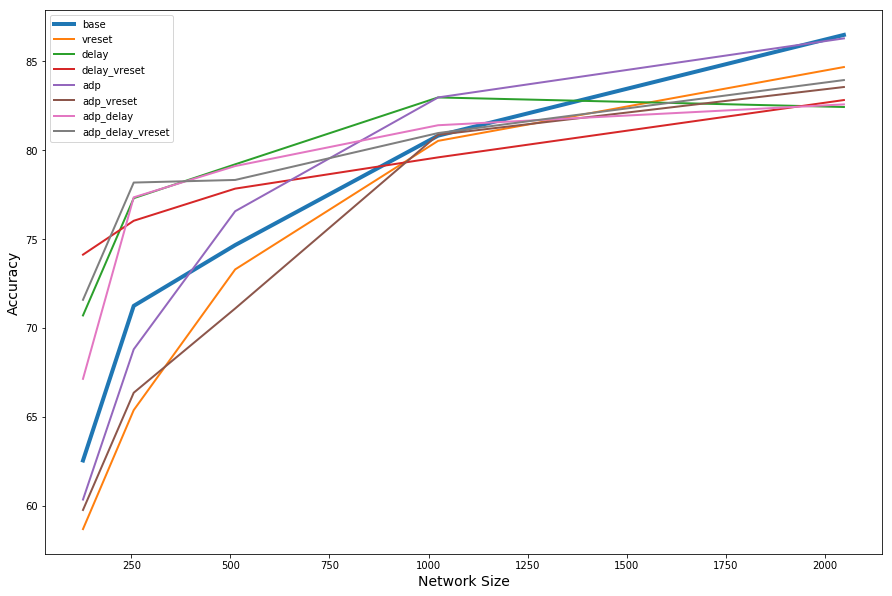

In [84]:
sizes = [128, 256, 512, 1024, 2048]

fig = plt.figure(figsize=(15,10))

for i, group in enumerate(groups):
    if group=='':
        group='base'
        lw = 4
    else:
        lw = 2
    plt.plot(sizes, accs[:,i], lw=lw, label=group)

plt.xlabel('Network Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

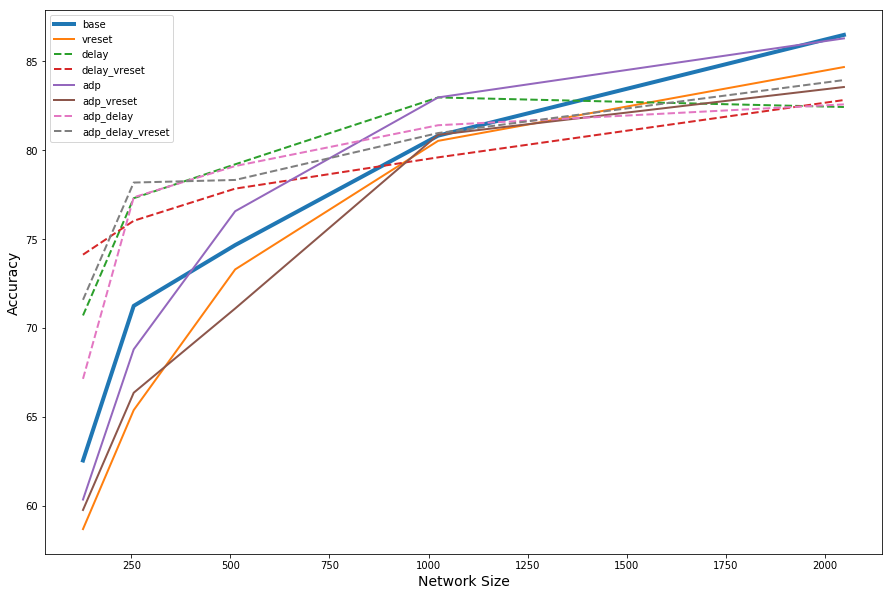

In [86]:
sizes = [128, 256, 512, 1024, 2048]

fig = plt.figure(figsize=(15,10))

#linestyles = ['-', '--','-.',':']

for i, group in enumerate(groups):
    if group=='':
        group='base'
        lw = 4
        ls = '-'
    elif 'delay' in group:
        ls = '--'
        lw=2
    else:
        ls = '-'
        lw = 2
        
    plt.plot(sizes, accs[:,i], lw=lw, ls= ls, label=group)

plt.xlabel('Network Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

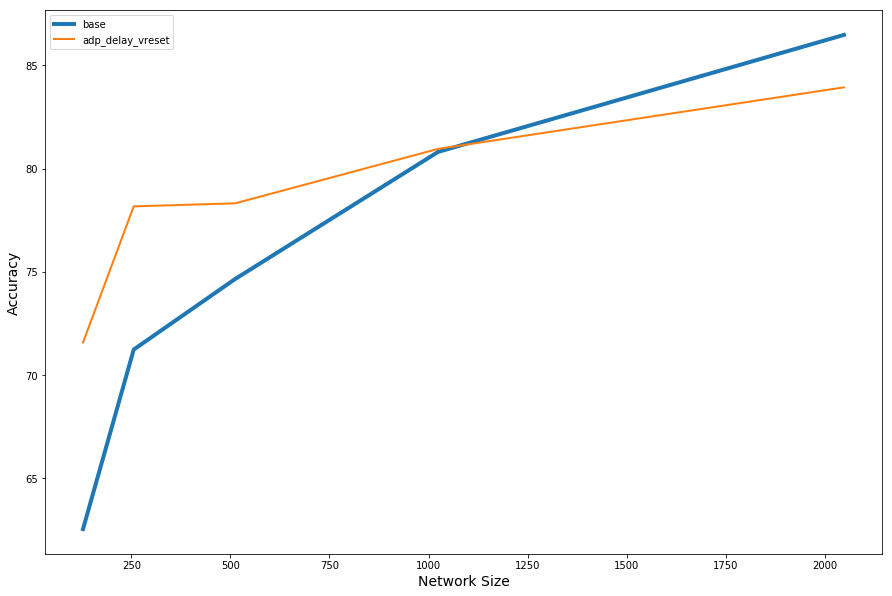

In [72]:
fig = plt.figure(figsize=(15,10))

for group in ['', 'adp_delay_vreset']:
    if group=='':
        group='base'
        lw = 4
        i=0
    else:
        lw = 2
        i=7
    plt.plot(sizes, accs[:,i], lw=lw, label=group)

plt.xlabel('Network Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

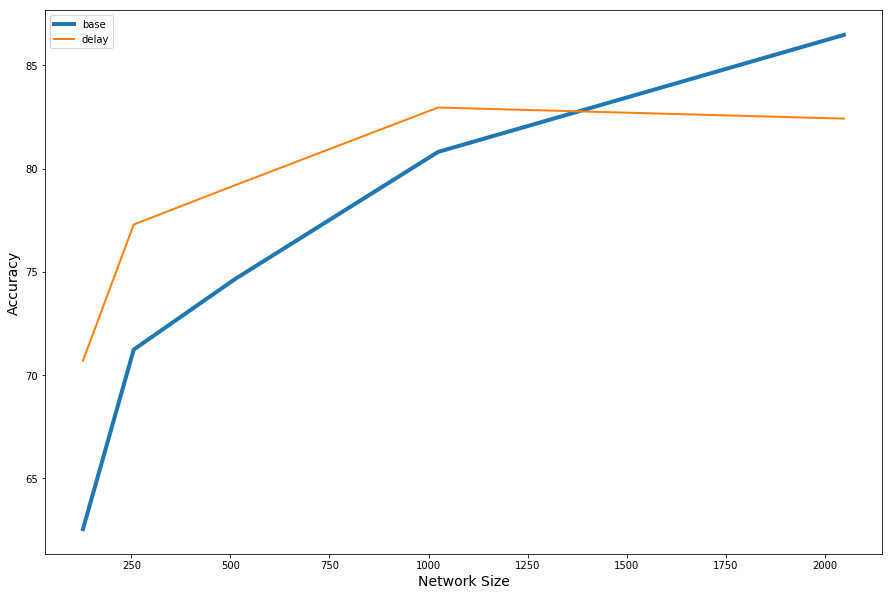

In [73]:
fig = plt.figure(figsize=(15,10))

for group in ['', 'delay']:
    if group=='':
        group='base'
        lw = 4
        i=0
    else:
        lw = 2
        i=2
    plt.plot(sizes, accs[:,i], lw=lw, label=group)

plt.xlabel('Network Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

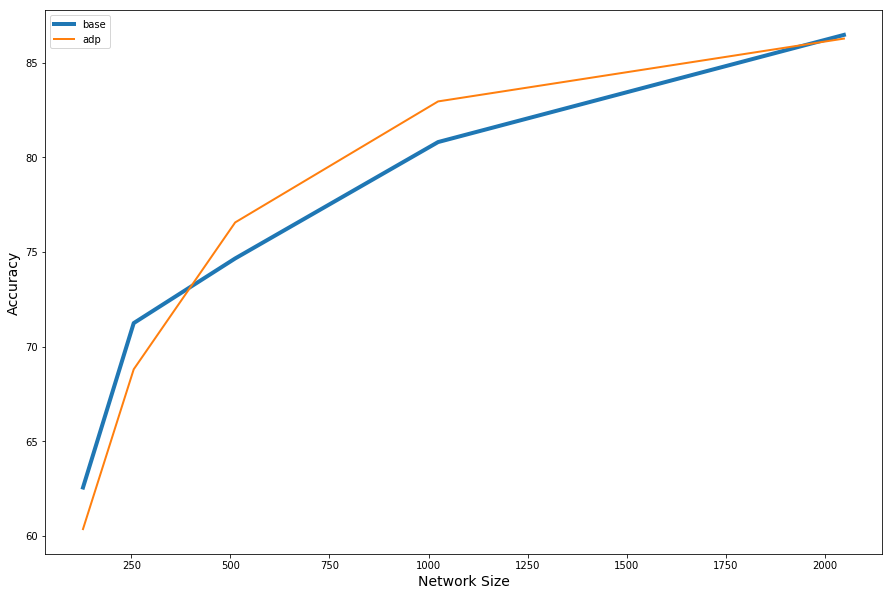

In [74]:
fig = plt.figure(figsize=(15,10))

for group in ['', 'adp']:
    if group=='':
        group='base'
        lw = 4
        i=0
    else:
        lw = 2
        i=4
    plt.plot(sizes, accs[:,i], lw=lw, label=group)

plt.xlabel('Network Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

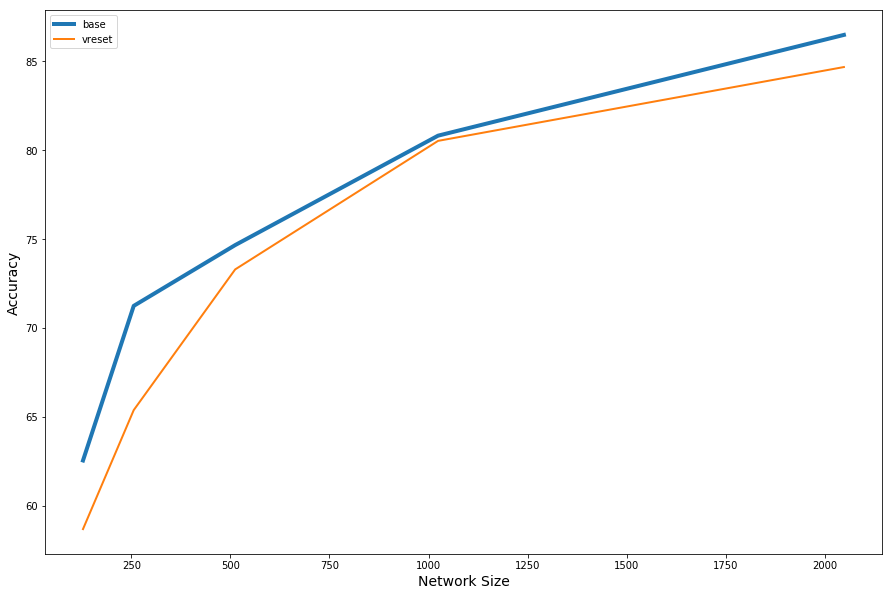

In [75]:
fig = plt.figure(figsize=(15,10))

for group in ['', 'vreset']:
    if group=='':
        group='base'
        lw = 4
        i=0
    else:
        lw = 2
        i=1
    plt.plot(sizes, accs[:,i], lw=lw, label=group)

plt.xlabel('Network Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()

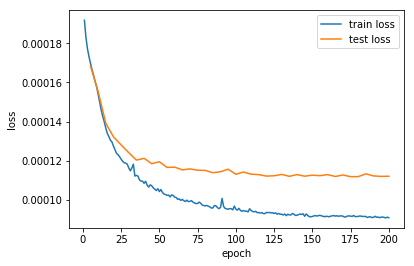

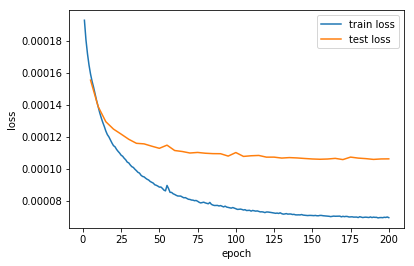

In [91]:
m = RSNN()
m.load_model('shd_rnn_128.t7')
fig = m.plot_loss()

m = RSNN_d()
m.load_model('shd_rnn_128_delay.t7')
fig = m.plot_loss()

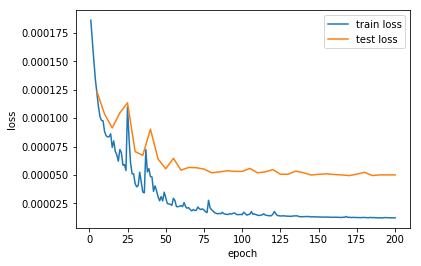

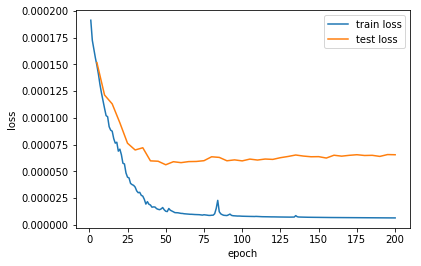

In [92]:
m = RSNN()
m.load_model('shd_rnn_2048.t7')
fig = m.plot_loss()

m = RSNN_d()
m.load_model('shd_rnn_2048_delay.t7')
fig = m.plot_loss()

In [ ]:
m.plot_weights('')